In [1]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go
import pylab as pl

from heapq import *
import math
import glob

import re
import csv
from scipy import interpolate
import scipy.ndimage
from scipy.stats import norm
from scipy.stats import gaussian_kde

from spindle_tracker.io.trackmate import trackmate_peak_import
from spindle_tracker.io import TiffFile
import skimage.measure as measure
from skimage import exposure
from read_roi import read_roi_zip
from matplotlib.path import Path

In [2]:
def n_premiers(generator, n=2):
    result = []
    for elt in iter(generator):
        if len(result) < n:
            heappush(result, elt)
        elif elt > result[0]:
            heapreplace(result, elt)
    return [heappop(result) for i in range(n)]

def deuxPointsMaxDistance (list_point_x, list_point_y) : 
    result = []
    d_final = -1
    id_final1 = -1
    id_final2 = -1
    for id1 in range (len(list_point_x)) : 
        for id2 in range (len(list_point_x)) : 
            d = distance (list_point_x.iloc[id1],list_point_y.iloc[id1],list_point_x.iloc[id2],list_point_y.iloc[id2])
            if d > d_final :
                d_final = d
                id_final1=id1
                id_final2=id2
    
    result = [id_final1, id_final2]
    return result

def distance(x1, y1, x2, y2) : 
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def define_threshold (image_one_frame, roi_cell, roi_position_start, num_cell):
    set_roi =[]
    for i in range (len(roi_cell['x'])):
        set_roi.append((roi_cell['x'][i],roi_cell['y'][i]))
    path = Path(set_roi)

    pixel_in_ROI = []
    x0 = (roi_position_start.iloc[int(num_cell)-1]["BX"])
    y0 = (roi_position_start.iloc[int(num_cell)-1]["BY"])


    for y in range (image_one_frame.shape[0]) : 
        for x in range (image_one_frame.shape[1]):

            # Coordonnees de chaque "point " en pixel.
            x_current = (x0+(x*0.1066))/0.1066
            y_current = (y0+(y*0.1066))/0.1066
            #print (str((y0+(y*0.1066))/0.1066) +"\t"+ str((x0+(x*0.1066))/0.1066))

            # Est-ce que ce pixel est dans la ROI ? 
            grid = path.contains_points([(x_current,y_current)])

            if(grid == True):
                pixel_in_ROI.append(image_one_frame[y, x])


    n,bins,patches = plt.hist(pixel_in_ROI, bins=256)
    seuil = bins[n.argmax()]
    return seuil

def define_mean_noise_outside (image_one_frame, roi_cell, roi_position_start, num_cell):
    set_roi =[]
    for i in range (len(roi_cell['x'])):
        set_roi.append((roi_cell['x'][i],roi_cell['y'][i]))
    path = Path(set_roi)

    pixel_not_in_ROI = []
    x0 = (roi_position_start.iloc[int(num_cell)-1]["BX"])
    y0 = (roi_position_start.iloc[int(num_cell)-1]["BY"])


    for y in range (image_one_frame.shape[0]) : 
        for x in range (image_one_frame.shape[1]):

            # Coordonnees de chaque "point " en pixel.
            x_current = (x0+(x*0.1066))/0.1066
            y_current = (y0+(y*0.1066))/0.1066
            #print (str((y0+(y*0.1066))/0.1066) +"\t"+ str((x0+(x*0.1066))/0.1066))

            # Est-ce que ce pixel est dans la ROI ? 
            grid = path.contains_points([(x_current,y_current)])

            if(grid == False):
                pixel_not_in_ROI.append(image_one_frame[y, x])


    noise = np.mean(pixel_not_in_ROI)
    return noise

def define_noise_inside (image_one_frame, roi_cell, roi_position_start, num_cell):
    set_roi =[]
    for i in range (len(roi_cell['x'])):
        set_roi.append((roi_cell['x'][i],roi_cell['y'][i]))
    path = Path(set_roi)

    pixel_in_ROI = []
    x0 = (roi_position_start.iloc[int(num_cell)-1]["BX"])
    y0 = (roi_position_start.iloc[int(num_cell)-1]["BY"])


    for y in range (image_one_frame.shape[0]) : 
        for x in range (image_one_frame.shape[1]):

            # Coordonnees de chaque "point " en pixel.
            x_current = (x0+(x*0.1066))/0.1066
            y_current = (y0+(y*0.1066))/0.1066
            #print (str((y0+(y*0.1066))/0.1066) +"\t"+ str((x0+(x*0.1066))/0.1066))

            # Est-ce que ce pixel est dans la ROI ? 
            grid = path.contains_points([(x_current,y_current)])

            if(grid == True):
                pixel_in_ROI.append(image_one_frame[y, x])


    n,bins,patches = plt.hist(pixel_in_ROI, bins=256)
    seuil = bins[n.argmax()]
    return seuil

In [8]:
directory1 = "/media/sophie/Sophie/20170404/1804_2/X0_Y0_MITOSIS"
directory2 = "/media/sophie/Sophie/20170404/1804_3/X0_Y0_MITOSIS"
directory3 = "/media/sophie/Sophie/20170405/1804_2/X0_Y0_MITOSIS"
directory4 = "/media/sophie/Sophie/20170405/1804_3/X0_Y0_MITOSIS"
directory5 = "/media/sophie/Sophie/20170405/1804_5/X0_Y0_MITOSIS"
directory6 = "/media/sophie/Sophie/20170406/1804_8/X0_Y0_MITOSIS"
list_directory = [directory1, directory2,directory3,directory4,directory5,directory6]

for directory in list_directory : 

    os.chdir(directory)
    list_detected_mitosis =  os.listdir("croppedImgs_deconvolved2")
    # Recuperation des coordonnees des ROI de tout les crops
    rois = read_roi_zip("../X0_Y0/ROI.zip")
    roi_start = pd.read_csv("../X0_Y0/ROI_start.csv", sep=",") 

    for cell in list_detected_mitosis : 
        print ("Cellule en analyse : " + cell)  
        
        #res_cell = pd.DataFrame(columns=["frame", "posx_pole1", "posy_pole1","posx_pole2", "posy_pole2", "posx_start","posy_start", "posx_end", "posy_end"])

        res_cell = pd.DataFrame(columns=["frame", "pole1","pole2", "start", "end"])

        num_cell = cell.split('_')[0]
        
        
                
        
        anaphase_onset = 0
        list_file_anaphase_onset = os.listdir("figs")
        anaphase_onset_file_name = ""
        for f in list_file_anaphase_onset : 
            if f.startswith(str(num_cell)+"_slopChangePoints"):
                anaphase_onset_file_name=f
                anaphase_onset = anaphase_onset_file_name.split('_')[2]
        

        # Definir si la cellule est en mitose ou non
        """cellule_en_mitose =  input("Est-ce une mitose? ('o' ou 'n') :\t")
        while cellule_en_mitose!='o' and cellule_en_mitose!='n' :
            cellule_en_mitose = input("Vous pouvez repeter la reponse!!! \n Est-ce une mitose? ('o' ou 'n'): \t")                
        if cellule_en_mitose == 'n':
            print ("C'est la loose")
        else :
            print ("Youpie c'est une mitose!!! <3")"""


        """Ouverture du crop"""
        crop = TiffFile("croppedImgs_deconvolved2/"+cell)
        arr = crop.asarray()
        arr = np.squeeze(arr)
        #log.info("Convert tiff to 8bit")
        #arr = np.round(255.0 * (arr - arr.min()) / (arr.max() - arr.min() - 1.0)).astype(np.uint8)

        # Perform maximum projection on second axis
        # Structure du crop_projection
        # [a,y,x], avec 'a' le numero de la frame
        crop_projection = arr.max(axis=1)

        #print (crop_projection.shape)

        # Recuperation des frames d'interet
        frames = pd.read_csv("frame_mitosis.csv", sep=";") 
        debut_mitose = int(frames.loc[frames["cell"]==int(num_cell),"start"])
        fin_mitose = int(frames.loc[frames["cell"]==int(num_cell),"end"])



        # Recuperation des positions des SPBs
        spotsPath = "spots/"+cell[:-10]+".xml"
        if os.path.lexists(spotsPath):
            gfpSpots = trackmate_peak_import(spotsPath,False)

        #seuil = define_threshold(crop_projection[0], rois[str(num_cell)], roi_start, num_cell)  
        noise = define_noise_inside(crop_projection[0], rois[str(num_cell)], roi_start, num_cell) 


        for num_frame in range (int(debut_mitose), int(fin_mitose)):
        #for num_frame in gfpSpots.index.levels[0]:
            #print ("\n\n")
            current_frame_poles = gfpSpots.loc[num_frame]
            
            if len(current_frame_poles)>1:

                # Extract line 
                # Conversion en pixel necessaire ????? A Aller chercher dans un fichier expres creer avec imageJ
                #list_id = n_premiers(current_frame_poles["q"], 2)
                """ x0 = (current_frame_poles[current_frame_poles['q']==list_id[0]]['x'].values - roi_start.iloc[int(num_cell)-1]["BX"] ) /0.1066
                y0 = (current_frame_poles[current_frame_poles['q']==list_id[0]]['y'].values - roi_start.iloc[int(num_cell)-1]["BY"] ) /0.1066
                x1 = (current_frame_poles[current_frame_poles['q']==list_id[1]]['x'].values - roi_start.iloc[int(num_cell)-1]["BX"] ) /0.1066
                y1 = (current_frame_poles[current_frame_poles['q']==list_id[1]]['y'].values - roi_start.iloc[int(num_cell)-1]["BY"] ) /0.1066
                """
                
                
                list_id = deuxPointsMaxDistance (current_frame_poles['x'], current_frame_poles['y']) 
                x0 = (current_frame_poles.iloc[list_id[0]]['x'] - roi_start.iloc[int(num_cell)-1]["BX"] ) /0.1066
                y0 = (current_frame_poles.iloc[list_id[0]]['y'] - roi_start.iloc[int(num_cell)-1]["BY"] ) /0.1066
                x1 = (current_frame_poles.iloc[list_id[1]]['x'] - roi_start.iloc[int(num_cell)-1]["BX"] ) /0.1066
                y1 = (current_frame_poles.iloc[list_id[1]]['y'] - roi_start.iloc[int(num_cell)-1]["BY"] ) /0.1066
                
                
                
                #diff = max(current_frame_poles["q"])-noise
                diff = ((measure.profile_line(crop_projection[num_frame], (y0,x0), (y0,x0), linewidth=1))+(measure.profile_line(crop_projection[num_frame], (y1,x1), (y1,x1), linewidth=1)))/2-noise
                #print (measure.profile_line(crop_projection[num_frame], (y0,x0), (y0,x0), linewidth=1))
                seuil = noise + diff*8/100


                """print (str(x0)+'\t'+str(y0))
                print (str(x1)+'\t'+str(y1))"""


                """# Rotate image pour avoir le fuseau horizontal et aligne
                adj = np.abs(x1-x0)
                hyp = distance(x0,y0,x1,y1)
                angle = np.arccos(adj/hyp)
                angle = angle*180/math.pi
                #print (angle)
                img_rot=scipy.ndimage.interpolation.rotate(crop_projection[num_frame], -angle)"""



                #crop_projection[num_frame] = crop_projection[num_frame]-(noise/2)
                var=5
                # "kymographe sur une frame " 
                zi = (measure.profile_line(crop_projection[num_frame], (y0,x0), (y1,x1), linewidth=var))
                # Normalisation
                #zi=zi/crop_projection[num_frame].max()
                #zi = zi-noise



                g = np.linspace(seuil, seuil, len(zi))

                ##intersections =np.pad(np.diff(np.array(zi > g).astype(int)), (1,0), 'constant', constant_values = (0,))
                intersections = np.argwhere(np.diff(np.sign(zi - g)) != 0).reshape(-1) + 0            
                #print (intersections)



                """fig, axes = plt.subplots(nrows=2)
                #fig, axes = plt.subplots(ncols=2)
                plt.title(num_frame)
                axes[0].imshow(crop_projection[num_frame])
                axes[0].plot([x0,x1], [y0,y1], 'ro-',lw=var, alpha=0.3)

                axes[0].axis('image')
                #axes[1].imshow(img_rot)
                axes[1].plot(zi)
                axes[1].plot(intersections,zi[intersections],'ro')
                axes[1].plot(g)
                axes[1].plot(np.linspace(noise, noise, len(zi)))
                plt.show()"""

                
                spindle_size = distance(x0*0.1066,y0*0.1066,x1*0.1066,y1*0.1066)
                interdigitate_size = 0
                if len(intersections)==0 :
                    interdigitate_size = float(spindle_size)
                    start_interdigite = 0
                    end_interdigite   = spindle_size
                    x_start = x0
                    y_start = y0
                    x_end = x1
                    y_end = y1
                    
                if len(intersections)==2 :
                    if zi[max(intersections)-min(intersections)] > noise : 
                        start_interdigite = intersections[0]*0.1066
                        end_interdigite   = intersections[1]*0.1066
                        interdigitate_size = np.abs(intersections[1]*0.1066-intersections[0]*0.1066)
                        
                        d_pourcent = start_interdigite*0.1066 
                        
                        
                        d0 = distance (0,0,x0,y0)
                        d1 = distance (0,0,x1,y1)
                        val_min = min(d0,d1)
                        if (val_min == d0) :
                            alpha = np.arccos((x1-x0)*0.1066/(spindle_size))
                            x_start = x0 + (d_pourcent* np.cos(alpha))
                            y_start = y0 + (d_pourcent* np.sin(alpha))
                            d_pourcent = d_pourcent+interdigitate_size 
                            x_end = x0 + (d_pourcent* np.cos(alpha))
                            y_end = y0 + (d_pourcent* np.sin(alpha))
                        else : 
                            alpha = np.arccos((x0-x1)*0.1066/(spindle_size))
                            x_start = x1+ (d_pourcent* np.cos(alpha))
                            y_start = y1+ (d_pourcent* np.sin(alpha))
                            d_pourcent = d_pourcent+interdigitate_size
                            x_end = x1+ (d_pourcent* np.cos(alpha))
                            y_end = y1+ (d_pourcent* np.sin(alpha))
                                               
                        
                if len(intersections)==4 :
                    if num_frame<=int(anaphase_onset ): 
                        start_interdigite = intersections[0]*0.1066
                        end_interdigite   = intersections[3]*0.1066
                        interdigitate_size = np.abs(intersections[3]*0.1066-intersections[0]*0.1066) 
                        d_pourcent = start_interdigite*0.1066
                        d0 = distance (0,0,x0,y0)
                        d1 = distance (0,0,x1,y1)
                        val_min = min(d0,d1)
                        if (val_min == d0) :
                            alpha = np.arccos((x1-x0)*0.1066/(spindle_size))
                            x_start = x0 + (d_pourcent* np.cos(alpha))
                            y_start = y0 + (d_pourcent* np.sin(alpha))
                            d_pourcent = d_pourcent+interdigitate_size
                            x_end = x0 + (d_pourcent* np.cos(alpha))
                            y_end = y0 + (d_pourcent* np.sin(alpha))
                        else : 
                            alpha = np.arccos((x0-x1)*0.1066/(spindle_size))
                            x_start = x1+ (d_pourcent* np.cos(alpha))
                            y_start = y1+ (d_pourcent* np.sin(alpha))
                            d_pourcent = d_pourcent+interdigitate_size
                            x_end = x1+ (d_pourcent* np.cos(alpha))
                            y_end = y1+ (d_pourcent* np.sin(alpha))
                    else : 
                        start_interdigite = intersections[1]*0.1066
                        end_interdigite   = intersections[2]*0.1066
                        interdigitate_size = np.abs(intersections[2]*0.1066-intersections[1]*0.1066) 
                        d_pourcent = start_interdigite*0.1066
                        d0 = distance (0,0,x0,y0)
                        d1 = distance (0,0,x1,y1)
                        val_min = min(d0,d1)
                        if (val_min == d0) :
                            alpha = np.arccos((x1-x0)*0.1066/(spindle_size))
                            x_start = x0 + (d_pourcent* np.cos(alpha))
                            y_start = y0 + (d_pourcent* np.sin(alpha))
                            d_pourcent = d_pourcent+interdigitate_size
                            x_end = x0 + (d_pourcent* np.cos(alpha))
                            y_end = y0 + (d_pourcent* np.sin(alpha))
                        else : 
                            alpha = np.arccos((x0-x1)*0.1066/(spindle_size))
                            x_start = x1+ (d_pourcent* np.cos(alpha))
                            y_start = y1+ (d_pourcent* np.sin(alpha))
                            d_pourcent = d_pourcent+interdigitate_size
                            x_end = x1+ (d_pourcent* np.cos(alpha))
                            y_end = y1+ (d_pourcent* np.sin(alpha))
                      
                        
                if len(intersections)==6 :
                    start_interdigite = intersections[1]*0.1066
                    end_interdigite   = intersections[4]*0.1066
                    interdigitate_size = np.abs(intersections[4]*0.1066-intersections[1]*0.1066) 
                    d_pourcent = start_interdigite*0.1066
                    d0 = distance (0,0,x0,y0)
                    d1 = distance (0,0,x1,y1)
                    val_min = min(d0,d1)
                    if (val_min == d0) :
                        alpha = np.arccos((x1-x0)*0.1066/(spindle_size))
                        x_start = x0 + (d_pourcent* np.cos(alpha))
                        y_start = y0 + (d_pourcent* np.sin(alpha))
                        d_pourcent = d_pourcent+interdigitate_size
                        x_end = x0 + (d_pourcent* np.cos(alpha))
                        y_end = y0 + (d_pourcent* np.sin(alpha))
                    else : 
                        alpha = np.arccos((x0-x1)*0.1066/(spindle_size))
                        x_start = x1+ (d_pourcent* np.cos(alpha))
                        y_start = y1+ (d_pourcent* np.sin(alpha))
                        d_pourcent = d_pourcent+interdigitate_size
                        x_end = x1+ (d_pourcent* np.cos(alpha))
                        y_end = y1+ (d_pourcent* np.sin(alpha))
                if len(intersections)==8 :
                    start_interdigite = intersections[1]*0.1066
                    end_interdigite   = intersections[6]*0.1066
                    interdigitate_size = np.abs(intersections[6]*0.1066-intersections[1]*0.1066) 
                    d_pourcent = start_interdigite*0.1066
                    d0 = distance (0,0,x0,y0)
                    d1 = distance (0,0,x1,y1)
                    val_min = min(d0,d1)
                    if (val_min == d0) :
                        alpha = np.arccos((x1-x0)*0.1066/(spindle_size))
                        x_start = x0 + (d_pourcent* np.cos(alpha))
                        y_start = y0 + (d_pourcent* np.sin(alpha))
                        d_pourcent = d_pourcent+interdigitate_size
                        x_end = x0 + (d_pourcent* np.cos(alpha))
                        y_end = y0 + (d_pourcent* np.sin(alpha))
                    else : 
                        alpha = np.arccos((x0-x1)*0.1066/(spindle_size))
                        x_start = x1+ (d_pourcent* np.cos(alpha))
                        y_start = y1+ (d_pourcent* np.sin(alpha))
                        d_pourcent = d_pourcent+interdigitate_size
                        x_end = x1+ (d_pourcent* np.cos(alpha))
                        y_end = y1+ (d_pourcent* np.sin(alpha))
                
                pourcentage = interdigitate_size*100/float(spindle_size)
                #res_cell.loc[num_frame]=({"frame":num_frame, "spindle_size":float(spindle_size), "interdigitated_size":interdigitate_size, "nb_point_detecte":len(intersections), "pourcentage":pourcentage})
                                
                
                res_cell.loc[num_frame]=({"frame":num_frame,"pole1" : 0,\
                                                            "pole2":spindle_size,\
                                                            "start":start_interdigite, \
                                                            "end":end_interdigite})

        res_cell.to_csv("../Simon/"+str(num_cell)+"_results.csv", sep=";")


        #fig,ax = plt.subplots(figsize=(10,5))
        #ax.plot(res_cell["spindle_size"].values, 'k.')
        #ax.plot(res_cell["interdigitated_size"].values, 'r.')
        ##ax.set_ylim([0,max()])
        #handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles, labels)
        #ax.set_ylabel('Taille(µm)', fontsize=15)
        #ax.set_xlabel('Temps(s)', fontsize=15) 
        #plt.savefig(cell[:-10]+".png")
        
print ("END")
                    

Cellule en analyse : 112_GFP_decon.tif
Cellule en analyse : 60_GFP_decon.tif
Cellule en analyse : 77_GFP_decon.tif
Cellule en analyse : 107_GFP_decon.tif
Cellule en analyse : 120_GFP_decon.tif
Cellule en analyse : 122_GFP_decon.tif
Cellule en analyse : 137_GFP_decon.tif
Cellule en analyse : 201_GFP_decon.tif
Cellule en analyse : 228_GFP_decon.tif
Cellule en analyse : 230_GFP_decon.tif
Cellule en analyse : 234_GFP_decon.tif
Cellule en analyse : 244_GFP_decon.tif
Cellule en analyse : 253_GFP_decon.tif
Cellule en analyse : 268_GFP_decon.tif
Cellule en analyse : 285_GFP_decon.tif
Cellule en analyse : 380_GFP_decon.tif
Cellule en analyse : 402_GFP_decon.tif
Cellule en analyse : 416_GFP_decon.tif
Cellule en analyse : 422_GFP_decon.tif
Cellule en analyse : 443_GFP_decon.tif
Cellule en analyse : 494_GFP_decon.tif
Cellule en analyse : 530_GFP_decon.tif
Cellule en analyse : 541_GFP_decon.tif
Cellule en analyse : 550_GFP_decon.tif
Cellule en analyse : 696_GFP_decon.tif
Cellule en analyse : 705_GF

# Compilation des résultats

In [4]:
# Compilation des resultats
#os.chdir("/media/sophie/Sophie/20170404/1804_3/X0_Y0_MITOSIS/")
directory1 = "/media/sophie/Sophie/20170404/1804_2/X0_Y0_MITOSIS"
directory2 = "/media/sophie/Sophie/20170404/1804_3/X0_Y0_MITOSIS"
directory3 = "/media/sophie/Sophie/20170405/1804_2/X0_Y0_MITOSIS"
directory4 = "/media/sophie/Sophie/20170405/1804_3/X0_Y0_MITOSIS"
directory5 = "/media/sophie/Sophie/20170405/1804_5/X0_Y0_MITOSIS"
directory6 = "/media/sophie/Sophie/20170406/1804_8/X0_Y0_MITOSIS"
list_directory = [directory1, directory2,directory3,directory4,directory5,directory6]


directory_size_list = {"0.1":list(),"0.3":list(),"0.5":list(),"0.7":list(),"0.9":list(),\
                       "1.1":list(),"1.3":list(),"1.5":list(),"1.7":list(),"1.9":list(),\
                       "2.1":list(),"2.3":list(),"2.5":list(),"2.7":list(),"2.9":list(),\
                       "3.1":list(),"3.3":list(),"3.5":list(),"3.7":list(),"3.9":list(),\
                       "4.1":list(),"4.3":list(),"4.5":list(),"4.7":list(),"4.9":list(),\
                       "5.1":list(),"5.3":list(),"5.5":list(),"5.7":list(),"5.9":list(),\
                       "6.1":list(),"6.3":list(),"6.5":list(),"6.7":list(),"6.9":list(),\
                       "7.1":list(),"7.3":list(),"7.5":list(),"7.7":list(),"7.9":list(),\
                       "8.1":list(),"8.3":list(),"8.5":list(),"8.7":list(),"8.9":list(),\
                       "9.1":list(),"9.3":list(),"9.5":list(),"9.7":list(),"9.9":list(),\
                       "10.1":list(),"10.3":list(),"10.5":list(),"10.7":list(),"10.9":list(),\
                       "11.1":list(),"11.3":list(),"11.5":list(),"11.7":list(),"11.9":list(),\
                       "12.1":list(),"12.3":list(),"12.5":list(),"12.7":list(),"12.9":list(),\
                       "13.1":list(),"13.3":list(),"13.5":list(),"13.7":list(),"13.9":list(),\
                       "14.1":list(),"14.3":list(),"14.5":list(),"14.7":list(),"14.9":list(),\
                       "15.1":list(),"15.3":list(),"15.5":list(),"15.7":list(),"15.9":list()}

for directory in list_directory : 
    list_file = os.listdir()
    
    for file in list_file : 
        if file.endswith("results.csv"):
            result = pd.read_csv(file, sep=";") 
            
            
             #for spindle_size in result["spindle_size"]: 
            for index in range (len(result)):
                if result.loc[index,"interdigitated_size"] != 0 : 
                    if     0 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 0.2 : 
                        directory_size_list["0.1"].append(result.loc[index,"interdigitated_size"])
                    elif 0.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 0.4 : 
                        directory_size_list["0.3"].append(result.loc[index,"interdigitated_size"])
                    elif 0.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 0.6 : 
                        directory_size_list["0.5"].append(result.loc[index,"interdigitated_size"])
                    elif 0.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 0.8 : 
                        directory_size_list["0.7"].append(result.loc[index,"interdigitated_size"])
                    elif 0.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.0 : 
                        directory_size_list["0.9"].append(result.loc[index,"interdigitated_size"])
                        
                    elif 1 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.2 : 
                        directory_size_list["1.1"].append(result.loc[index,"interdigitated_size"])
                    elif 1.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.4 : 
                        directory_size_list["1.3"].append(result.loc[index,"interdigitated_size"])
                    elif 1.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.6 : 
                        directory_size_list["1.5"].append(result.loc[index,"interdigitated_size"])
                    elif 1.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.8 : 
                        directory_size_list["1.7"].append(result.loc[index,"interdigitated_size"])
                    elif 1.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2 : 
                        directory_size_list["1.9"].append(result.loc[index,"interdigitated_size"])
                    
                    elif 2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2.2 : 
                        directory_size_list["2.1"].append(result.loc[index,"interdigitated_size"])
                    elif 2.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2.4 : 
                        directory_size_list["2.3"].append(result.loc[index,"interdigitated_size"])
                    elif 2.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2.6 : 
                        directory_size_list["2.5"].append(result.loc[index,"interdigitated_size"])
                    elif 2.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2.8 : 
                        directory_size_list["2.7"].append(result.loc[index,"interdigitated_size"])
                    elif 2.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3 : 
                        directory_size_list["2.9"].append(result.loc[index,"interdigitated_size"])
                    
                    elif 3 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3.2 : 
                        directory_size_list["3.1"].append(result.loc[index,"interdigitated_size"])
                    elif 3.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3.4 : 
                        directory_size_list["3.3"].append(result.loc[index,"interdigitated_size"])
                    elif 3.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3.6 : 
                        directory_size_list["3.5"].append(result.loc[index,"interdigitated_size"])
                    elif 3.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3.8 : 
                        directory_size_list["3.7"].append(result.loc[index,"interdigitated_size"])
                    elif 3.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4 : 
                        directory_size_list["3.9"].append(result.loc[index,"interdigitated_size"])

                    elif 4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4.2 : 
                        directory_size_list["4.1"].append(result.loc[index,"interdigitated_size"])
                    elif 4.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4.4 : 
                        directory_size_list["4.3"].append(result.loc[index,"interdigitated_size"])
                    elif 4.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4.6 : 
                        directory_size_list["4.5"].append(result.loc[index,"interdigitated_size"])
                    elif 4.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4.8 : 
                        directory_size_list["4.7"].append(result.loc[index,"interdigitated_size"])
                    elif 4.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5 : 
                        directory_size_list["4.9"].append(result.loc[index,"interdigitated_size"])

                    elif 5 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5.2 : 
                        directory_size_list["5.1"].append(result.loc[index,"interdigitated_size"])
                    elif 5.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5.4 : 
                        directory_size_list["5.3"].append(result.loc[index,"interdigitated_size"])
                    elif 5.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5.6 : 
                        directory_size_list["5.5"].append(result.loc[index,"interdigitated_size"])
                    elif 5.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5.8 : 
                        directory_size_list["5.7"].append(result.loc[index,"interdigitated_size"])
                    elif 5.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5 : 
                        directory_size_list["5.9"].append(result.loc[index,"interdigitated_size"])

                    elif 6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6.2 : 
                        directory_size_list["6.1"].append(result.loc[index,"interdigitated_size"])
                    elif 6.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6.4 : 
                        directory_size_list["6.3"].append(result.loc[index,"interdigitated_size"])
                    elif 6.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6.6 : 
                        directory_size_list["6.5"].append(result.loc[index,"interdigitated_size"])
                    elif 6.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6.8 : 
                        directory_size_list["6.7"].append(result.loc[index,"interdigitated_size"])
                    elif 6.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6 : 
                        directory_size_list["6.9"].append(result.loc[index,"interdigitated_size"])

                    elif 7 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7.2 : 
                        directory_size_list["7.1"].append(result.loc[index,"interdigitated_size"])
                    elif 7.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7.4 : 
                        directory_size_list["7.3"].append(result.loc[index,"interdigitated_size"])
                    elif 7.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7.6 : 
                        directory_size_list["7.5"].append(result.loc[index,"interdigitated_size"])
                    elif 7.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7.8 : 
                        directory_size_list["7.7"].append(result.loc[index,"interdigitated_size"])
                    elif 7.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7 : 
                        directory_size_list["7.9"].append(result.loc[index,"interdigitated_size"])

                    elif 8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8.2 : 
                        directory_size_list["8.1"].append(result.loc[index,"interdigitated_size"])
                    elif 8.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8.4 : 
                        directory_size_list["8.3"].append(result.loc[index,"interdigitated_size"])
                    elif 8.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8.6 : 
                        directory_size_list["8.5"].append(result.loc[index,"interdigitated_size"])
                    elif 8.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8.8 : 
                        directory_size_list["8.7"].append(result.loc[index,"interdigitated_size"])
                    elif 8.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8 : 
                        directory_size_list["8.9"].append(result.loc[index,"interdigitated_size"])

                    elif 9 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9.2 : 
                        directory_size_list["9.1"].append(result.loc[index,"interdigitated_size"])
                    elif 9.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9.4 : 
                        directory_size_list["9.3"].append(result.loc[index,"interdigitated_size"])
                    elif 9.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9.6 : 
                        directory_size_list["9.5"].append(result.loc[index,"interdigitated_size"])
                    elif 9.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9.8 : 
                        directory_size_list["9.7"].append(result.loc[index,"interdigitated_size"])
                    elif 9.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9 : 
                        directory_size_list["9.9"].append(result.loc[index,"interdigitated_size"])

                    elif 10 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10.2 : 
                        directory_size_list["10.1"].append(result.loc[index,"interdigitated_size"])
                    elif 10.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10.4 : 
                        directory_size_list["10.3"].append(result.loc[index,"interdigitated_size"])
                    elif 10.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10.6 : 
                        directory_size_list["10.5"].append(result.loc[index,"interdigitated_size"])
                    elif 10.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10.8 : 
                        directory_size_list["10.7"].append(result.loc[index,"interdigitated_size"])
                    elif 10.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10 : 
                        directory_size_list["10.9"].append(result.loc[index,"interdigitated_size"])

                    elif 11 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11.2 : 
                        directory_size_list["11.1"].append(result.loc[index,"interdigitated_size"])
                    elif 11.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11.4 : 
                        directory_size_list["11.3"].append(result.loc[index,"interdigitated_size"])
                    elif 11.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11.6 : 
                        directory_size_list["11.5"].append(result.loc[index,"interdigitated_size"])
                    elif 11.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11.8 : 
                        directory_size_list["11.7"].append(result.loc[index,"interdigitated_size"])
                    elif 11.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11 : 
                        directory_size_list["11.9"].append(result.loc[index,"interdigitated_size"])

                    elif 12 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12.2 : 
                        directory_size_list["12.1"].append(result.loc[index,"interdigitated_size"])
                    elif 12.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12.4 : 
                        directory_size_list["12.3"].append(result.loc[index,"interdigitated_size"])
                    elif 12.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12.6 : 
                        directory_size_list["12.5"].append(result.loc[index,"interdigitated_size"])
                    elif 12.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12.8 : 
                        directory_size_list["12.7"].append(result.loc[index,"interdigitated_size"])
                    elif 12.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12 : 
                        directory_size_list["12.9"].append(result.loc[index,"interdigitated_size"])    

                    elif 13 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13.2 : 
                        directory_size_list["13.1"].append(result.loc[index,"interdigitated_size"])
                    elif 13.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13.4 : 
                        directory_size_list["13.3"].append(result.loc[index,"interdigitated_size"])
                    elif 13.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13.6 : 
                        directory_size_list["13.5"].append(result.loc[index,"interdigitated_size"])
                    elif 13.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13.8 : 
                        directory_size_list["13.7"].append(result.loc[index,"interdigitated_size"])
                    elif 13.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13 : 
                        directory_size_list["13.9"].append(result.loc[index,"interdigitated_size"])

                    elif 14 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14.2 : 
                        directory_size_list["14.1"].append(result.loc[index,"interdigitated_size"])
                    elif 14.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14.4 : 
                        directory_size_list["14.3"].append(result.loc[index,"interdigitated_size"])
                    elif 14.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14.6 : 
                        directory_size_list["14.5"].append(result.loc[index,"interdigitated_size"])
                    elif 14.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14.8 : 
                        directory_size_list["14.7"].append(result.loc[index,"interdigitated_size"])
                    elif 14.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14 : 
                        directory_size_list["14.9"].append(result.loc[index,"interdigitated_size"])

                    elif 15 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15.2 : 
                        directory_size_list["15.1"].append(result.loc[index,"interdigitated_size"])
                    elif 15.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15.4 : 
                        directory_size_list["15.3"].append(result.loc[index,"interdigitated_size"])
                    elif 15.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15.6 : 
                        directory_size_list["15.5"].append(result.loc[index,"interdigitated_size"])
                    elif 15.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15.8 : 
                        directory_size_list["15.7"].append(result.loc[index,"interdigitated_size"])
                    elif 15.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15 : 
                        directory_size_list["15.9"].append(result.loc[index,"interdigitated_size"])
                
            
    
#list_detected_mitosis =  os.listdir("croppedImgs_deconvolved2")

In [5]:
# compilation des resultats pourcentage

directory1 = "/media/sophie/Sophie/20170404/1804_2/X0_Y0_MITOSIS"
directory2 = "/media/sophie/Sophie/20170404/1804_3/X0_Y0_MITOSIS"
directory3 = "/media/sophie/Sophie/20170405/1804_2/X0_Y0_MITOSIS"
directory4 = "/media/sophie/Sophie/20170405/1804_3/X0_Y0_MITOSIS"
directory5 = "/media/sophie/Sophie/20170405/1804_5/X0_Y0_MITOSIS"
directory6 = "/media/sophie/Sophie/20170406/1804_8/X0_Y0_MITOSIS"
list_directory = [directory1, directory2,directory3,directory4,directory5,directory6]


directory_size_list_pourcentage = {"0.1":list(),"0.3":list(),"0.5":list(),"0.7":list(),"0.9":list(),\
                                   "1.1":list(),"1.3":list(),"1.5":list(),"1.7":list(),"1.9":list(),\
                                   "2.1":list(),"2.3":list(),"2.5":list(),"2.7":list(),"2.9":list(),\
                                   "3.1":list(),"3.3":list(),"3.5":list(),"3.7":list(),"3.9":list(),\
                                   "4.1":list(),"4.3":list(),"4.5":list(),"4.7":list(),"4.9":list(),\
                                   "5.1":list(),"5.3":list(),"5.5":list(),"5.7":list(),"5.9":list(),\
                                   "6.1":list(),"6.3":list(),"6.5":list(),"6.7":list(),"6.9":list(),\
                                   "7.1":list(),"7.3":list(),"7.5":list(),"7.7":list(),"7.9":list(),\
                                   "8.1":list(),"8.3":list(),"8.5":list(),"8.7":list(),"8.9":list(),\
                                   "9.1":list(),"9.3":list(),"9.5":list(),"9.7":list(),"9.9":list(),\
                                   "10.1":list(),"10.3":list(),"10.5":list(),"10.7":list(),"10.9":list(),\
                                   "11.1":list(),"11.3":list(),"11.5":list(),"11.7":list(),"11.9":list(),\
                                   "12.1":list(),"12.3":list(),"12.5":list(),"12.7":list(),"12.9":list(),\
                                   "13.1":list(),"13.3":list(),"13.5":list(),"13.7":list(),"13.9":list(),\
                                   "14.1":list(),"14.3":list(),"14.5":list(),"14.7":list(),"14.9":list(),\
                                   "15.1":list(),"15.3":list(),"15.5":list(),"15.7":list(),"15.9":list()}

for directory in list_directory : 
    list_file = os.listdir()
    
    for file in list_file : 
        if file.endswith("results.csv"):
            result = pd.read_csv(file, sep=";") 
            
            
             #for spindle_size in result["spindle_size"]: 
            for index in range (len(result)):
                if result.loc[index,"pourcentage"] != 0 : 
                    if     0 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 0.2 : 
                        directory_size_list_pourcentage["0.1"].append(result.loc[index,"pourcentage"])
                    elif 0.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 0.4 : 
                        directory_size_list_pourcentage["0.3"].append(result.loc[index,"pourcentage"])
                    elif 0.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 0.6 : 
                        directory_size_list_pourcentage["0.5"].append(result.loc[index,"pourcentage"])
                    elif 0.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 0.8 : 
                        directory_size_list_pourcentage["0.7"].append(result.loc[index,"pourcentage"])
                    elif 0.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.0 : 
                        directory_size_list_pourcentage["0.9"].append(result.loc[index,"pourcentage"])
                        
                    elif 1 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.2 : 
                        directory_size_list_pourcentage["1.1"].append(result.loc[index,"pourcentage"])
                    elif 1.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.4 : 
                        directory_size_list_pourcentage["1.3"].append(result.loc[index,"pourcentage"])
                    elif 1.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.6 : 
                        directory_size_list_pourcentage["1.5"].append(result.loc[index,"pourcentage"])
                    elif 1.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 1.8 : 
                        directory_size_list_pourcentage["1.7"].append(result.loc[index,"pourcentage"])
                    elif 1.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2 : 
                        directory_size_list_pourcentage["1.9"].append(result.loc[index,"pourcentage"])
                    
                    elif 2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2.2 : 
                        directory_size_list_pourcentage["2.1"].append(result.loc[index,"pourcentage"])
                    elif 2.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2.4 : 
                        directory_size_list_pourcentage["2.3"].append(result.loc[index,"pourcentage"])
                    elif 2.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2.6 : 
                        directory_size_list_pourcentage["2.5"].append(result.loc[index,"pourcentage"])
                    elif 2.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 2.8 : 
                        directory_size_list_pourcentage["2.7"].append(result.loc[index,"pourcentage"])
                    elif 2.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3 : 
                        directory_size_list_pourcentage["2.9"].append(result.loc[index,"pourcentage"])
                    
                    elif 3 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3.2 : 
                        directory_size_list_pourcentage["3.1"].append(result.loc[index,"pourcentage"])
                    elif 3.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3.4 : 
                        directory_size_list_pourcentage["3.3"].append(result.loc[index,"pourcentage"])
                    elif 3.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3.6 : 
                        directory_size_list_pourcentage["3.5"].append(result.loc[index,"pourcentage"])
                    elif 3.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 3.8 : 
                        directory_size_list_pourcentage["3.7"].append(result.loc[index,"pourcentage"])
                    elif 3.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4 : 
                        directory_size_list_pourcentage["3.9"].append(result.loc[index,"pourcentage"])

                    elif 4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4.2 : 
                        directory_size_list_pourcentage["4.1"].append(result.loc[index,"pourcentage"])
                    elif 4.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4.4 : 
                        directory_size_list_pourcentage["4.3"].append(result.loc[index,"pourcentage"])
                    elif 4.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4.6 : 
                        directory_size_list_pourcentage["4.5"].append(result.loc[index,"pourcentage"])
                    elif 4.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 4.8 : 
                        directory_size_list_pourcentage["4.7"].append(result.loc[index,"pourcentage"])
                    elif 4.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5 : 
                        directory_size_list_pourcentage["4.9"].append(result.loc[index,"pourcentage"])

                    elif 5 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5.2 : 
                        directory_size_list_pourcentage["5.1"].append(result.loc[index,"pourcentage"])
                    elif 5.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5.4 : 
                        directory_size_list_pourcentage["5.3"].append(result.loc[index,"pourcentage"])
                    elif 5.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5.6 : 
                        directory_size_list_pourcentage["5.5"].append(result.loc[index,"pourcentage"])
                    elif 5.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5.8 : 
                        directory_size_list_pourcentage["5.7"].append(result.loc[index,"pourcentage"])
                    elif 5.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 5 : 
                        directory_size_list_pourcentage["5.9"].append(result.loc[index,"pourcentage"])

                    elif 6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6.2 : 
                        directory_size_list_pourcentage["6.1"].append(result.loc[index,"pourcentage"])
                    elif 6.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6.4 : 
                        directory_size_list_pourcentage["6.3"].append(result.loc[index,"pourcentage"])
                    elif 6.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6.6 : 
                        directory_size_list_pourcentage["6.5"].append(result.loc[index,"pourcentage"])
                    elif 6.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6.8 : 
                        directory_size_list_pourcentage["6.7"].append(result.loc[index,"pourcentage"])
                    elif 6.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 6 : 
                        directory_size_list_pourcentage["6.9"].append(result.loc[index,"pourcentage"])

                    elif 7 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7.2 : 
                        directory_size_list_pourcentage["7.1"].append(result.loc[index,"pourcentage"])
                    elif 7.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7.4 : 
                        directory_size_list_pourcentage["7.3"].append(result.loc[index,"pourcentage"])
                    elif 7.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7.6 : 
                        directory_size_list_pourcentage["7.5"].append(result.loc[index,"pourcentage"])
                    elif 7.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7.8 : 
                        directory_size_list_pourcentage["7.7"].append(result.loc[index,"pourcentage"])
                    elif 7.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 7 : 
                        directory_size_list_pourcentage["7.9"].append(result.loc[index,"pourcentage"])

                    elif 8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8.2 : 
                        directory_size_list_pourcentage["8.1"].append(result.loc[index,"pourcentage"])
                    elif 8.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8.4 : 
                        directory_size_list_pourcentage["8.3"].append(result.loc[index,"pourcentage"])
                    elif 8.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8.6 : 
                        directory_size_list_pourcentage["8.5"].append(result.loc[index,"pourcentage"])
                    elif 8.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8.8 : 
                        directory_size_list_pourcentage["8.7"].append(result.loc[index,"pourcentage"])
                    elif 8.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 8 : 
                        directory_size_list_pourcentage["8.9"].append(result.loc[index,"pourcentage"])

                    elif 9 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9.2 : 
                        directory_size_list_pourcentage["9.1"].append(result.loc[index,"pourcentage"])
                    elif 9.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9.4 : 
                        directory_size_list_pourcentage["9.3"].append(result.loc[index,"pourcentage"])
                    elif 9.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9.6 : 
                        directory_size_list_pourcentage["9.5"].append(result.loc[index,"pourcentage"])
                    elif 9.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9.8 : 
                        directory_size_list_pourcentage["9.7"].append(result.loc[index,"pourcentage"])
                    elif 9.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 9 : 
                        directory_size_list_pourcentage["9.9"].append(result.loc[index,"pourcentage"])

                    elif 10 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10.2 : 
                        directory_size_list_pourcentage["10.1"].append(result.loc[index,"pourcentage"])
                    elif 10.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10.4 : 
                        directory_size_list_pourcentage["10.3"].append(result.loc[index,"pourcentage"])
                    elif 10.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10.6 : 
                        directory_size_list_pourcentage["10.5"].append(result.loc[index,"pourcentage"])
                    elif 10.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10.8 : 
                        directory_size_list_pourcentage["10.7"].append(result.loc[index,"pourcentage"])
                    elif 10.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 10 : 
                        directory_size_list_pourcentage["10.9"].append(result.loc[index,"pourcentage"])

                    elif 11 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11.2 : 
                        directory_size_list_pourcentage["11.1"].append(result.loc[index,"pourcentage"])
                    elif 11.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11.4 : 
                        directory_size_list_pourcentage["11.3"].append(result.loc[index,"pourcentage"])
                    elif 11.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11.6 : 
                        directory_size_list_pourcentage["11.5"].append(result.loc[index,"pourcentage"])
                    elif 11.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11.8 : 
                        directory_size_list_pourcentage["11.7"].append(result.loc[index,"pourcentage"])
                    elif 11.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 11 : 
                        directory_size_list_pourcentage["11.9"].append(result.loc[index,"pourcentage"])

                    elif 12 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12.2 : 
                        directory_size_list_pourcentage["12.1"].append(result.loc[index,"pourcentage"])
                    elif 12.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12.4 : 
                        directory_size_list_pourcentage["12.3"].append(result.loc[index,"pourcentage"])
                    elif 12.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12.6 : 
                        directory_size_list_pourcentage["12.5"].append(result.loc[index,"pourcentage"])
                    elif 12.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12.8 : 
                        directory_size_list_pourcentage["12.7"].append(result.loc[index,"pourcentage"])
                    elif 12.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 12 : 
                        directory_size_list_pourcentage["12.9"].append(result.loc[index,"pourcentage"])    

                    elif 13 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13.2 : 
                        directory_size_list_pourcentage["13.1"].append(result.loc[index,"pourcentage"])
                    elif 13.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13.4 : 
                        directory_size_list_pourcentage["13.3"].append(result.loc[index,"pourcentage"])
                    elif 13.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13.6 : 
                        directory_size_list_pourcentage["13.5"].append(result.loc[index,"pourcentage"])
                    elif 13.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13.8 : 
                        directory_size_list_pourcentage["13.7"].append(result.loc[index,"pourcentage"])
                    elif 13.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 13 : 
                        directory_size_list_pourcentage["13.9"].append(result.loc[index,"pourcentage"])

                    elif 14 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14.2 : 
                        directory_size_list_pourcentage["14.1"].append(result.loc[index,"pourcentage"])
                    elif 14.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14.4 : 
                        directory_size_list_pourcentage["14.3"].append(result.loc[index,"pourcentage"])
                    elif 14.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14.6 : 
                        directory_size_list_pourcentage["14.5"].append(result.loc[index,"pourcentage"])
                    elif 14.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14.8 : 
                        directory_size_list_pourcentage["14.7"].append(result.loc[index,"pourcentage"])
                    elif 14.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 14 : 
                        directory_size_list_pourcentage["14.9"].append(result.loc[index,"pourcentage"])

                    elif 15 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15.2 : 
                        directory_size_list_pourcentage["15.1"].append(result.loc[index,"pourcentage"])
                    elif 15.2 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15.4 : 
                        directory_size_list_pourcentage["15.3"].append(result.loc[index,"pourcentage"])
                    elif 15.4 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15.6 : 
                        directory_size_list_pourcentage["15.5"].append(result.loc[index,"pourcentage"])
                    elif 15.6 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15.8 : 
                        directory_size_list_pourcentage["15.7"].append(result.loc[index,"pourcentage"])
                    elif 15.8 <= result.loc[index, "spindle_size"] and result.loc[index, "spindle_size"] < 15 : 
                        directory_size_list_pourcentage["15.9"].append(result.loc[index,"pourcentage"])

# Graph

/home/sophie/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning:

Mean of empty slice.



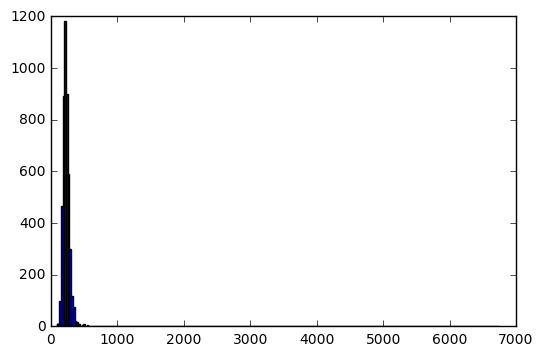

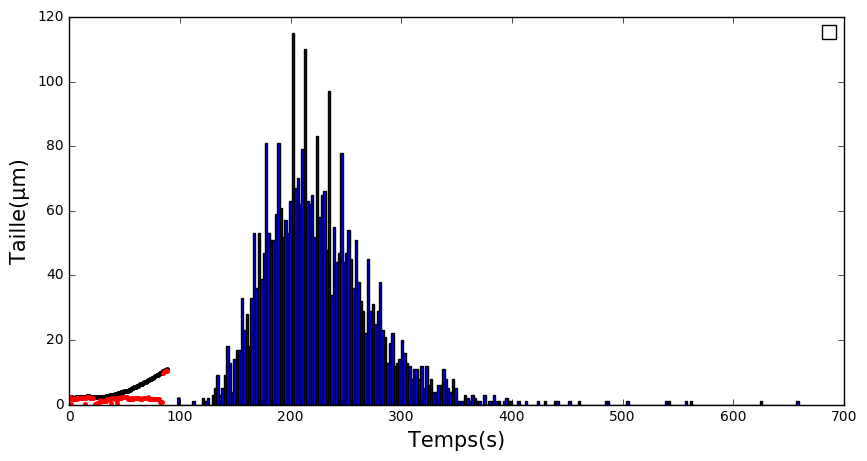

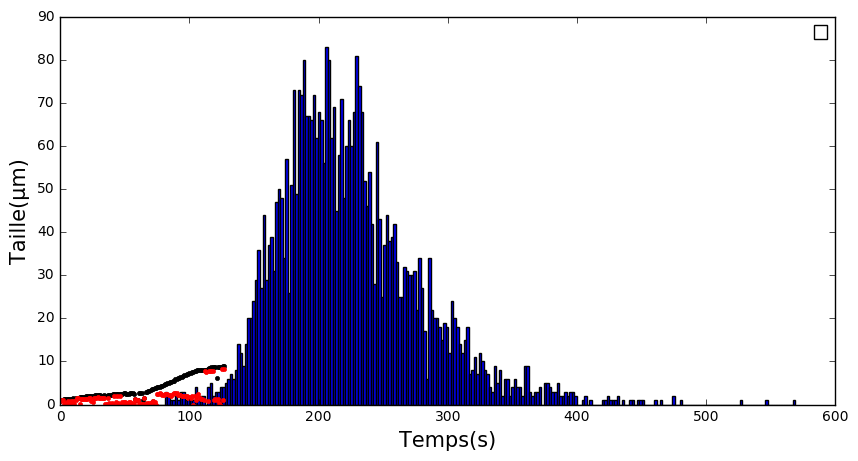

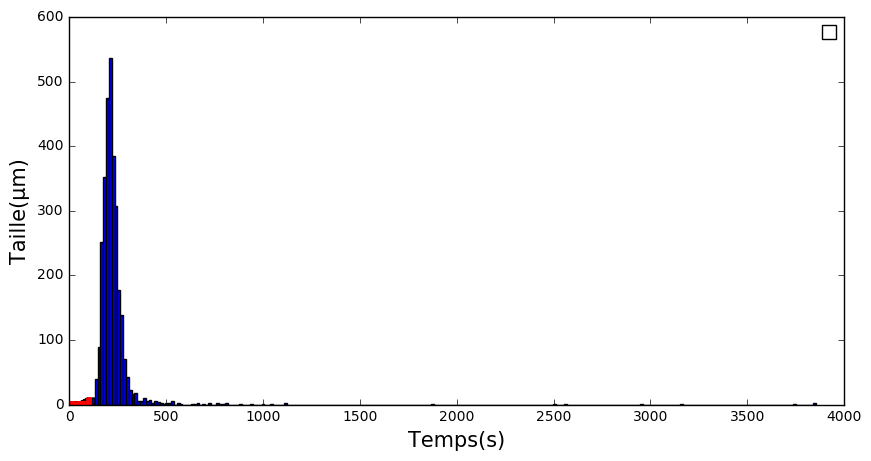

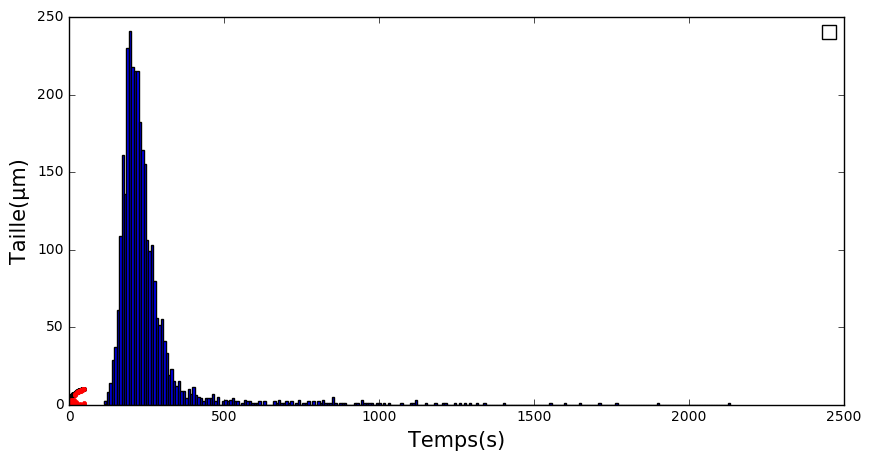

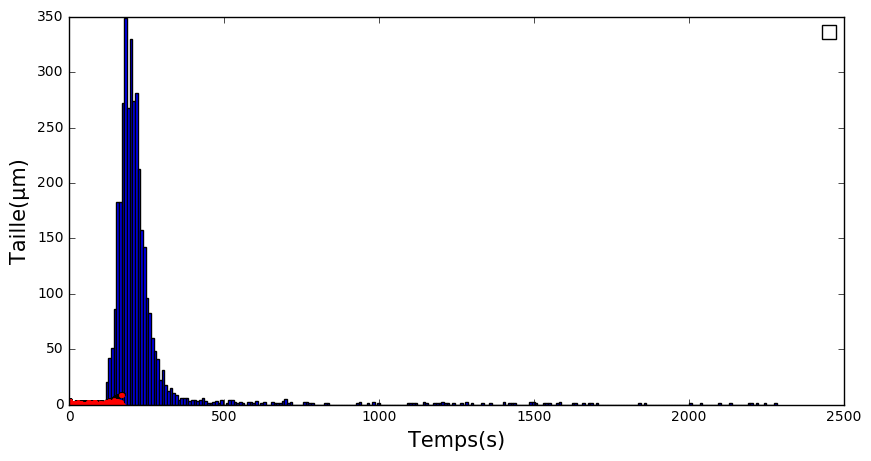

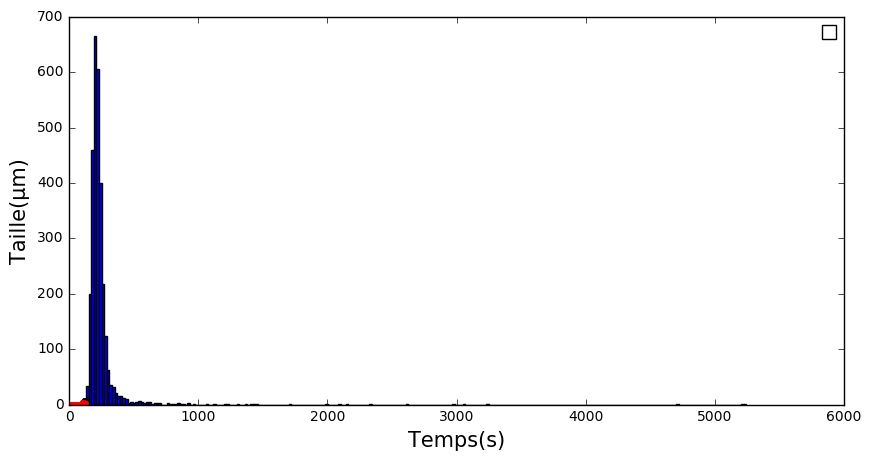

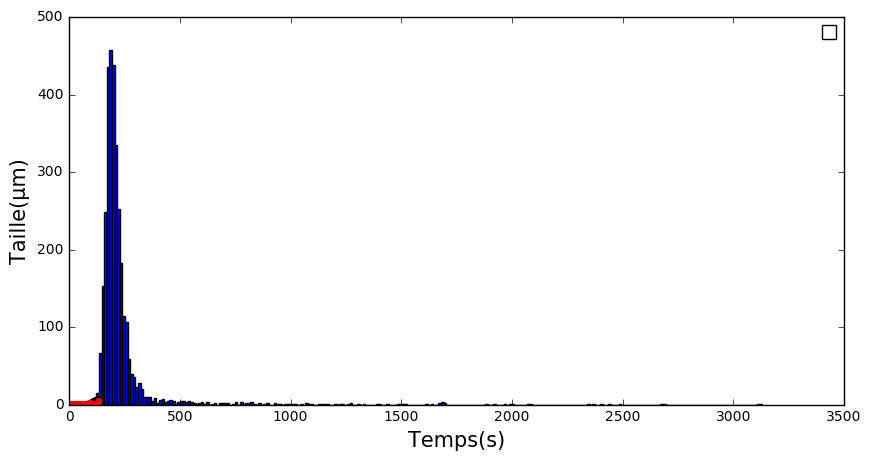

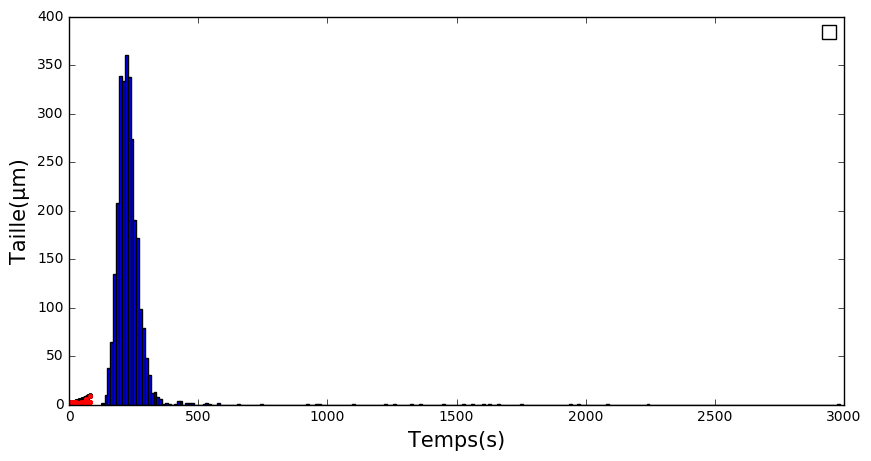

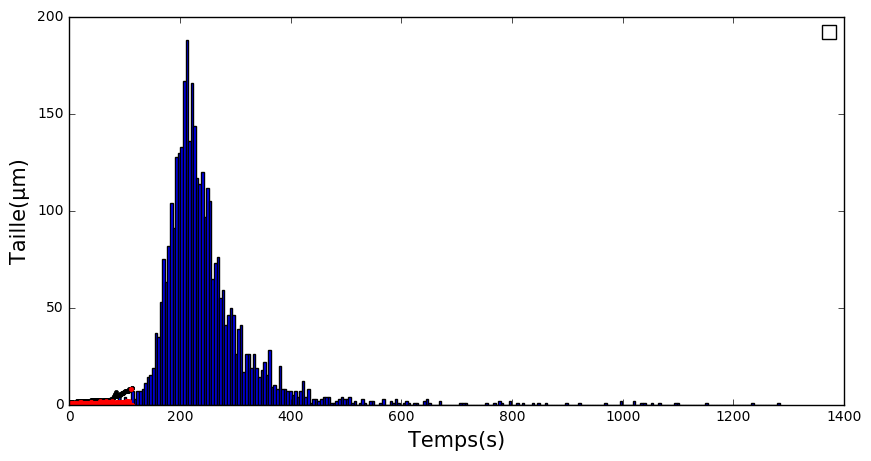

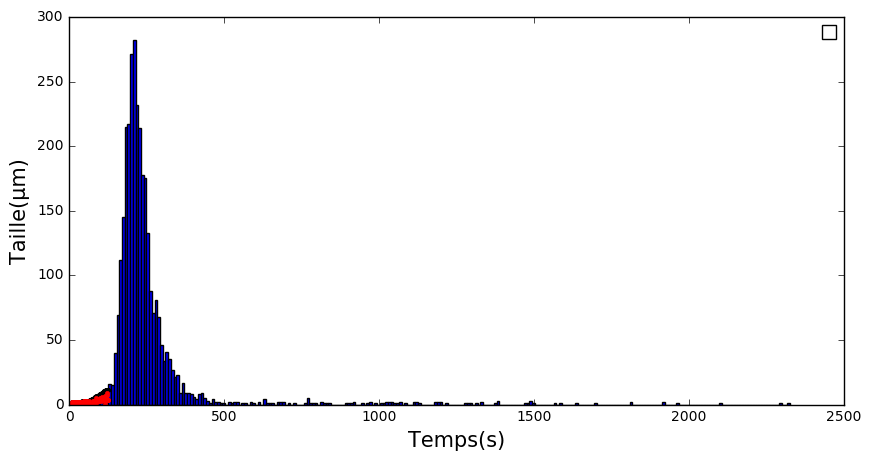

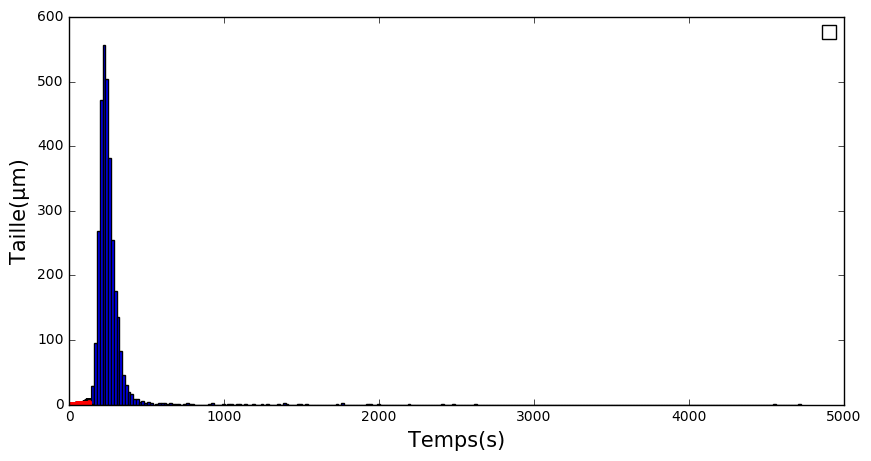

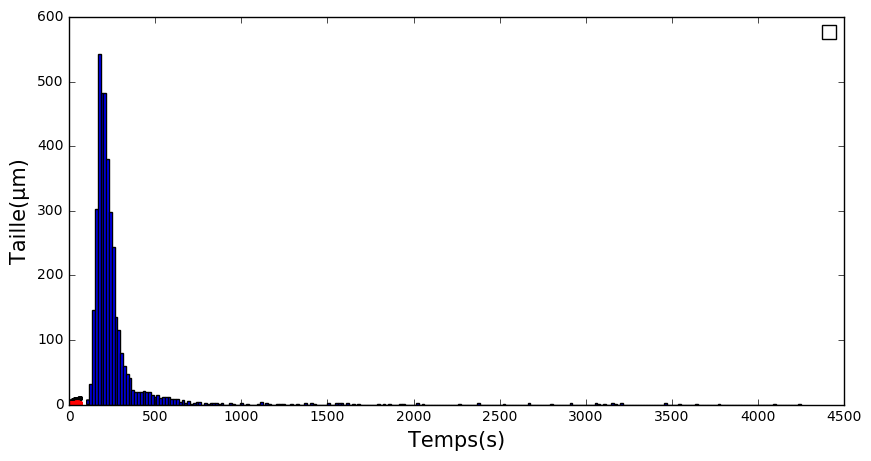

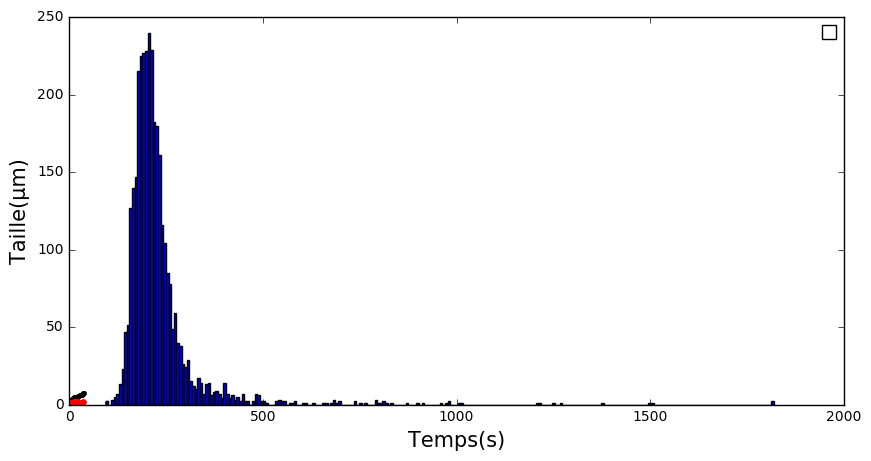

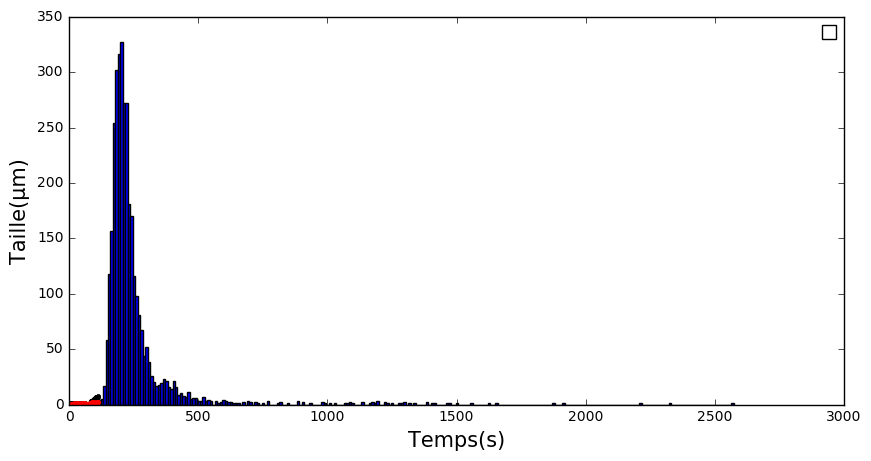

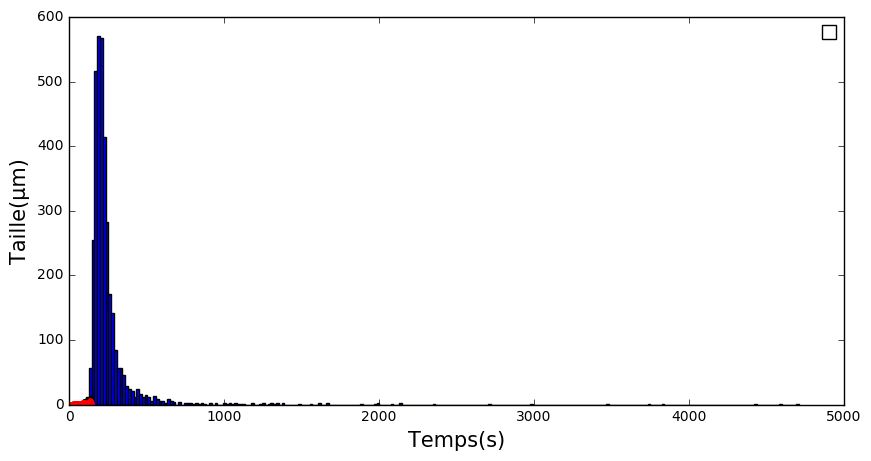

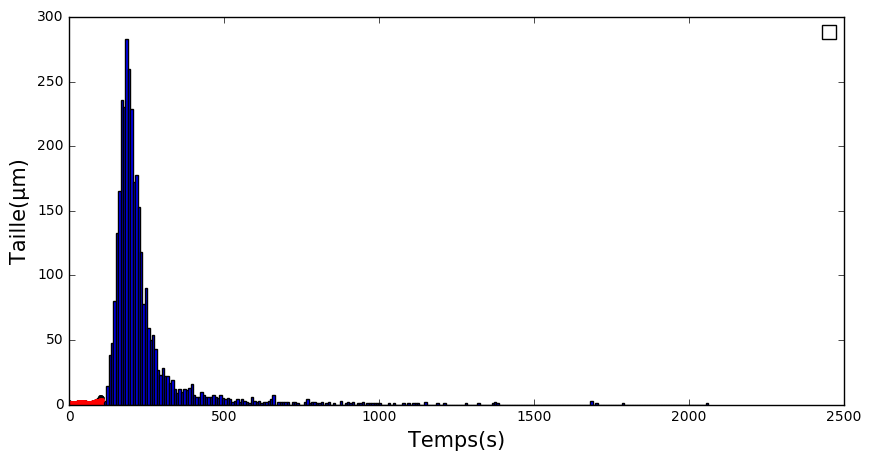

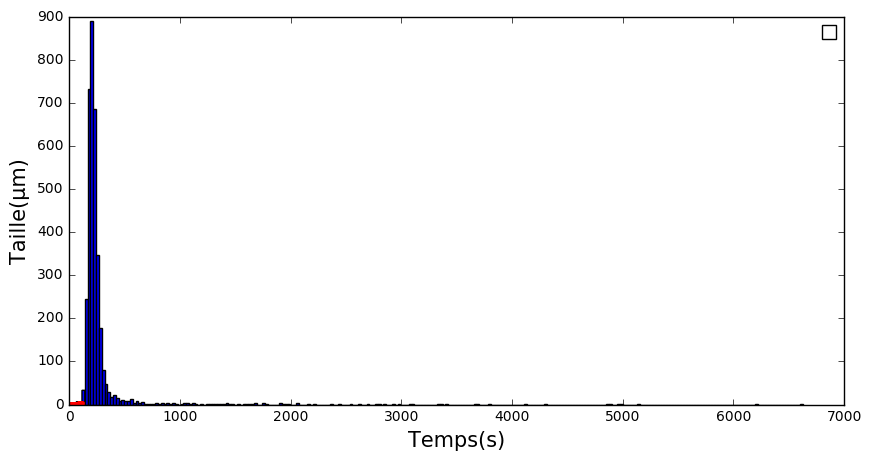

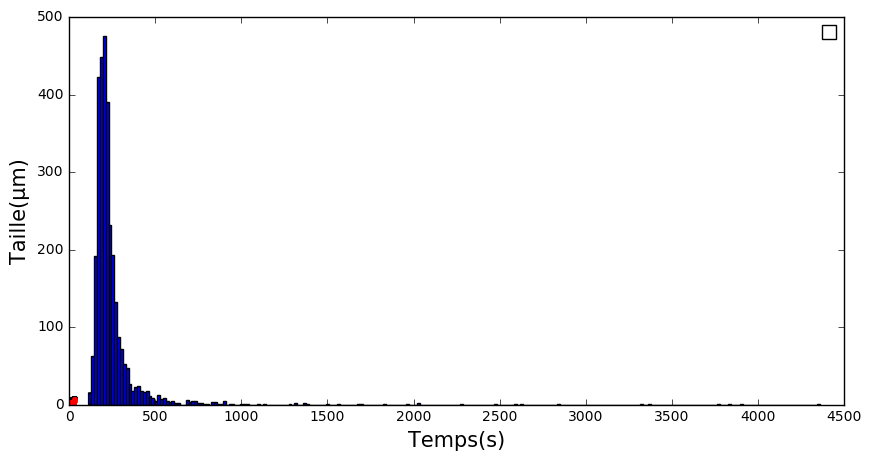

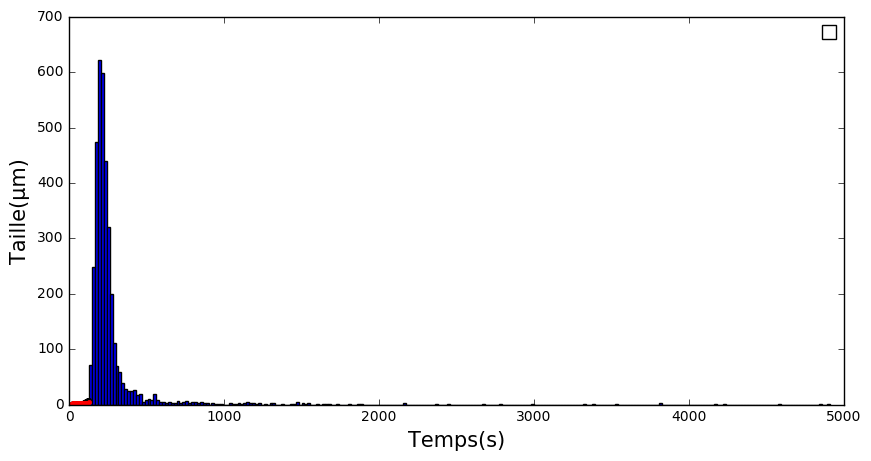

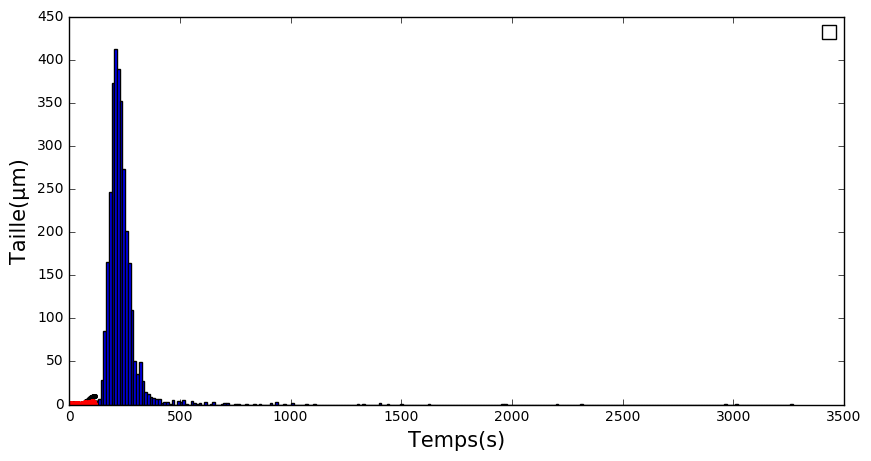

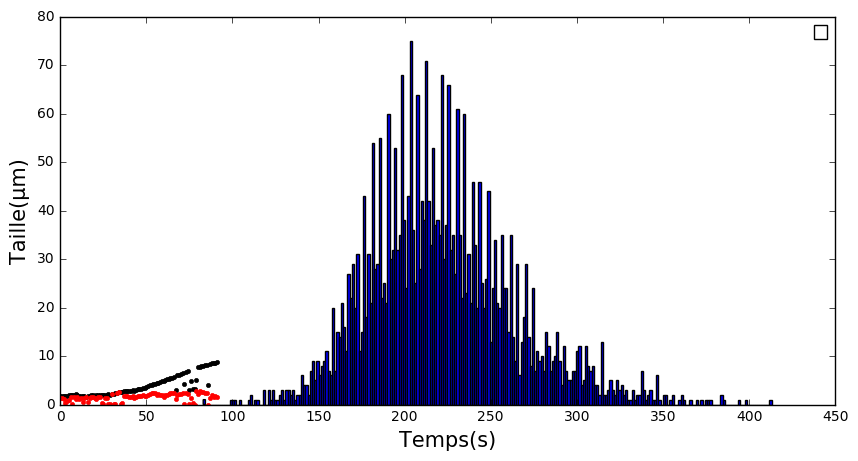

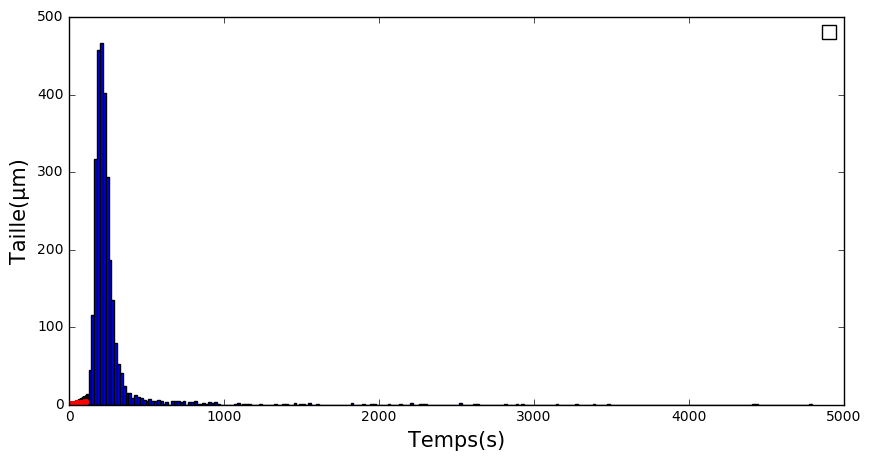

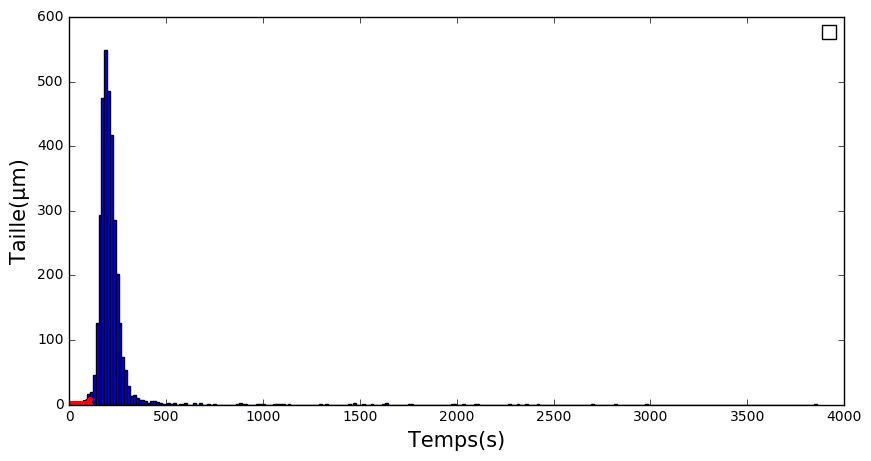

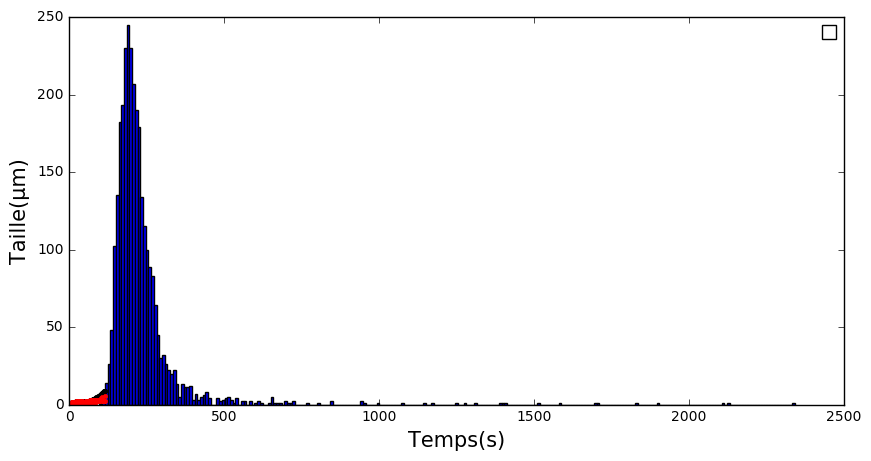

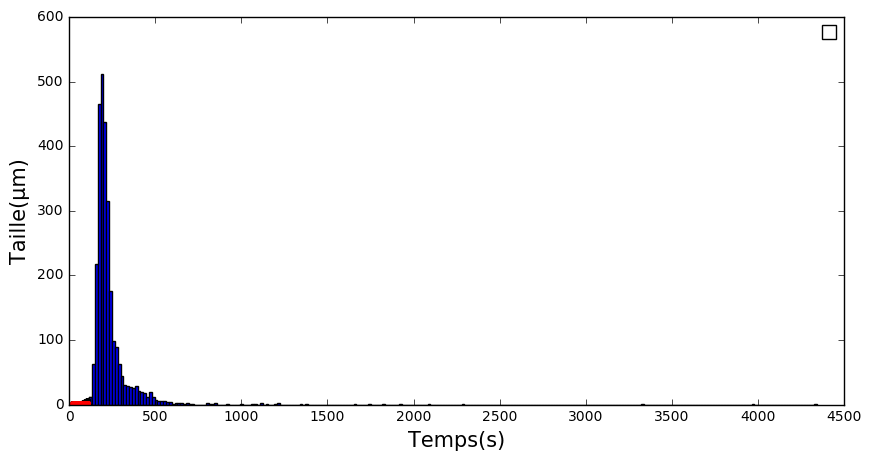

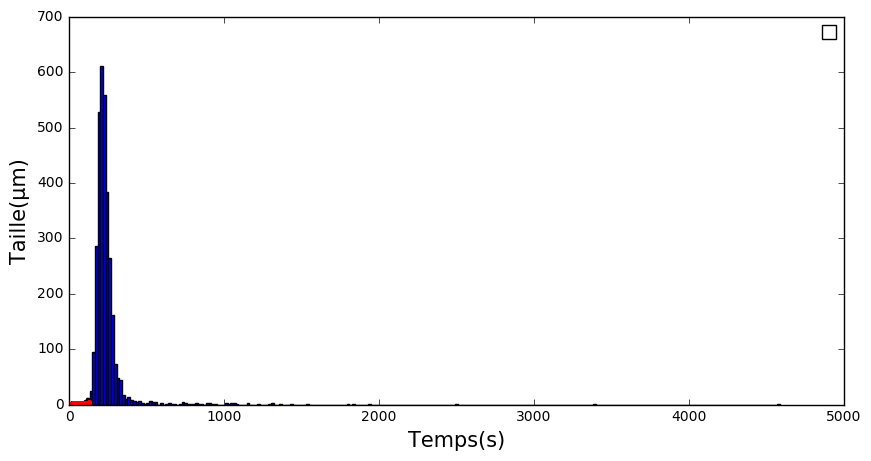

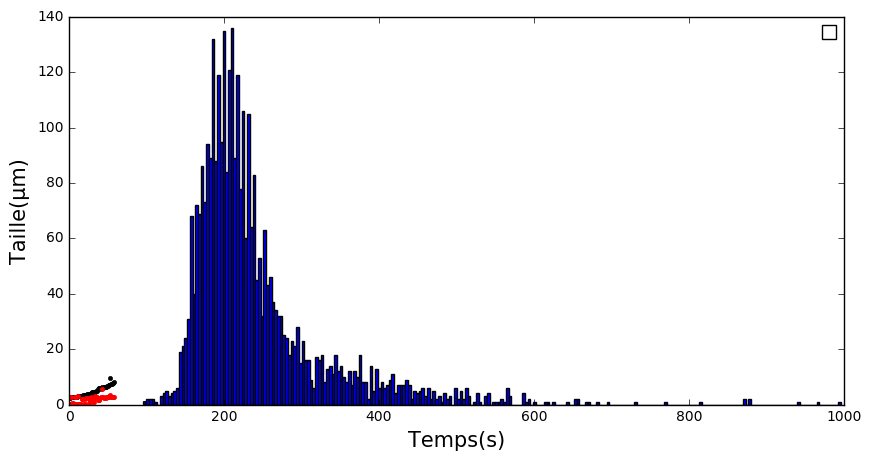

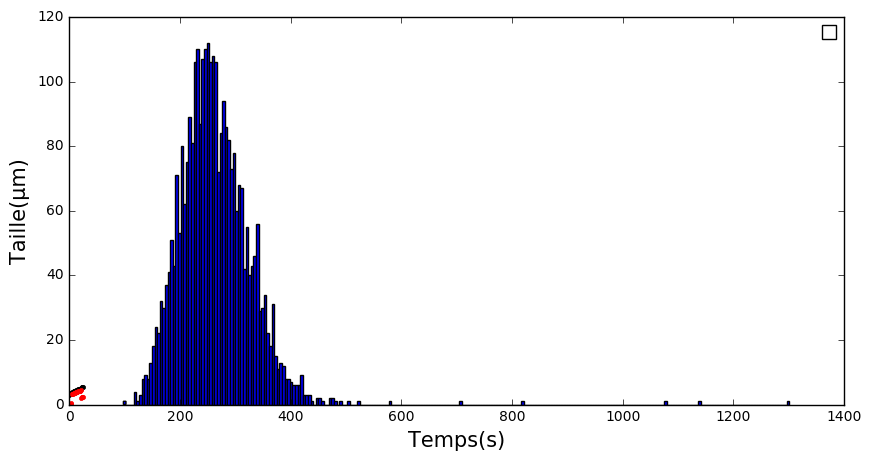

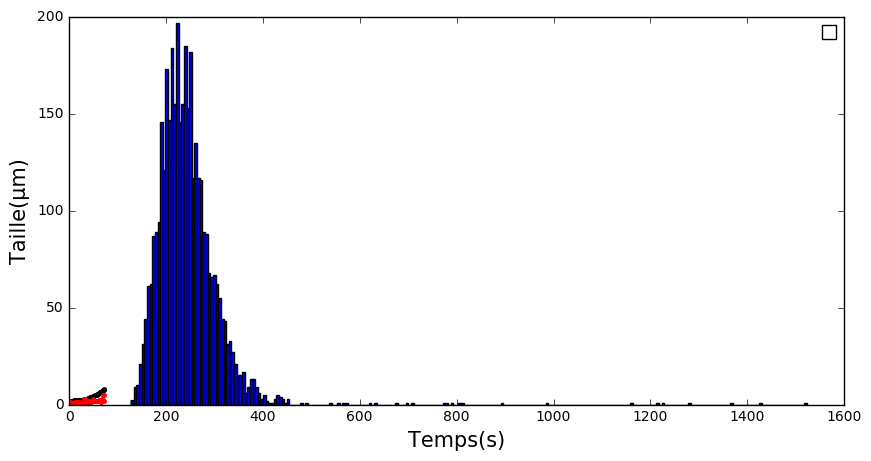

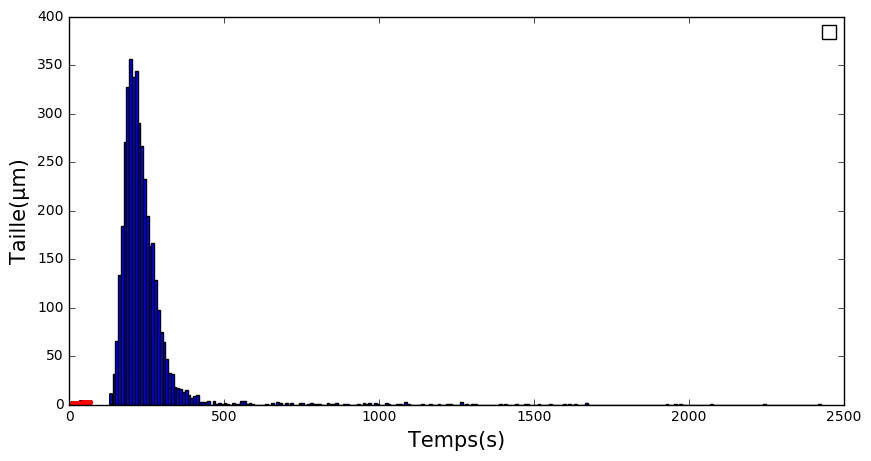

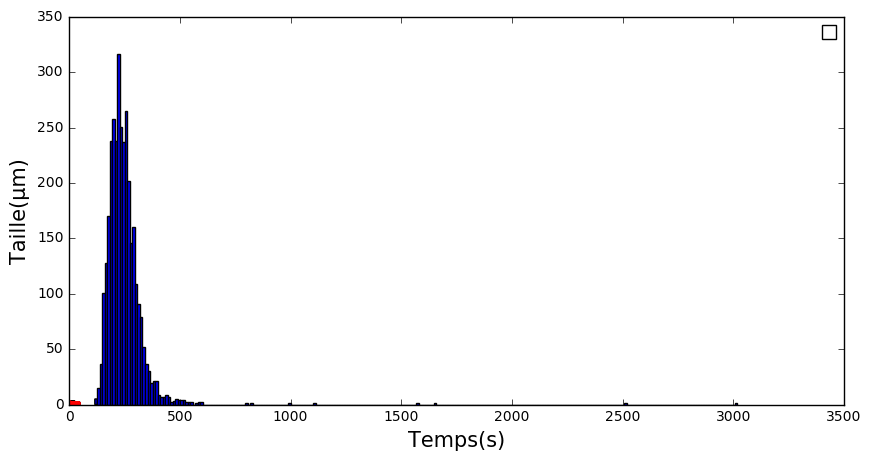

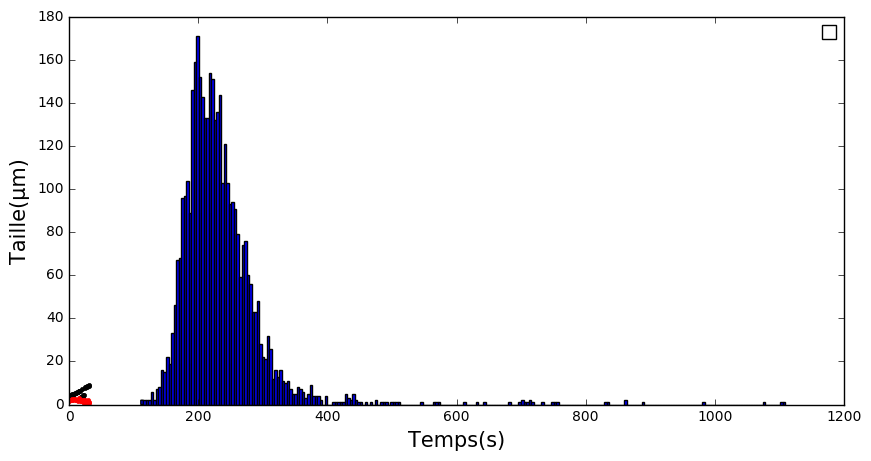

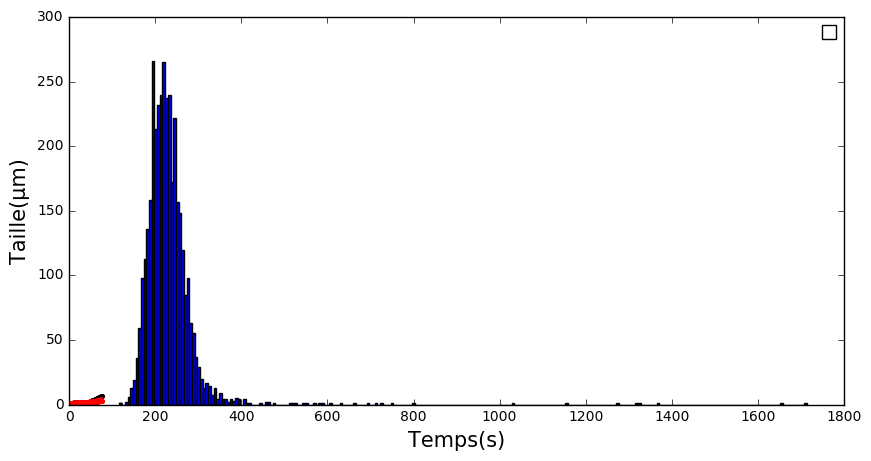

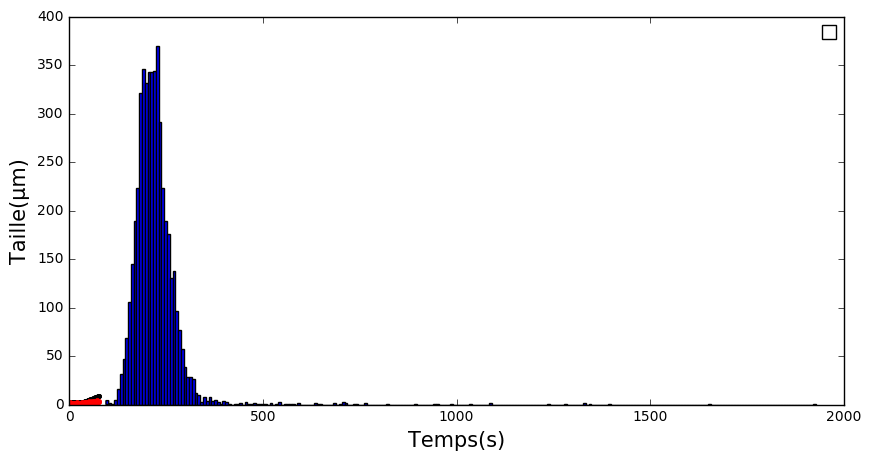

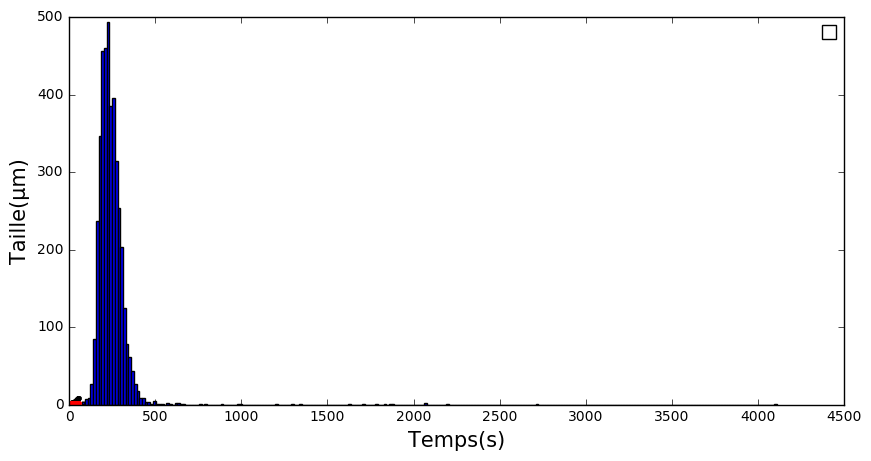

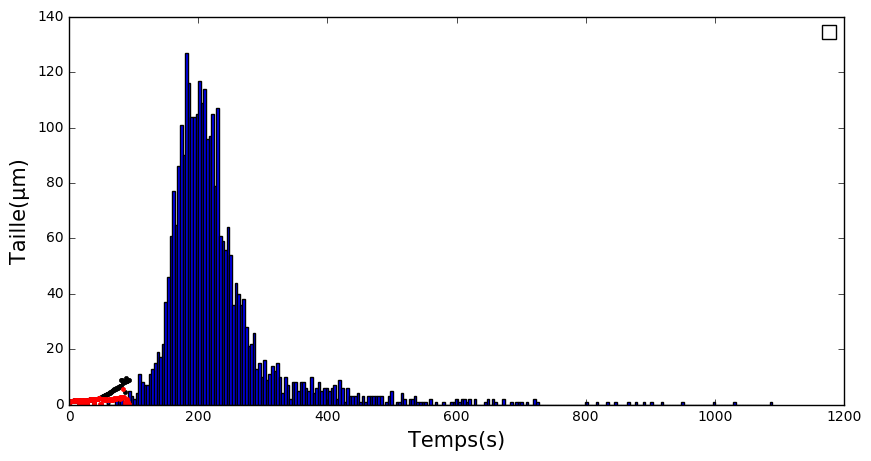

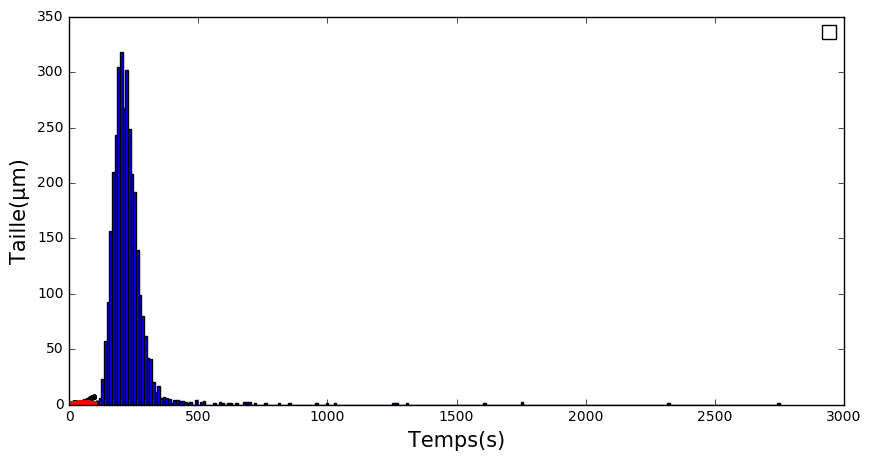

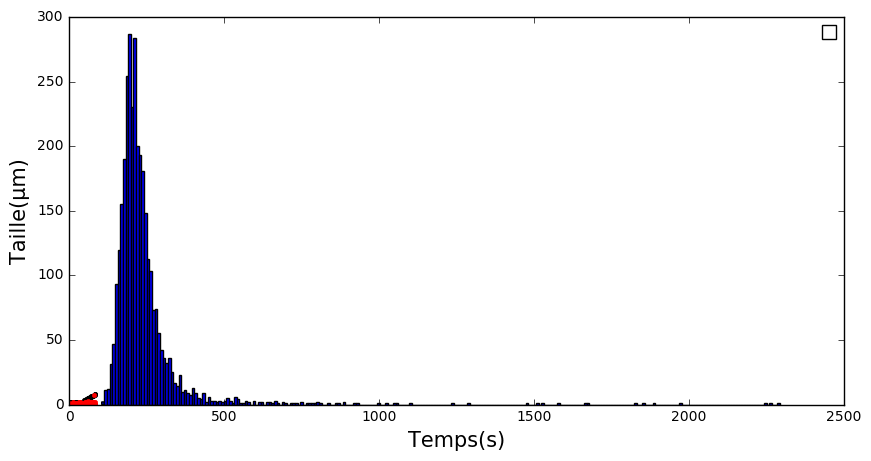

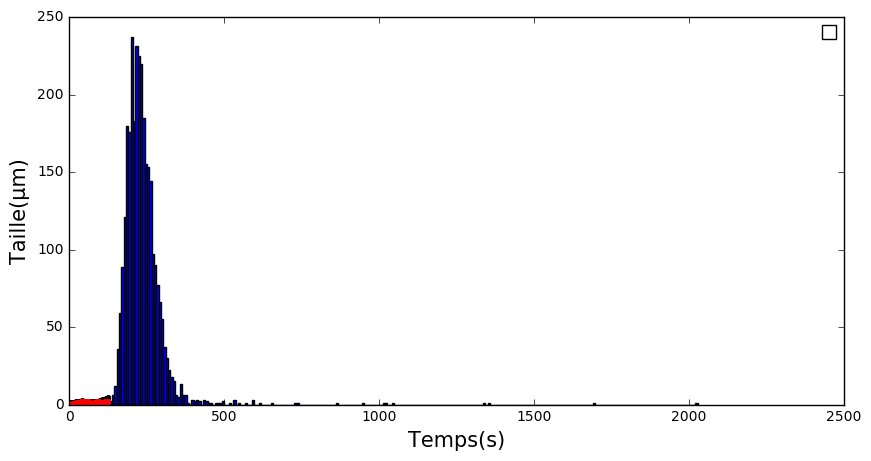

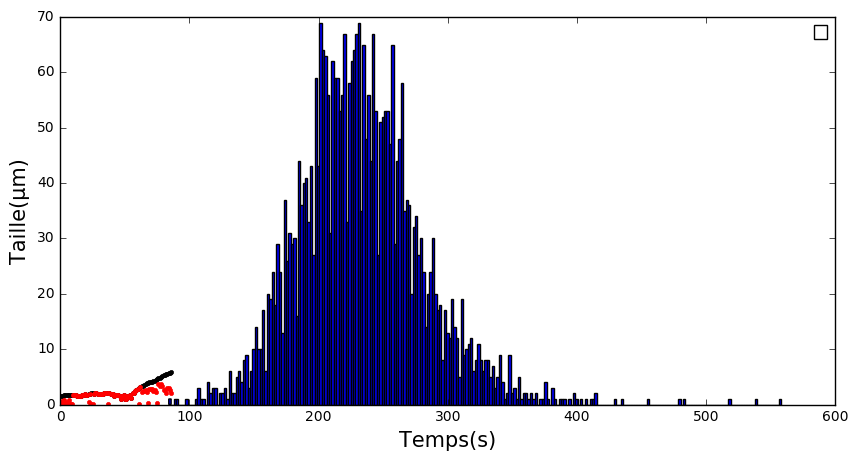

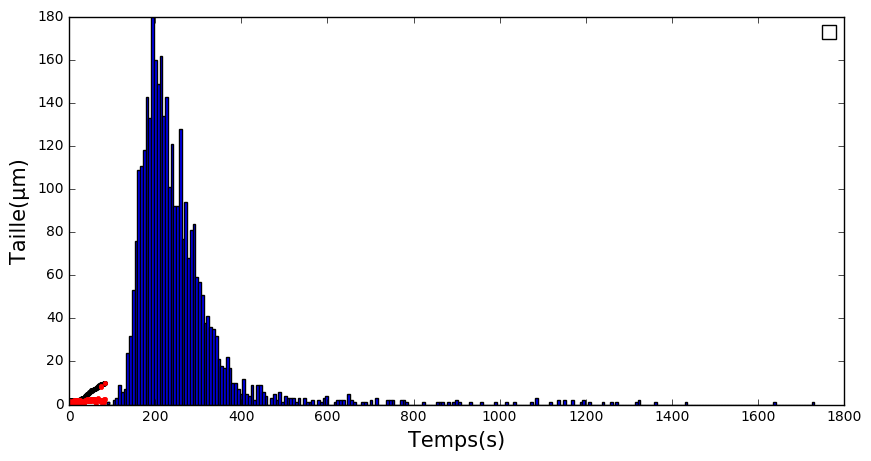

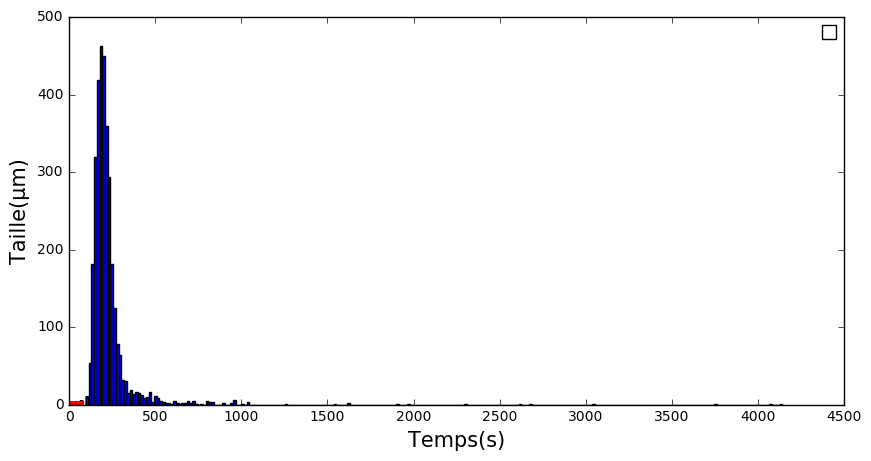

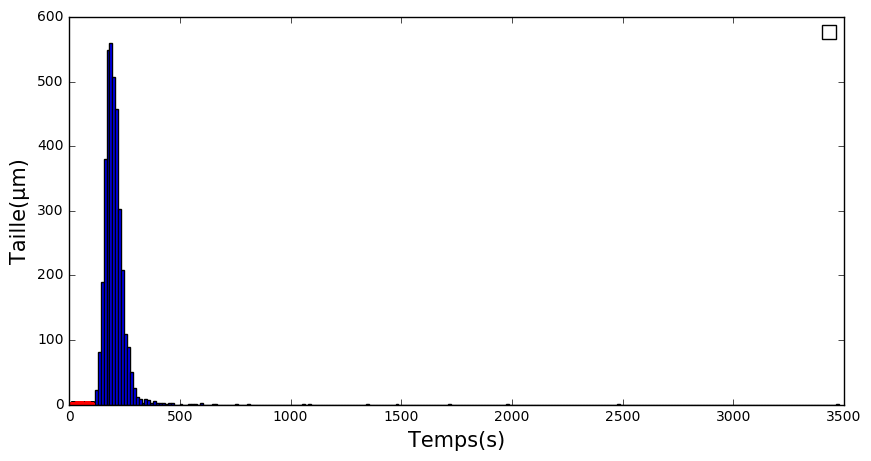

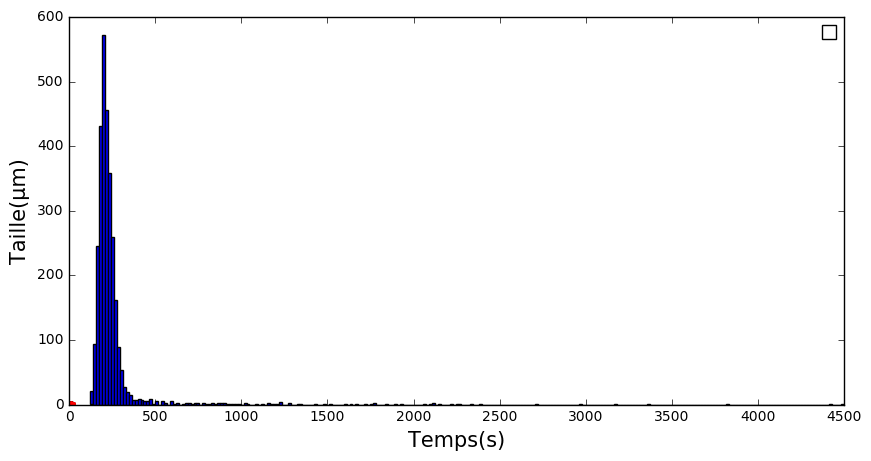

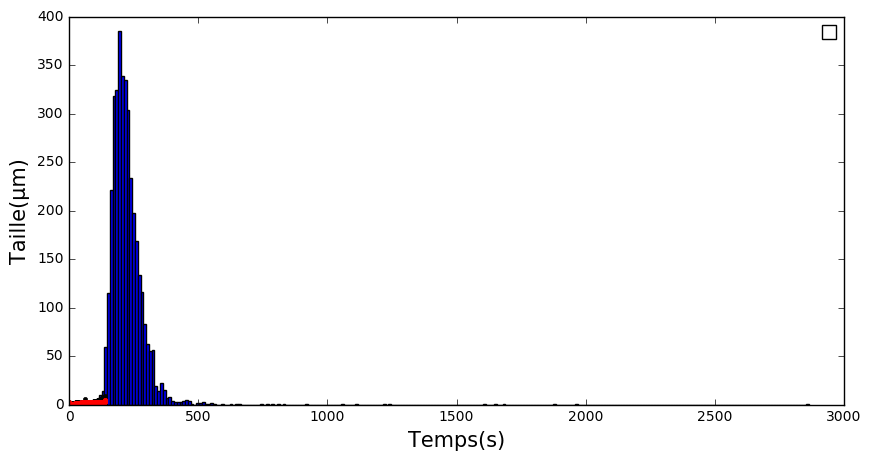

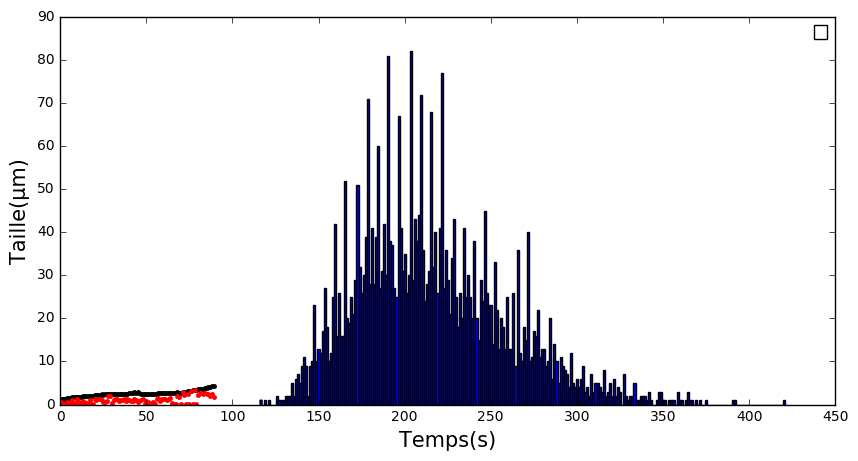

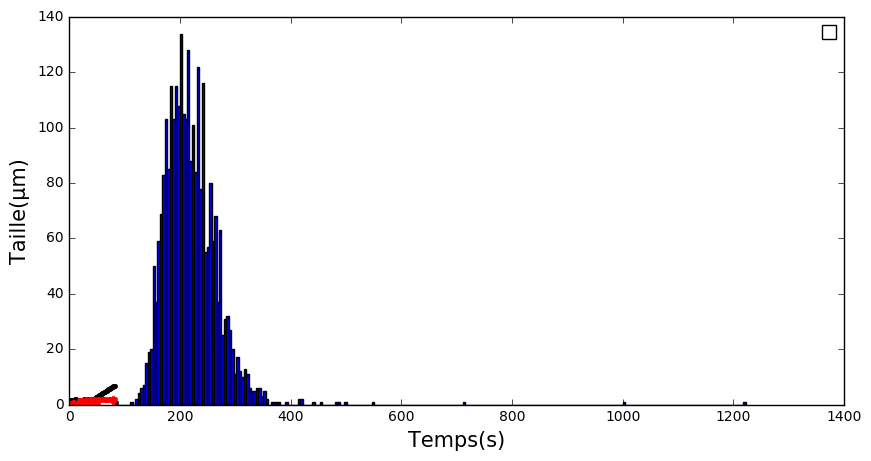

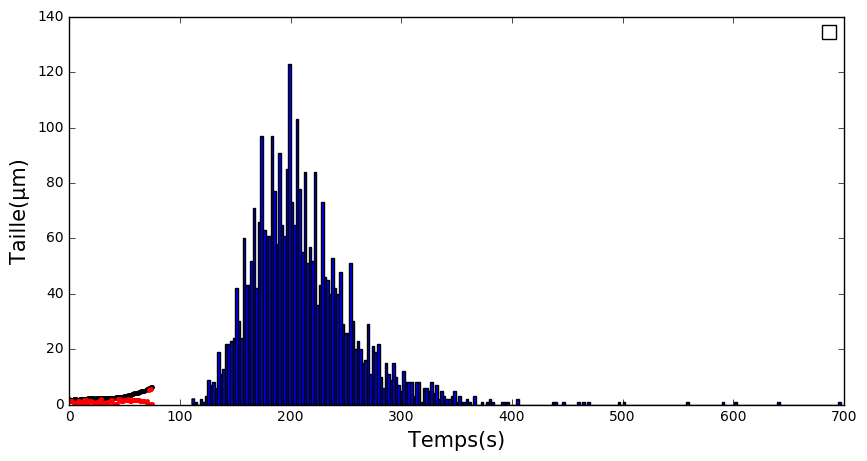

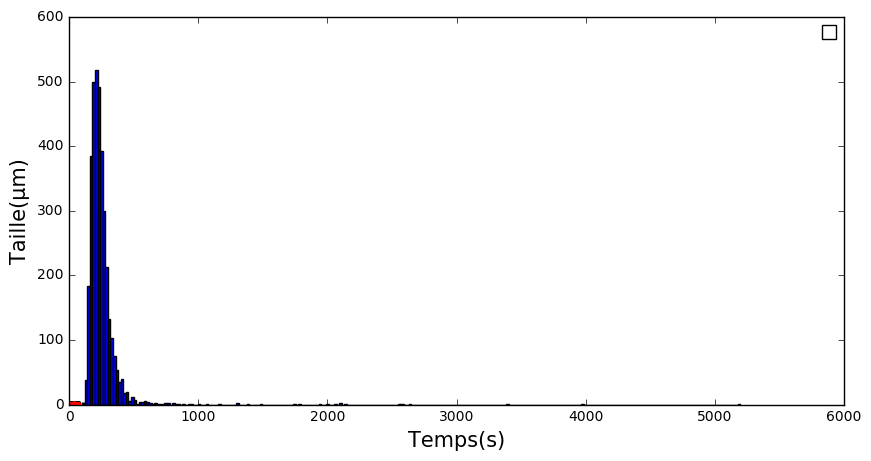

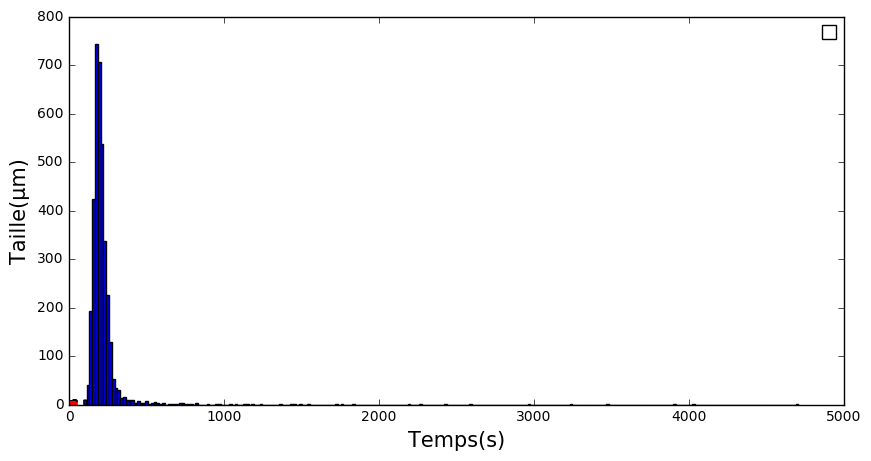

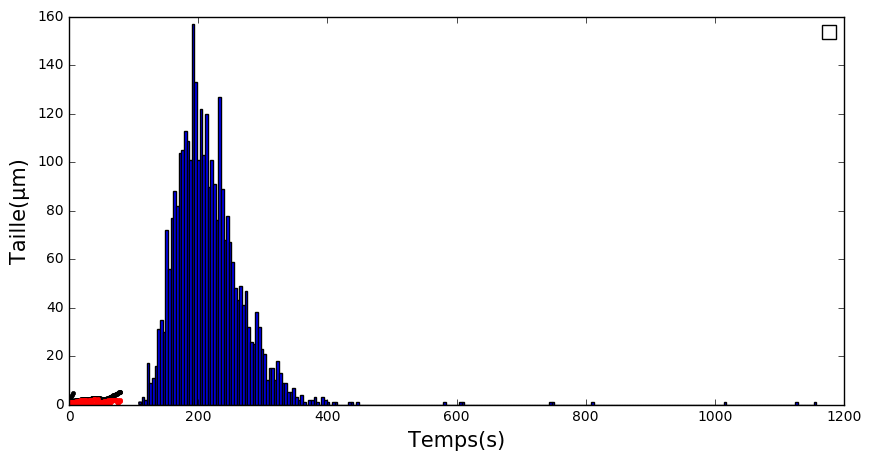

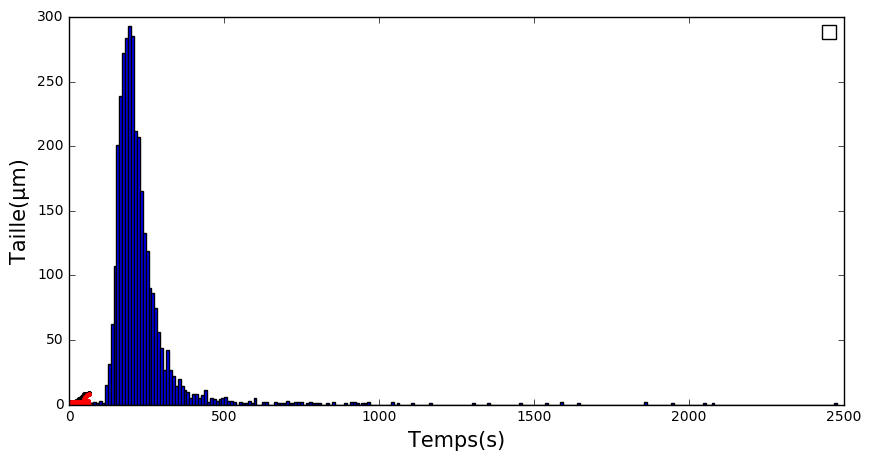

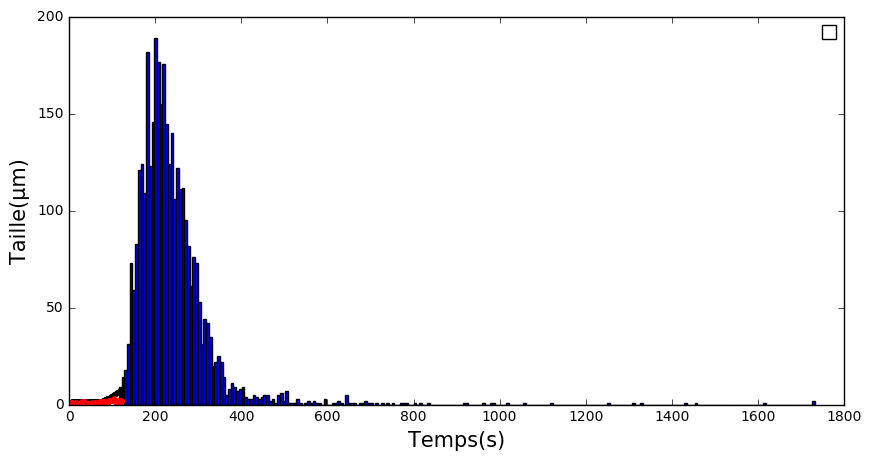

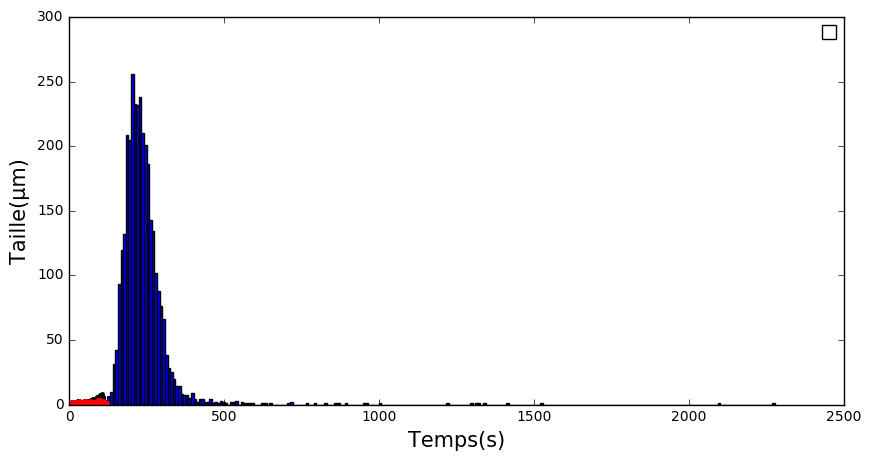

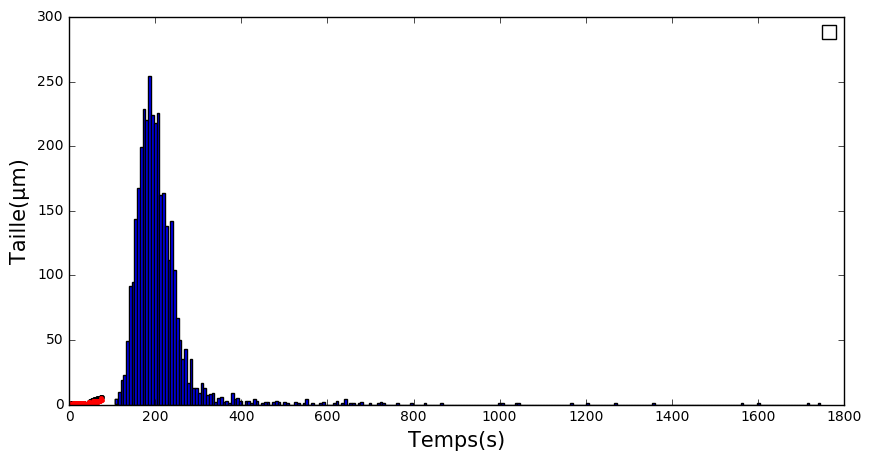

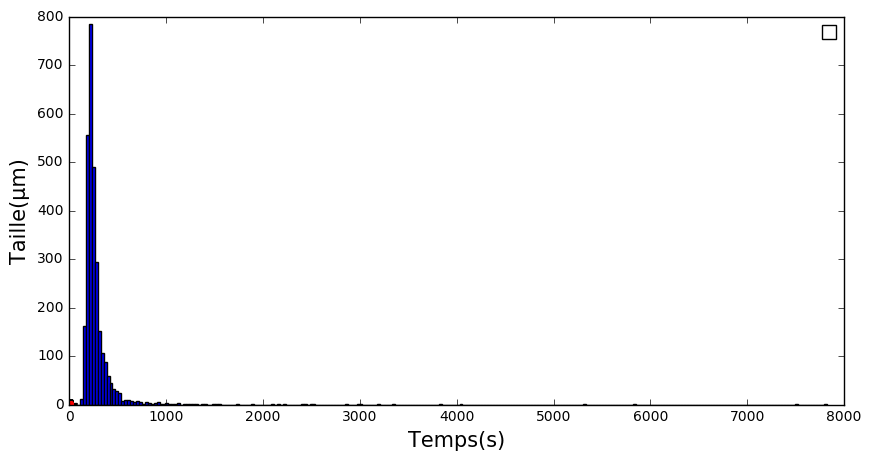

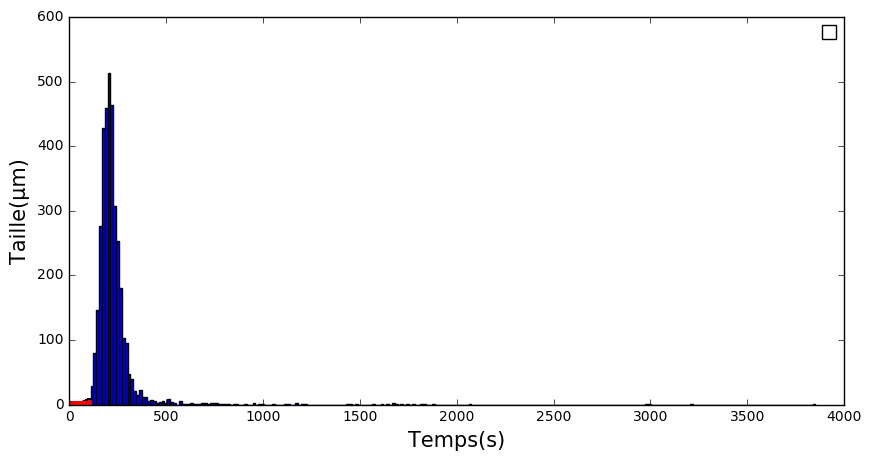

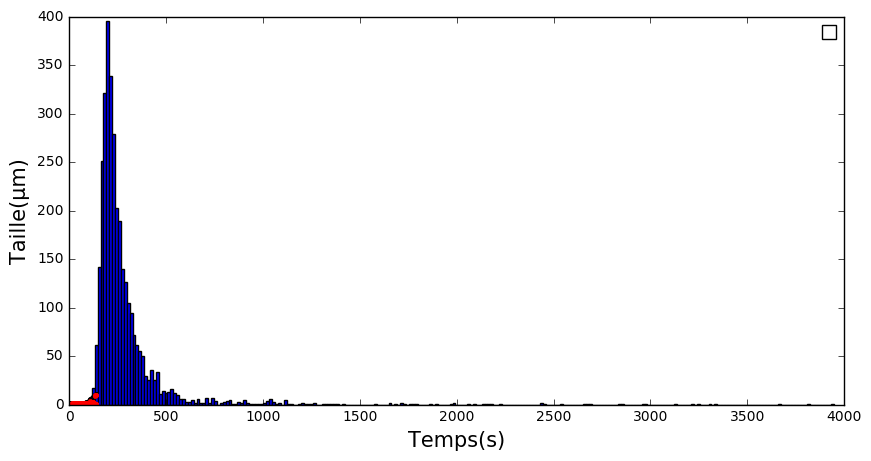

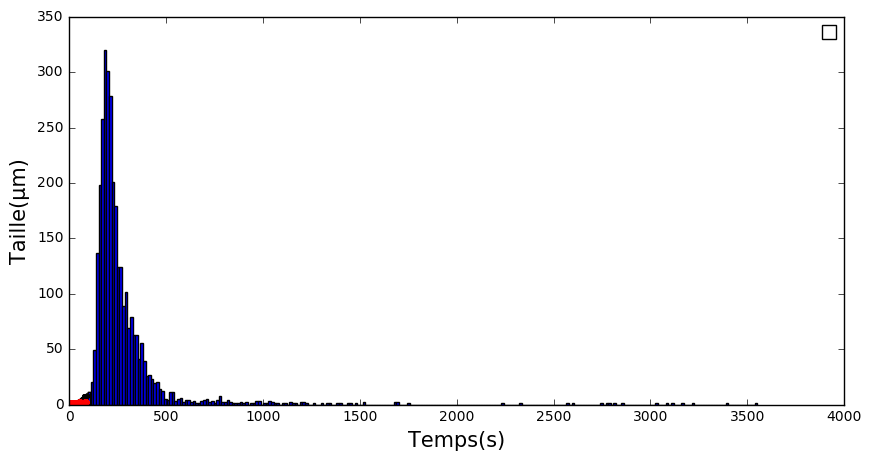

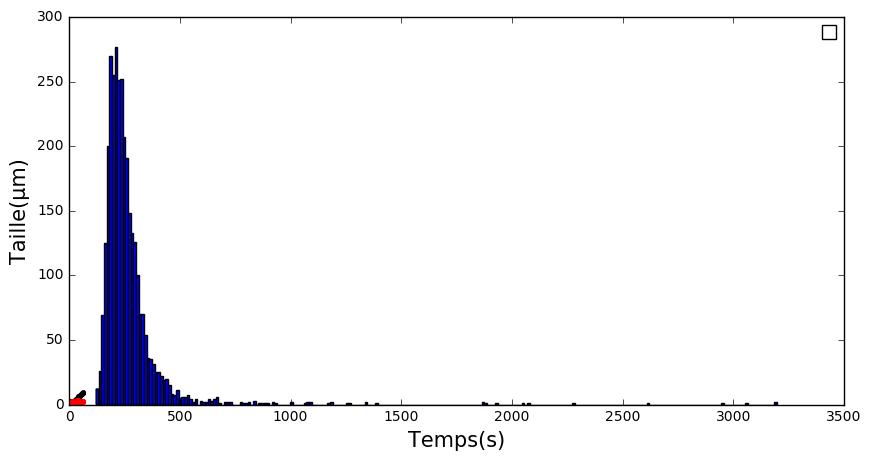

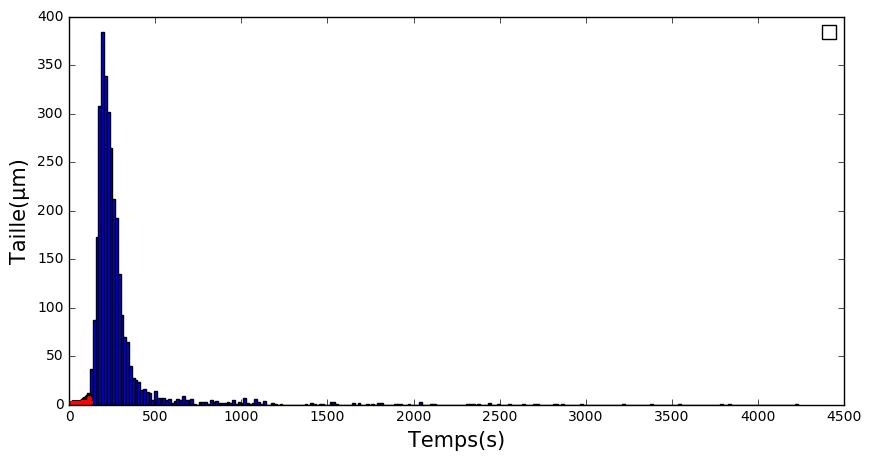

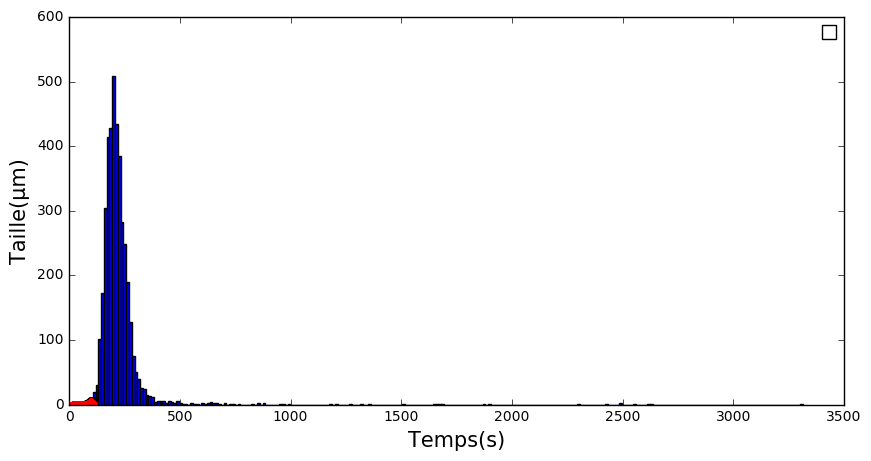

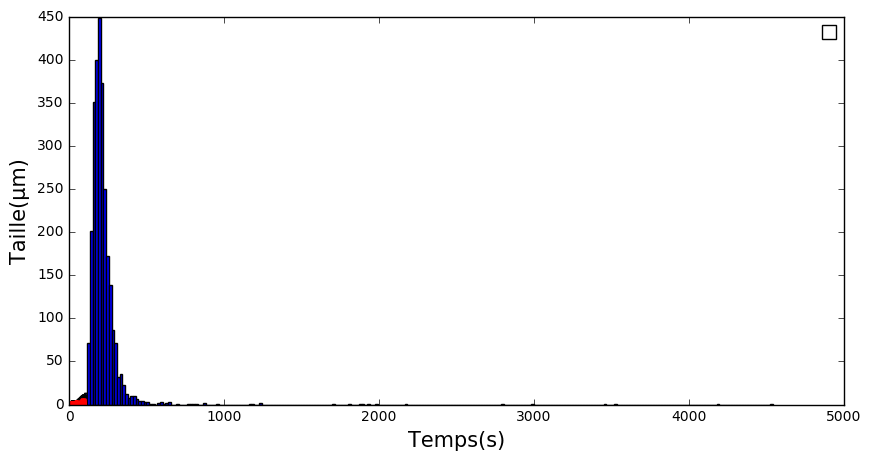

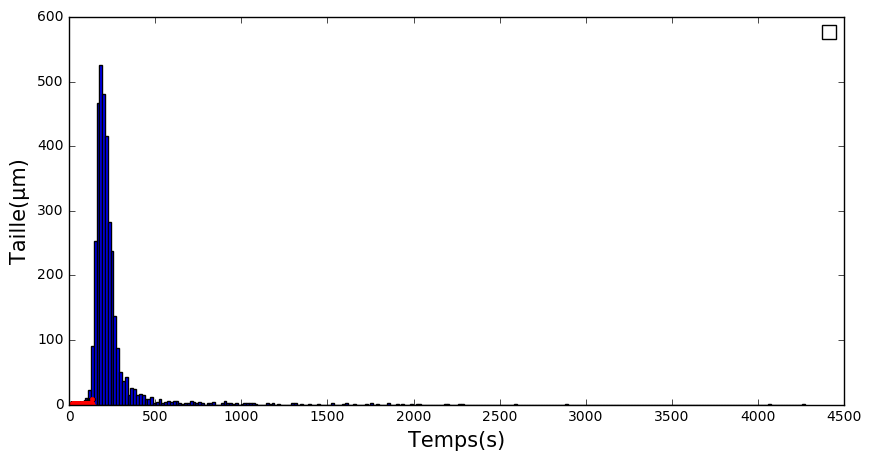

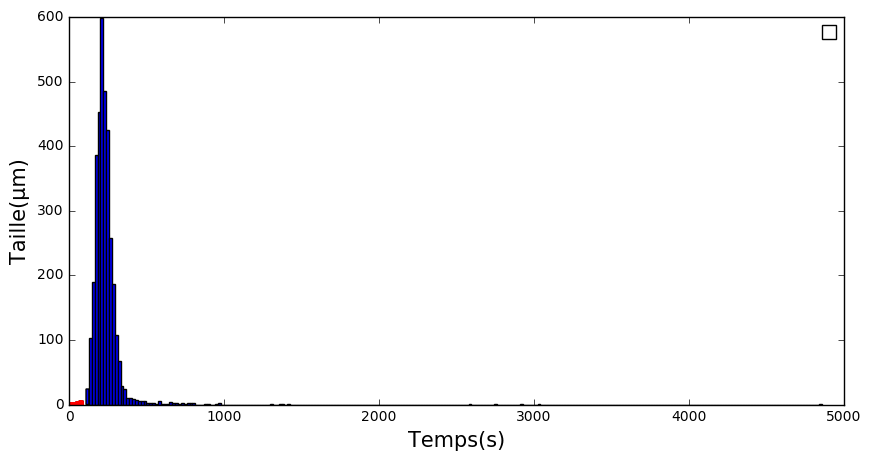

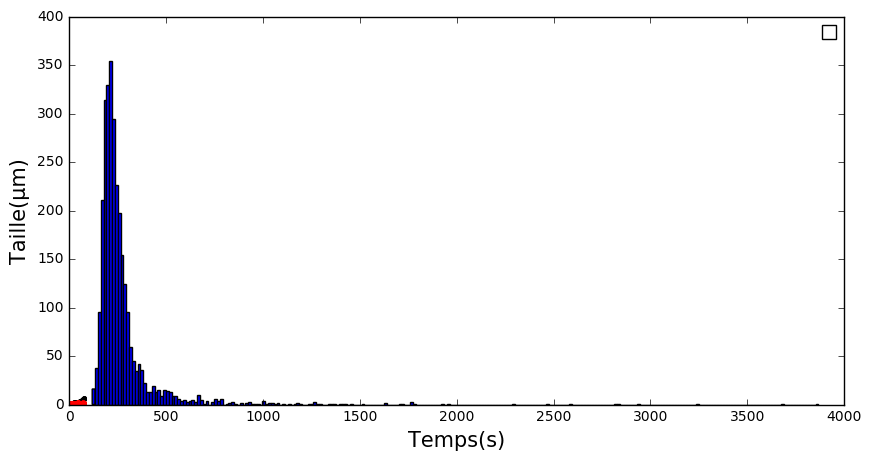

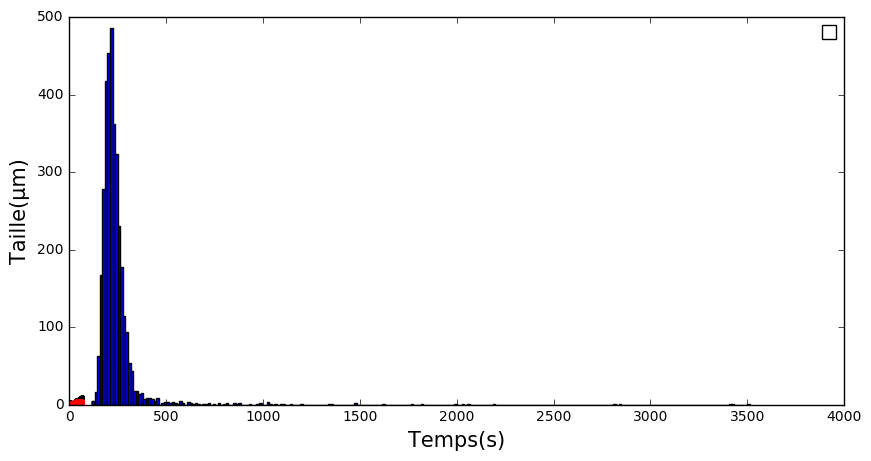

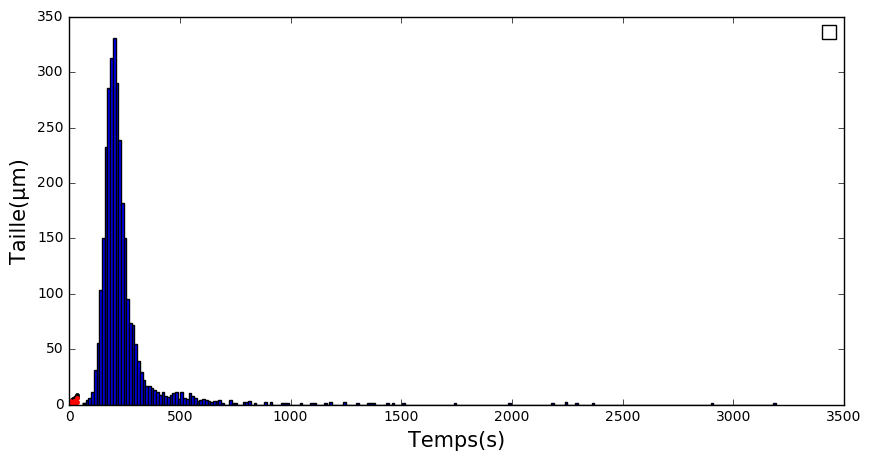

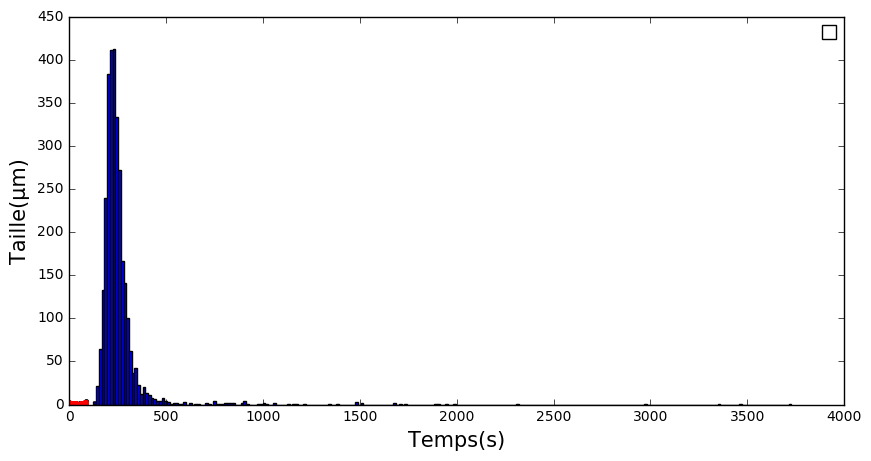

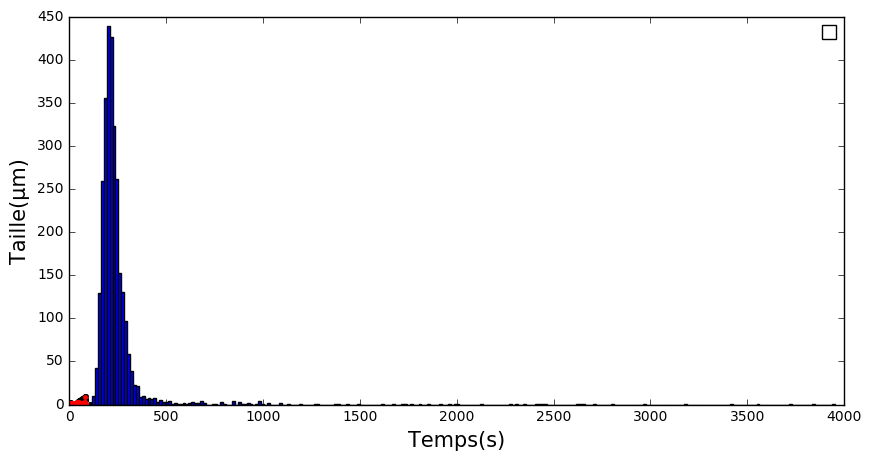

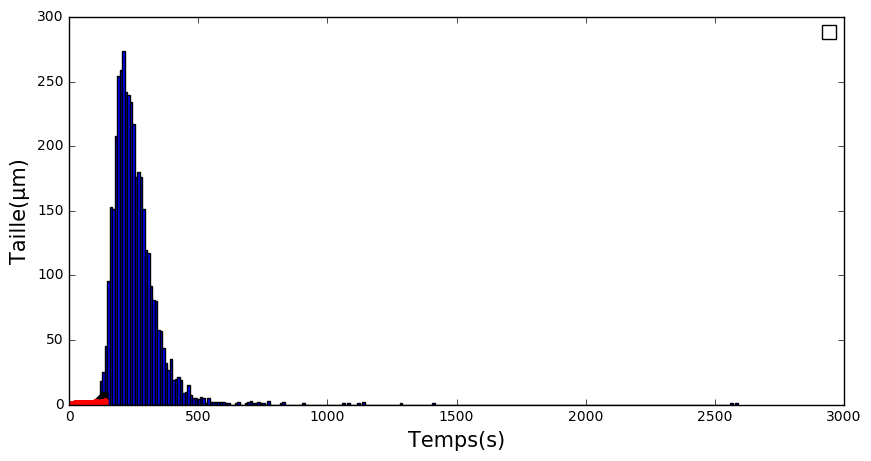

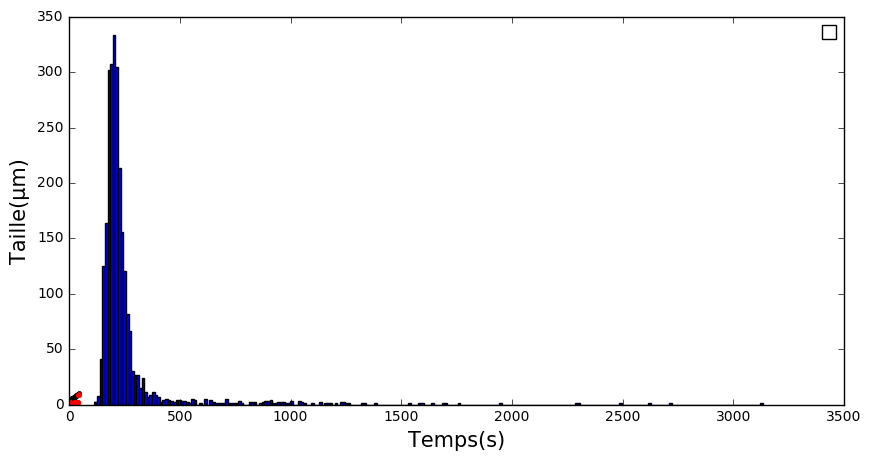

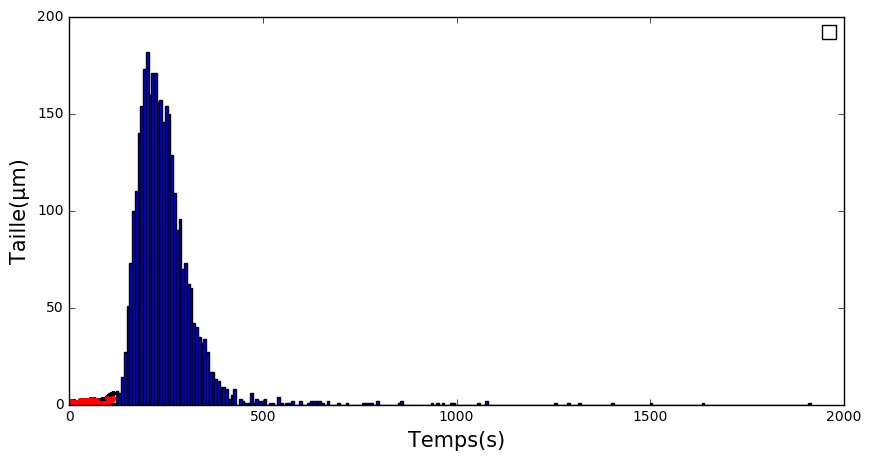

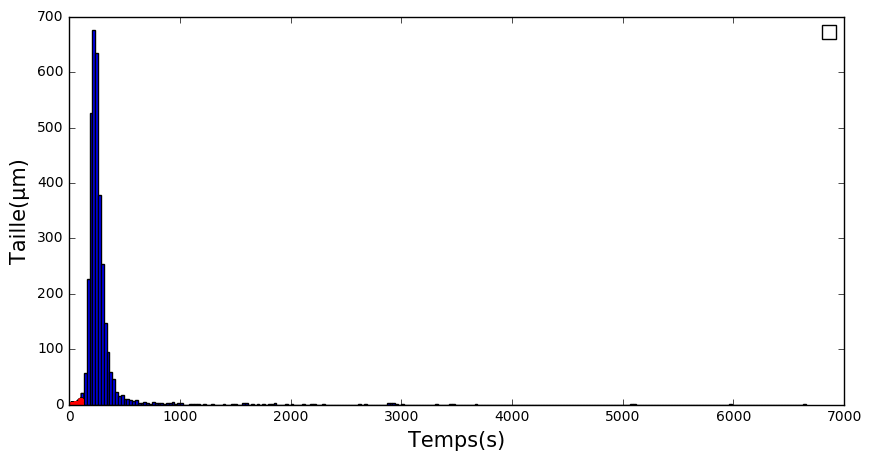

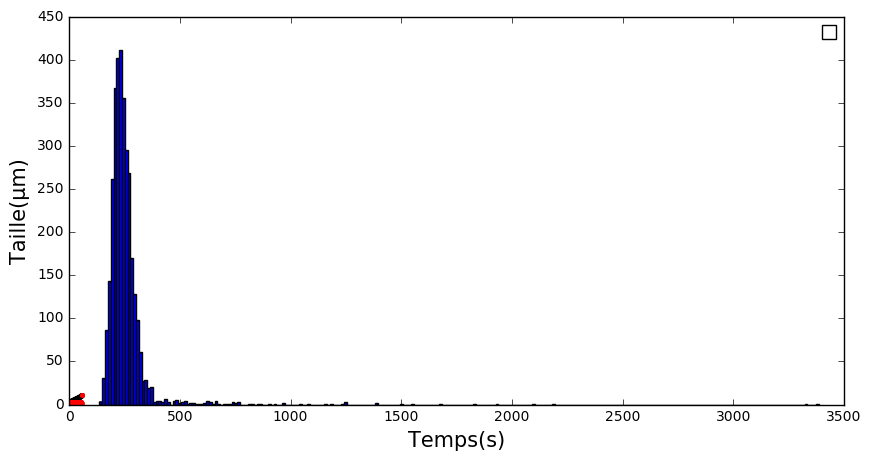

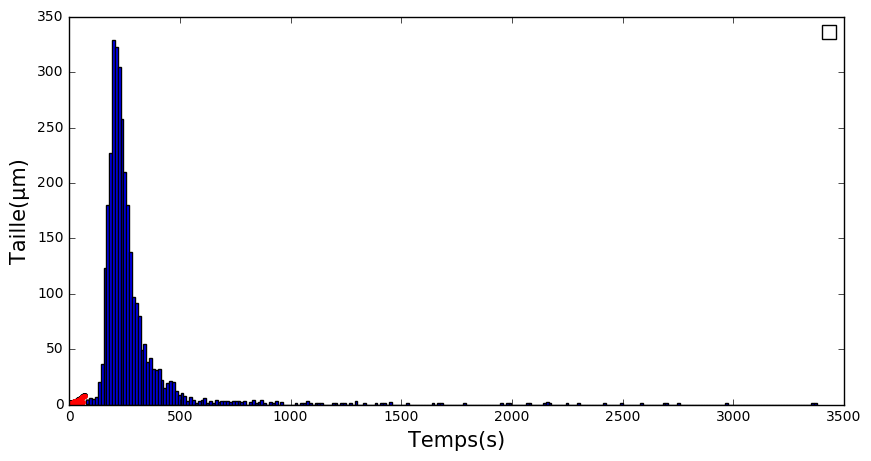

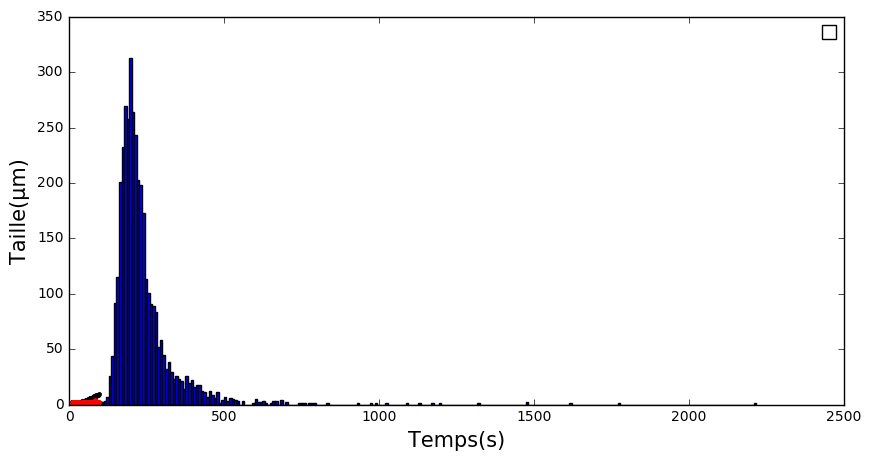

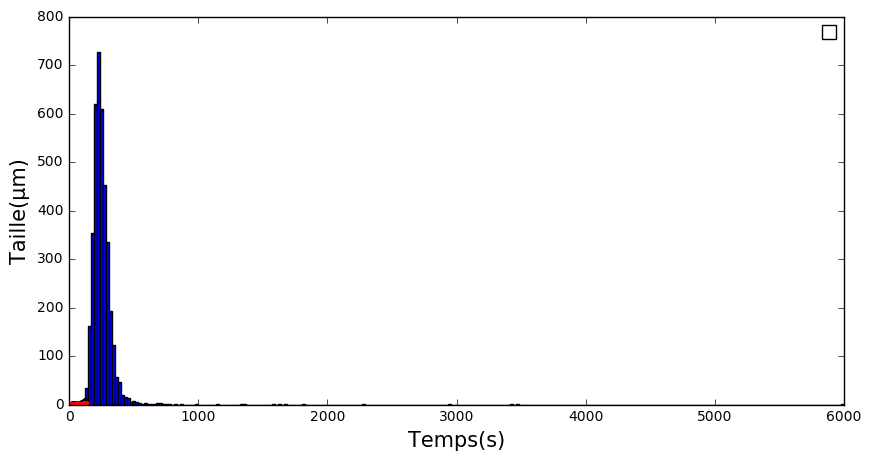

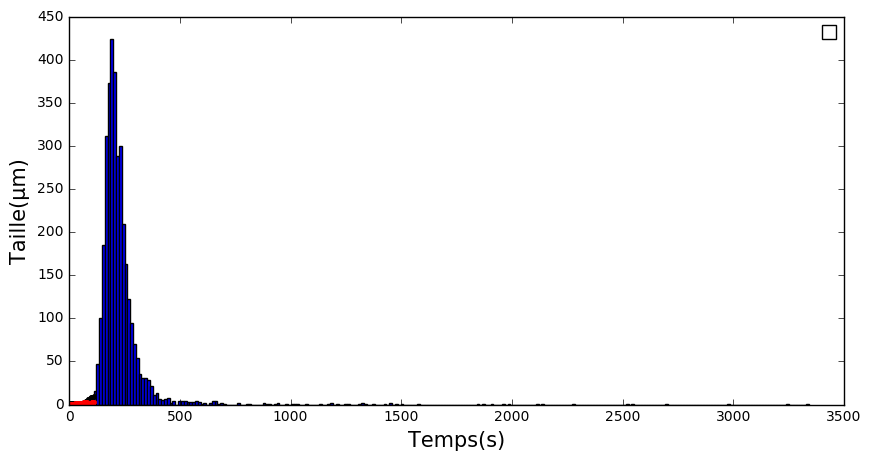

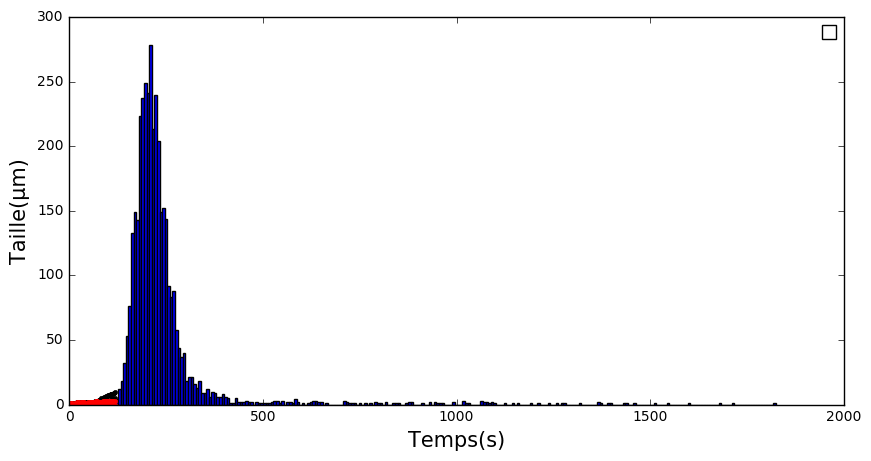

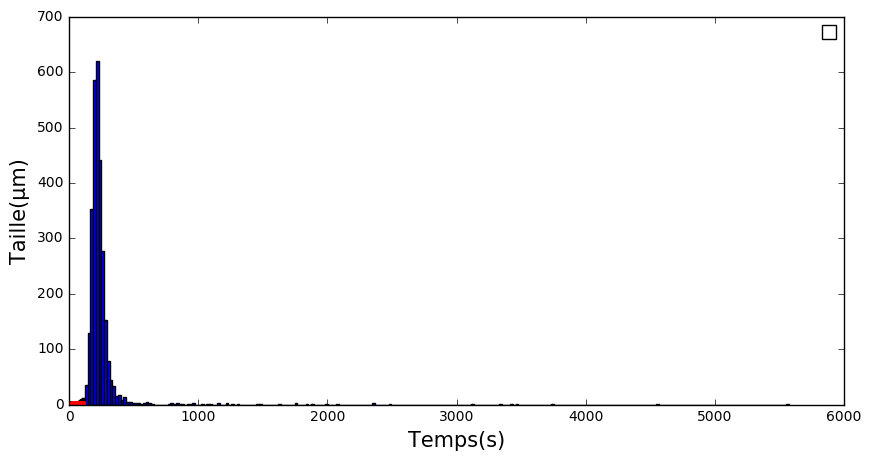

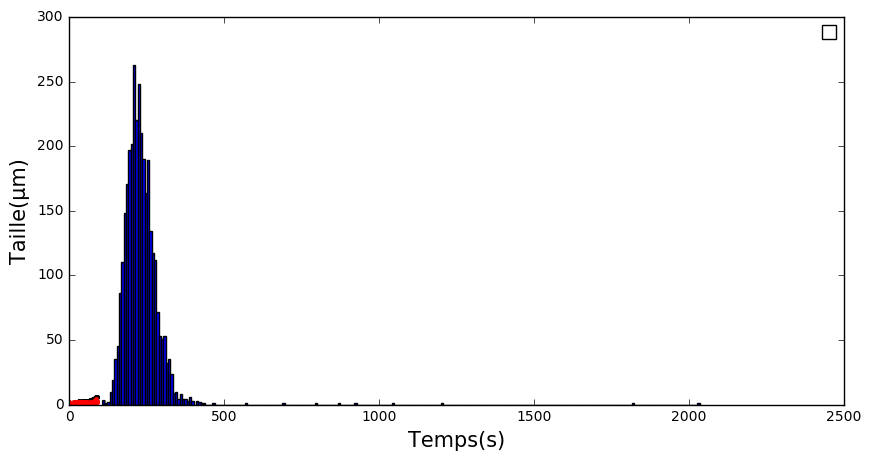

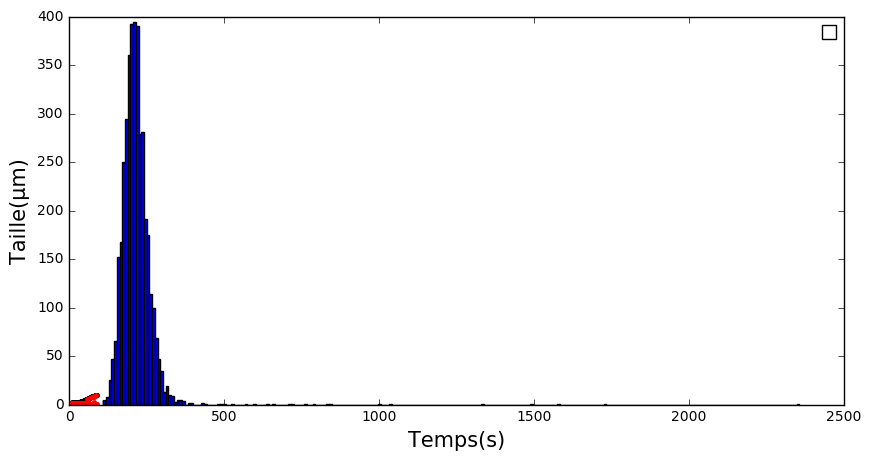

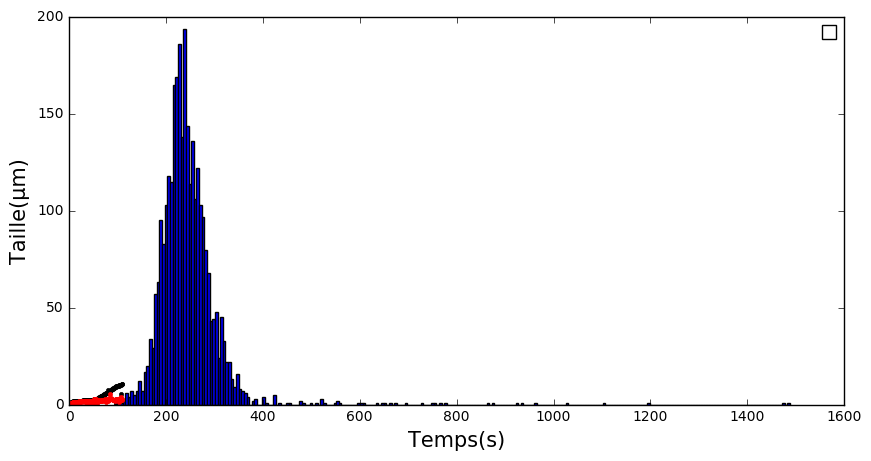

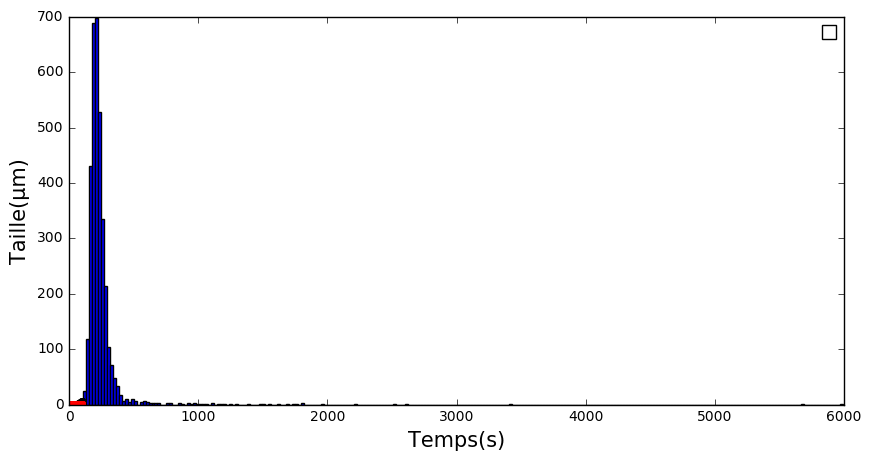

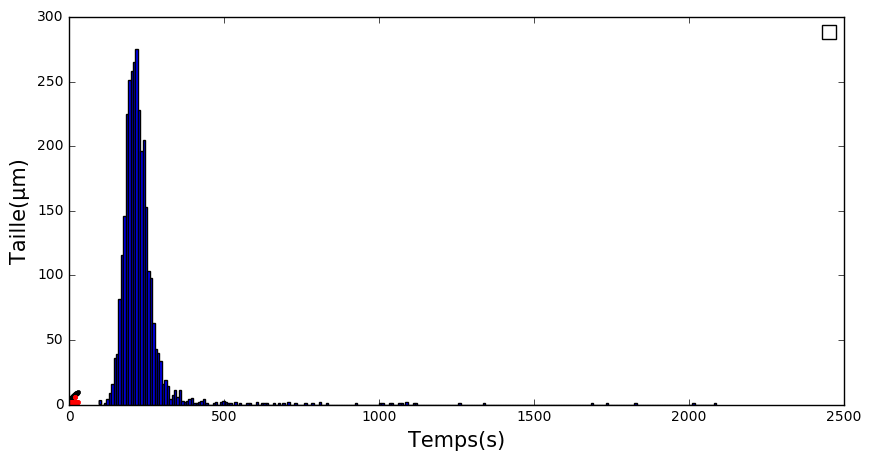

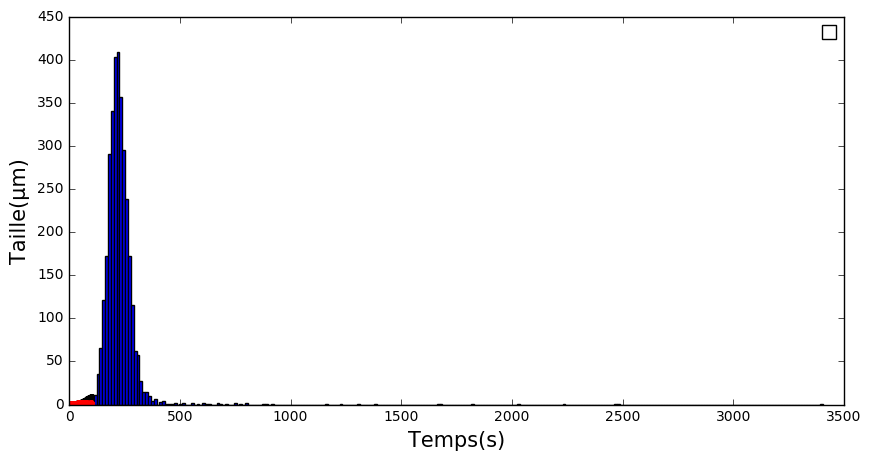

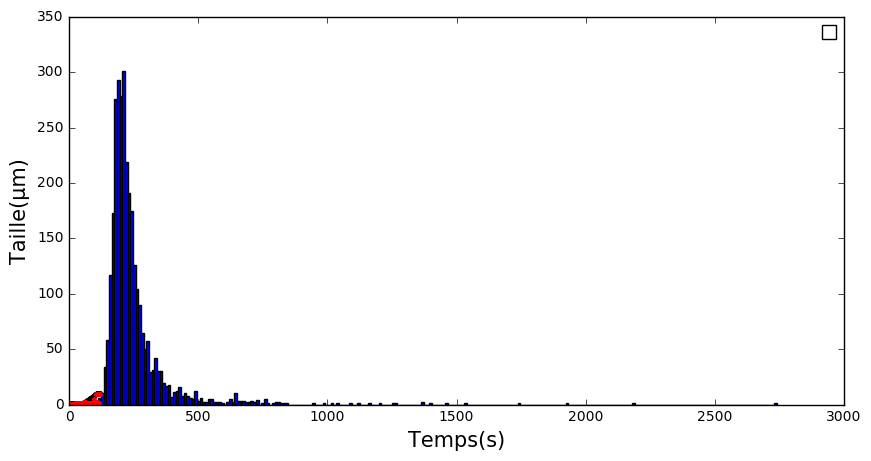

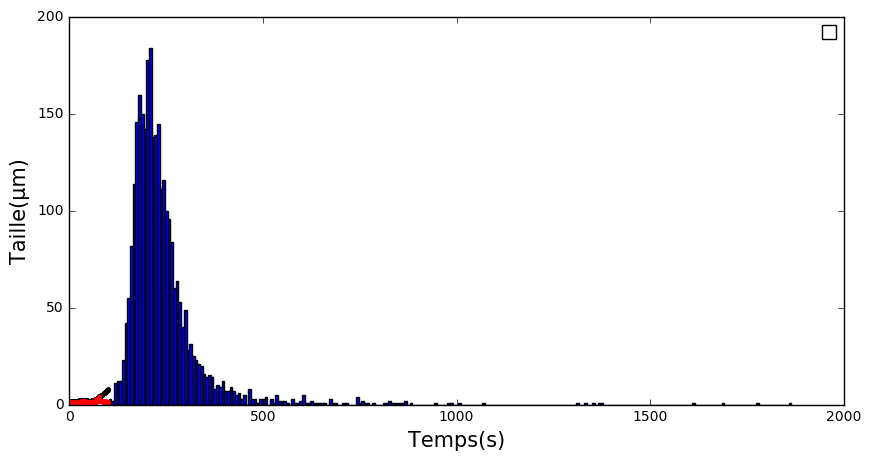

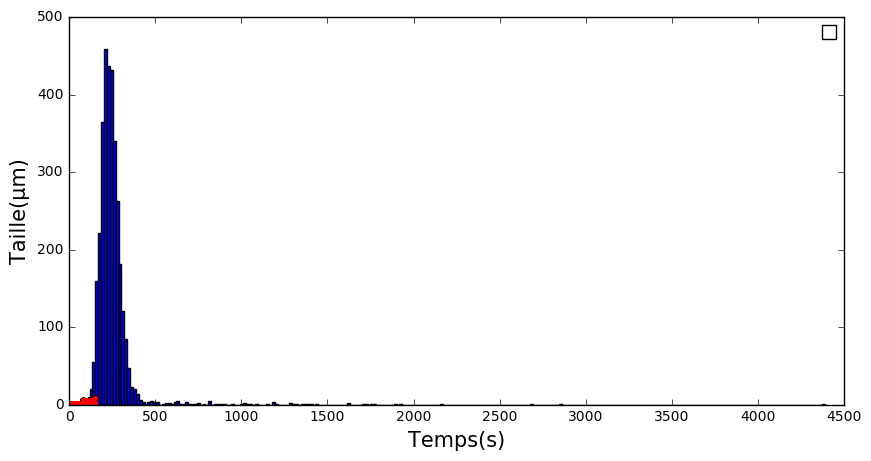

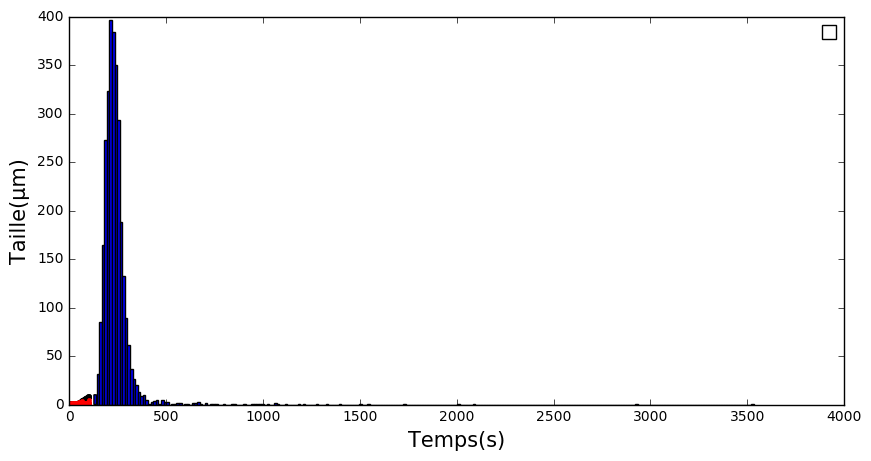

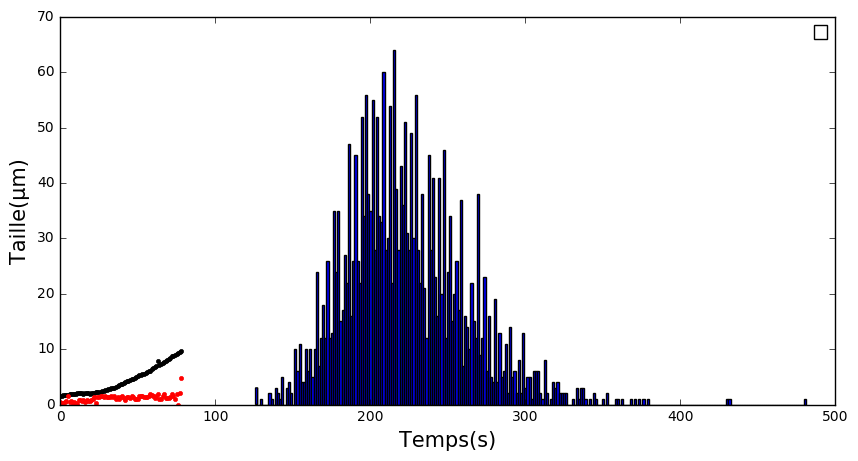

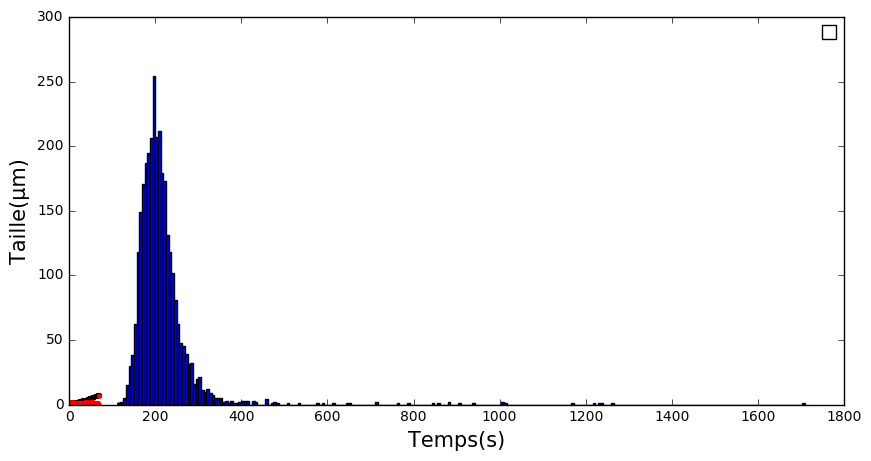

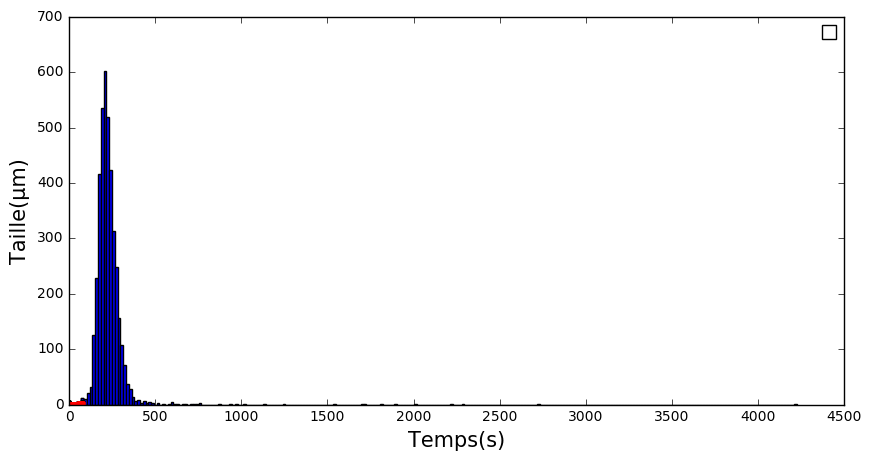

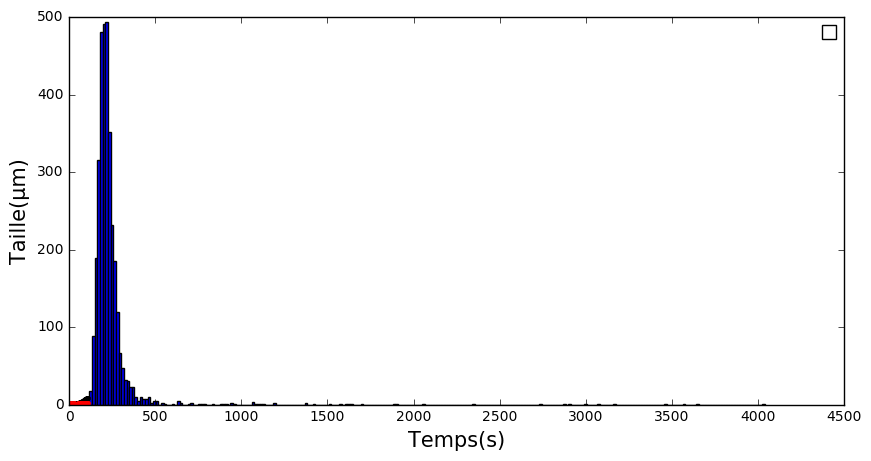

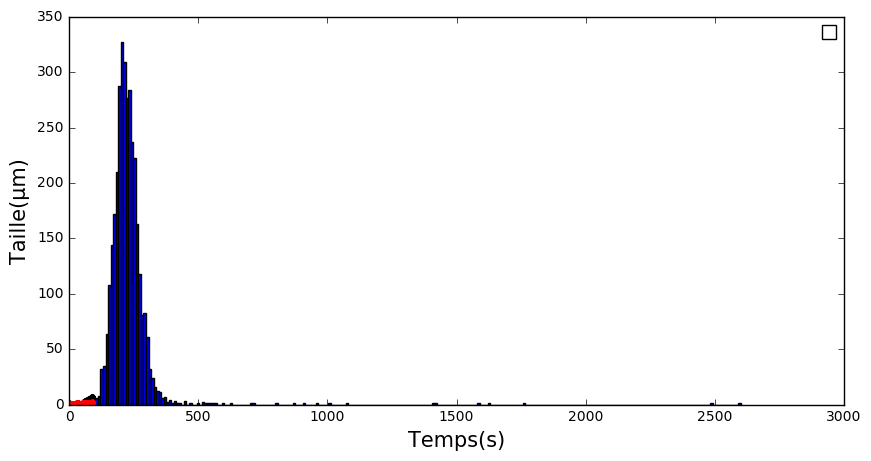

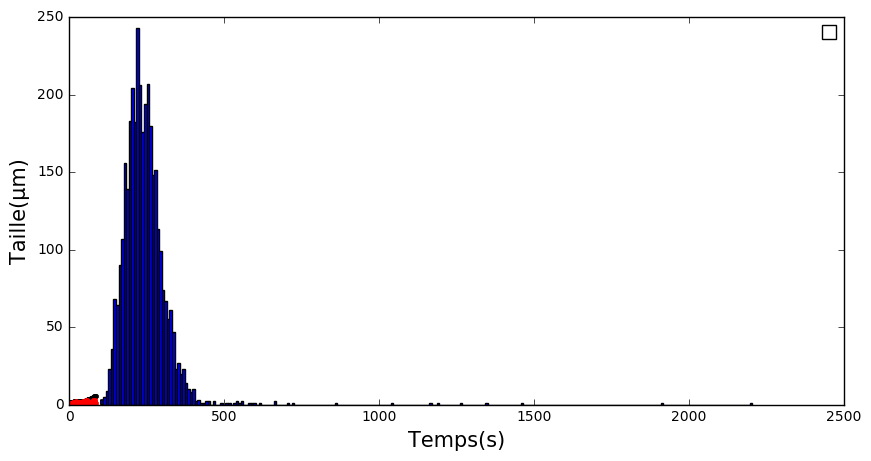

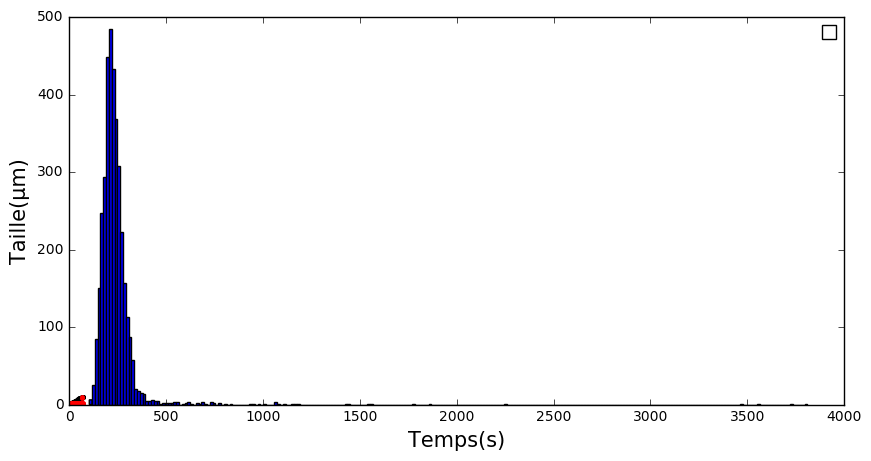

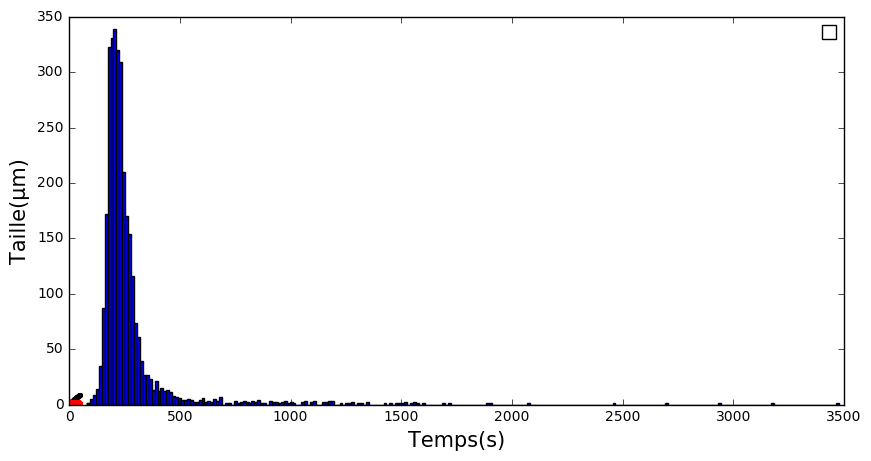

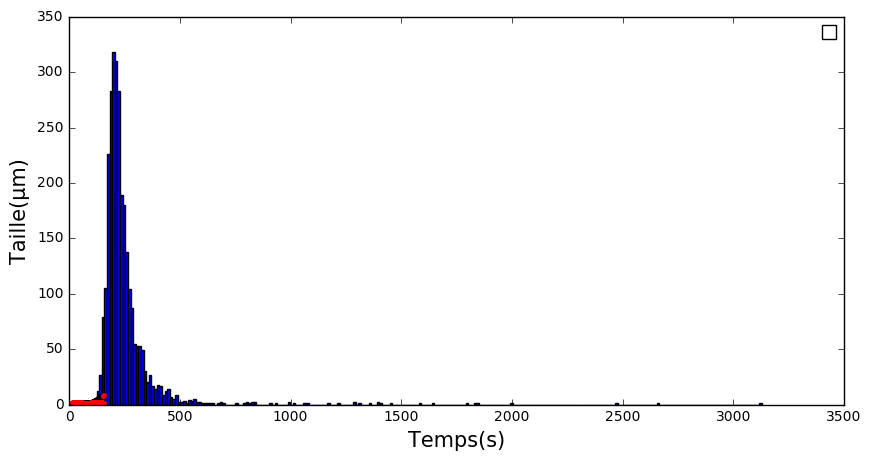

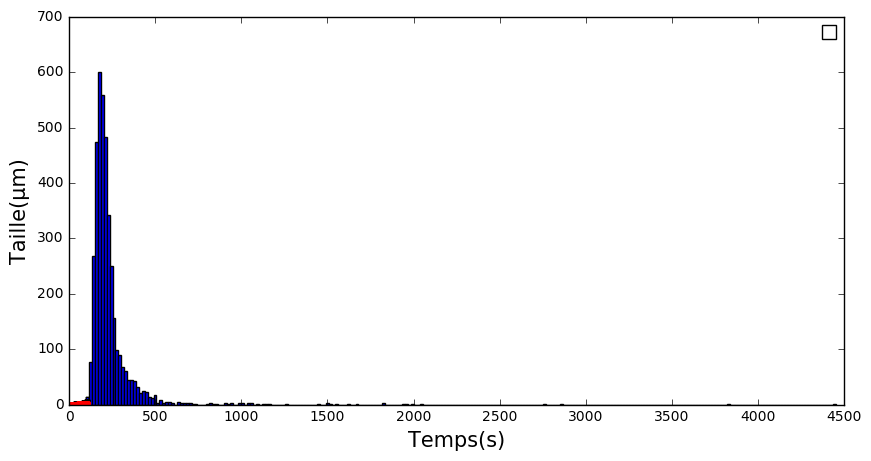

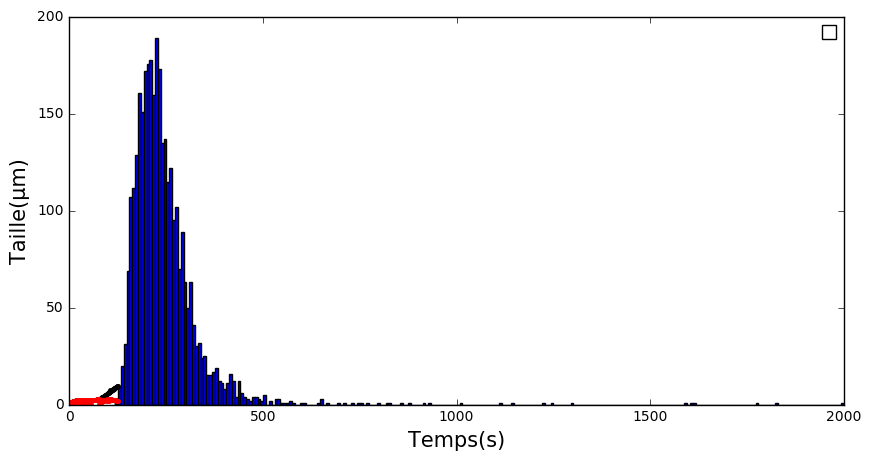

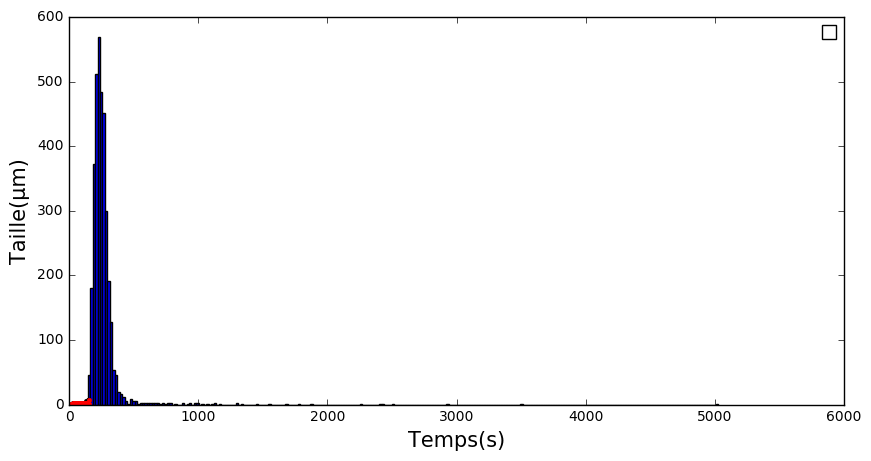

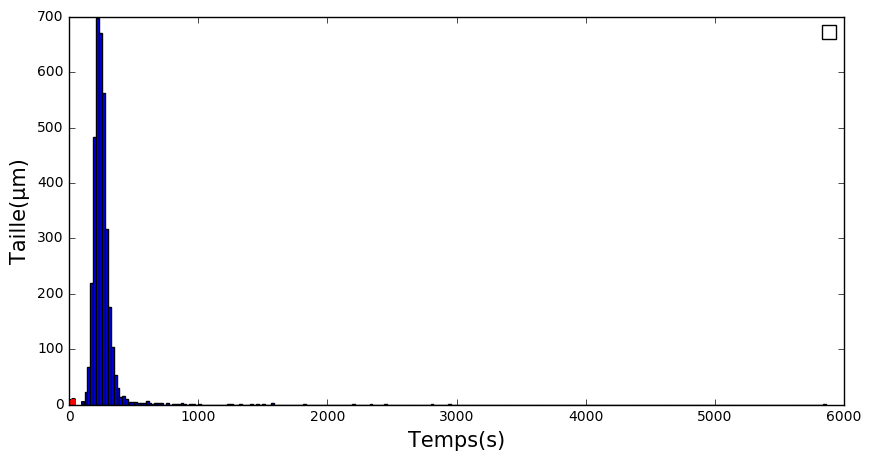

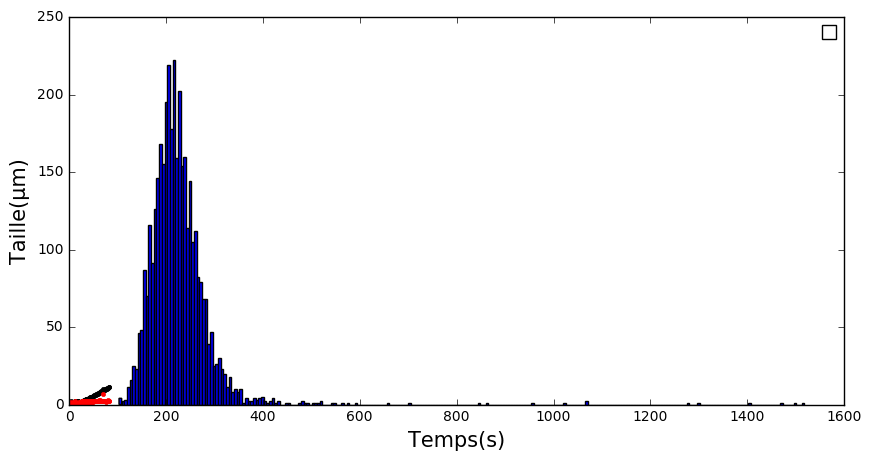

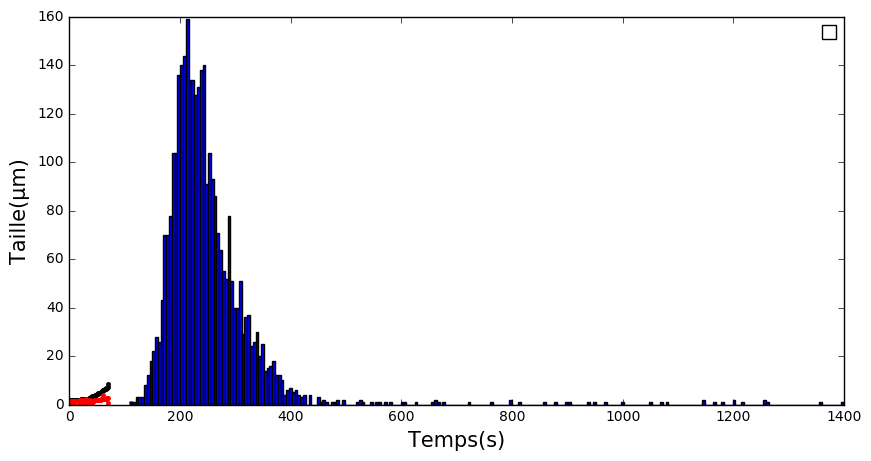

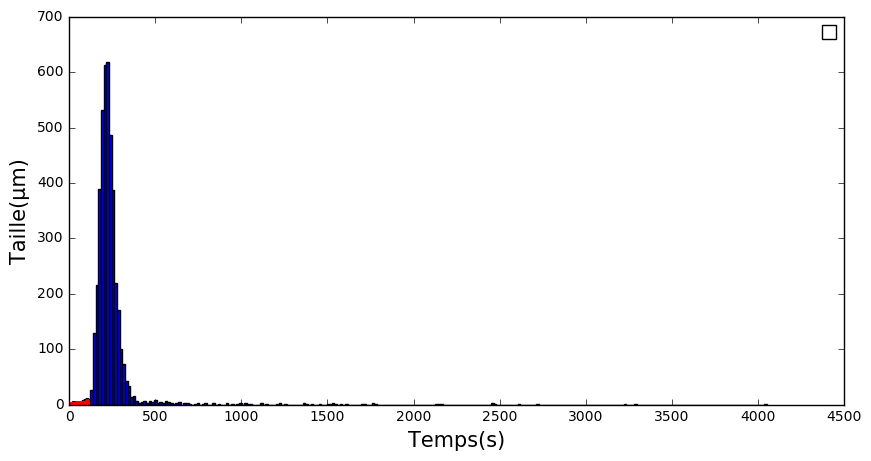

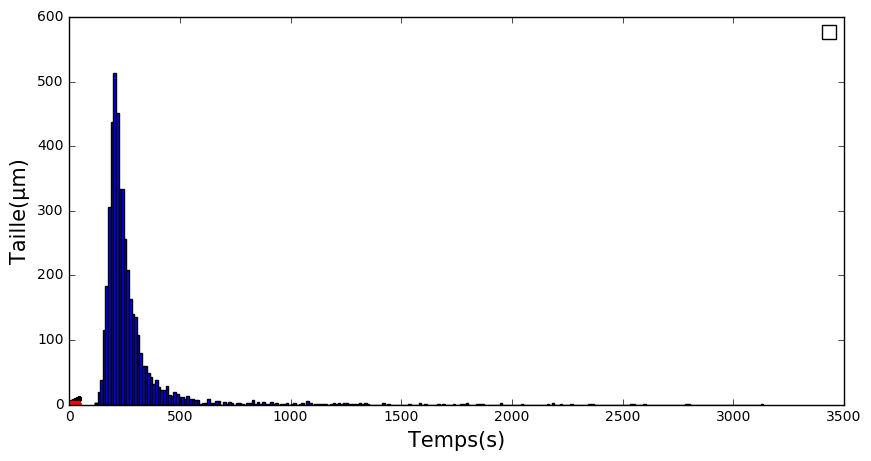

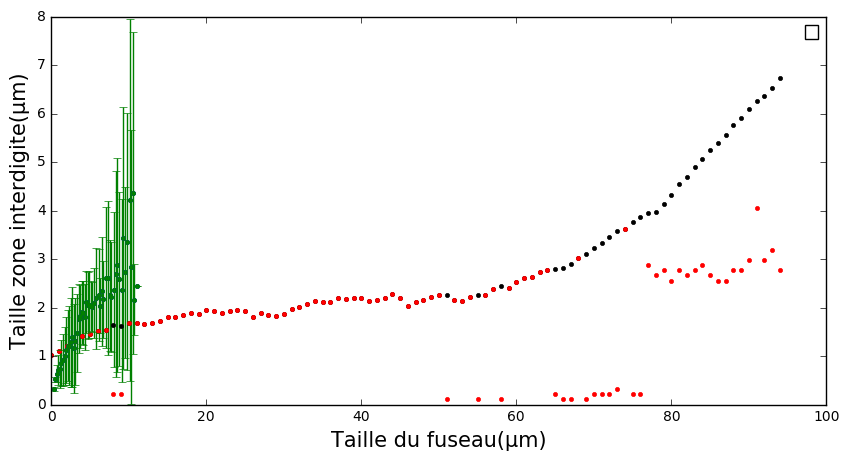

In [6]:
directory_mean = dict()
directory_std  = dict()

for cle, values in directory_size_list.items():
    if math.isnan(np.mean(values)):
        directory_mean[cle]=0
        directory_std[cle]=0

    else:
        directory_mean[cle] = np.mean(values)
        directory_std [cle] = np.std(values)


mean = []
std = []
key = []

for cle, value in directory_mean.items():
    if value !=0 :
        key.append(float(cle))
        mean.append(value)
        std.append(directory_std[cle])
        


plt.plot(key,mean, '.')
plt.errorbar(key, mean, std, linestyle='None', marker='.')

plt.ylabel('Taille zone interdigite(µm)', fontsize=15)
plt.xlabel('Taille du fuseau(µm)', fontsize=15) 
plt.show()

/home/sophie/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning:

Mean of empty slice.



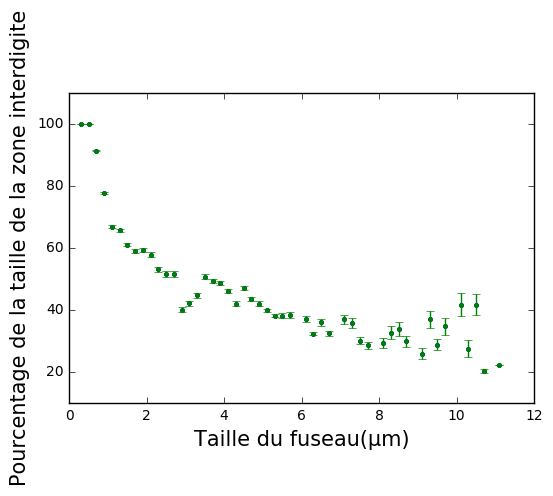

In [7]:
directory_mean_p = dict()
directory_std_p  = dict()

for cle, values in directory_size_list_pourcentage.items():
    if math.isnan(np.mean(values)):
        directory_mean_p[cle]=0
        directory_std_p[cle]=0

    else:
        directory_mean_p[cle] = np.mean(values)
        directory_std_p [cle] = np.std(values)
        
mean_p = []
std_p = []
key = []

for cle, value in directory_mean_p.items():
    if value !=0:
        key.append(float(cle))
        mean_p.append(value)
        std_p.append(directory_std[cle])
        


plt.plot(key,mean_p, '.')
plt.errorbar(key, mean_p, std_p, linestyle='None', marker='.')

plt.ylabel('Pourcentage de la taille de la zone interdigite', fontsize=15)
plt.xlabel('Taille du fuseau(µm)', fontsize=15) 
plt.show()
#plt.savefig("/media/sophie/Sophie/fuseau.png")

In [8]:
key

[7.5,
 9.1,
 9.5,
 1.9,
 5.5,
 0.7,
 3.3,
 0.9,
 1.5,
 4.5,
 1.1,
 6.7,
 10.3,
 4.3,
 1.7,
 6.1,
 8.7,
 8.5,
 8.1,
 7.7,
 2.3,
 11.1,
 3.9,
 5.1,
 3.5,
 0.5,
 0.3,
 9.7,
 7.3,
 4.7,
 6.5,
 3.7,
 5.7,
 2.9,
 5.3,
 4.1,
 2.5,
 4.9,
 9.3,
 8.3,
 7.1,
 1.3,
 10.5,
 6.3,
 3.1,
 10.1,
 10.7,
 2.1,
 2.7]

In [9]:
mean_p

[30.069087731795154,
 25.890851802202352,
 28.700245666143033,
 59.36496635878855,
 38.114356910791095,
 91.300228524417506,
 44.761924800883854,
 77.782544037113297,
 60.982650853430037,
 46.89826596682061,
 66.844576611883113,
 32.411868319207763,
 27.525993983093212,
 42.020447282345678,
 59.090441767897673,
 37.00803722837243,
 29.88712859388048,
 33.883852294192366,
 29.29848035592952,
 28.659958458662096,
 53.057539422783449,
 22.27687105465159,
 48.810283926651387,
 39.911206252539714,
 50.712131971420447,
 100.0,
 100.0,
 34.664612154699881,
 35.818122908033168,
 43.529222863745922,
 35.959867536659019,
 49.220465560958708,
 38.401647781990086,
 40.106846521750342,
 38.147498638599302,
 46.014657470148478,
 51.541416905943819,
 42.050235702930038,
 36.957607108104455,
 32.572815418312317,
 36.932331217884759,
 65.653789944021597,
 41.651044010943856,
 32.370516796262777,
 42.076427601172007,
 41.694008582845747,
 20.208333420104395,
 57.851276085910726,
 51.484934458040541]

0.3


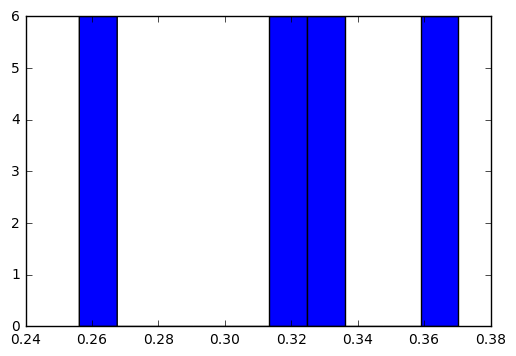

0.5


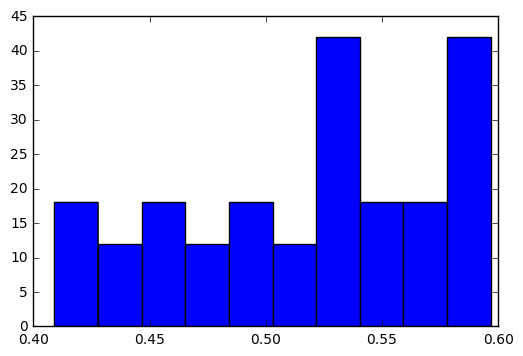

0.7


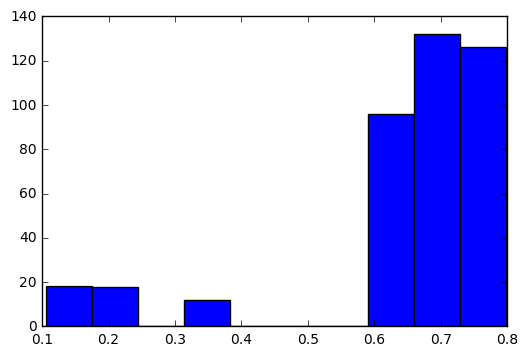

0.9


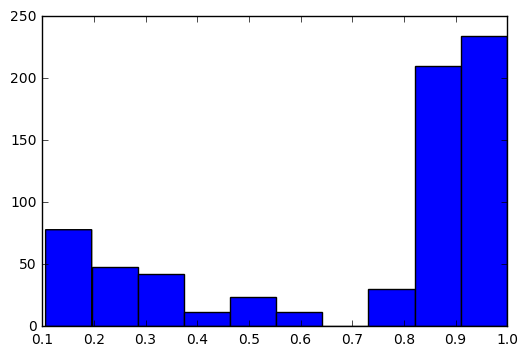

1.1


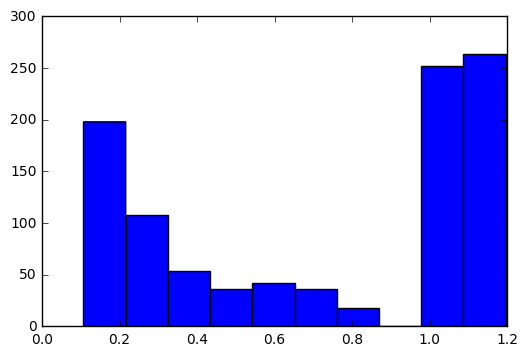

1.3


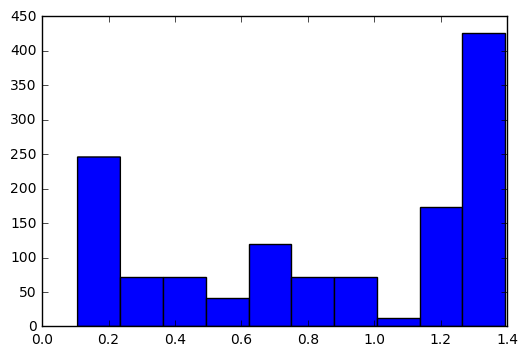

1.5


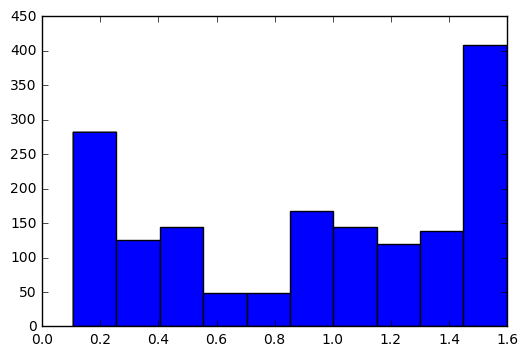

1.7


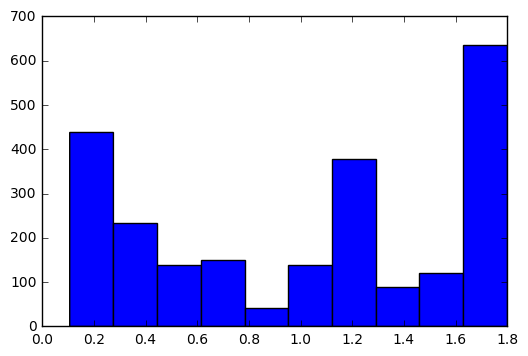

1.9


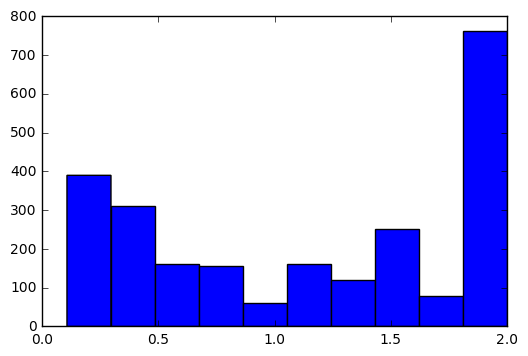

2.1


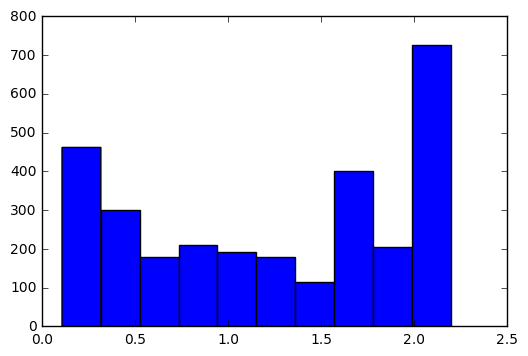

2.3


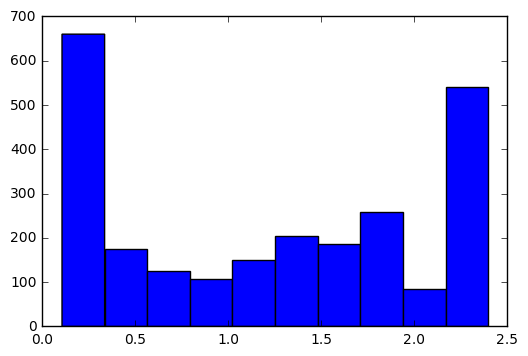

2.5


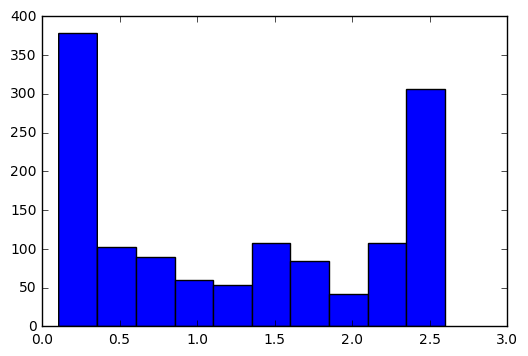

2.7


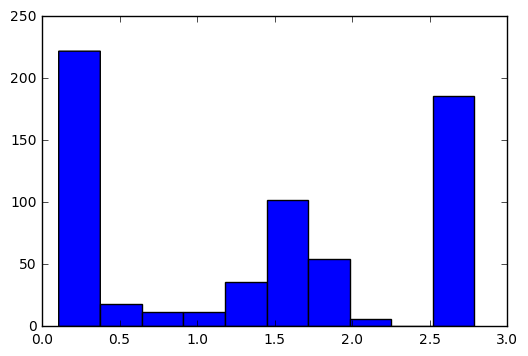

2.9


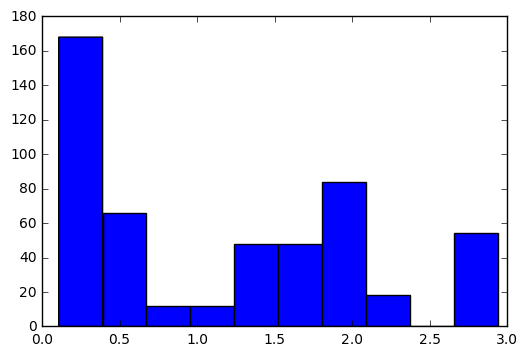

3.1


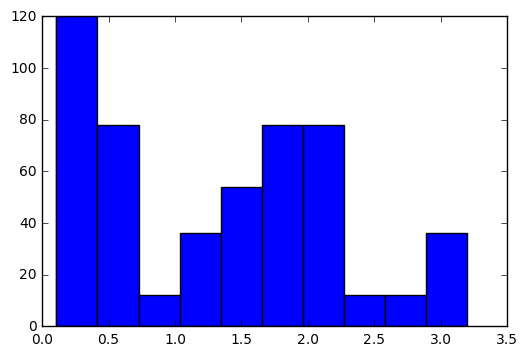

3.3


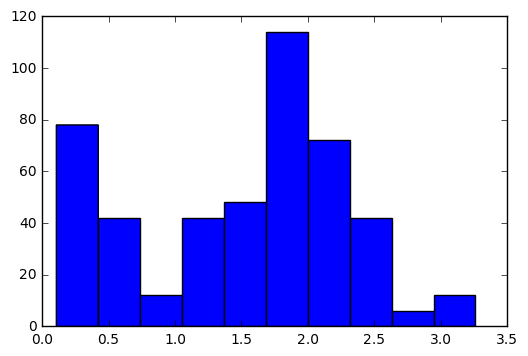

3.5


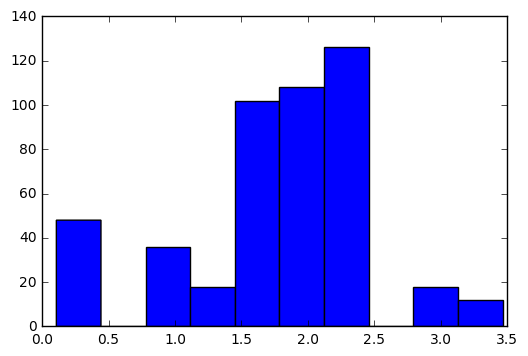

3.7


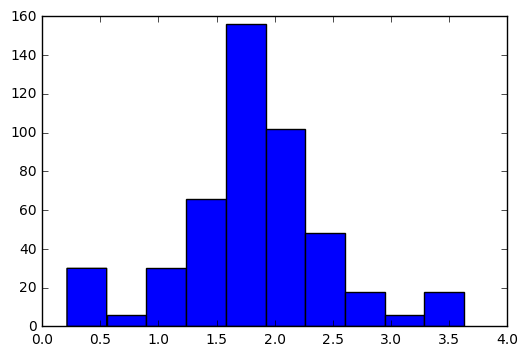

3.9


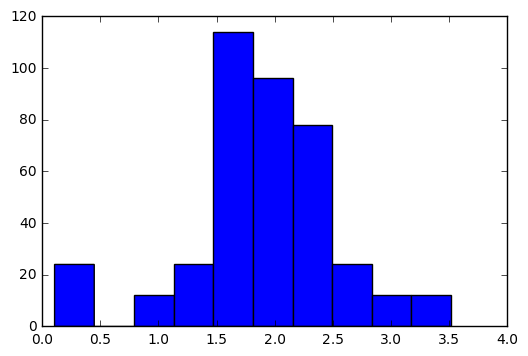

4.1


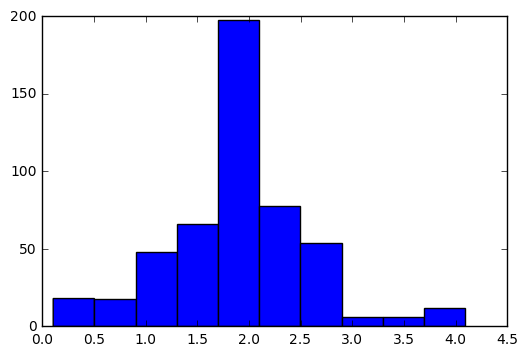

4.3


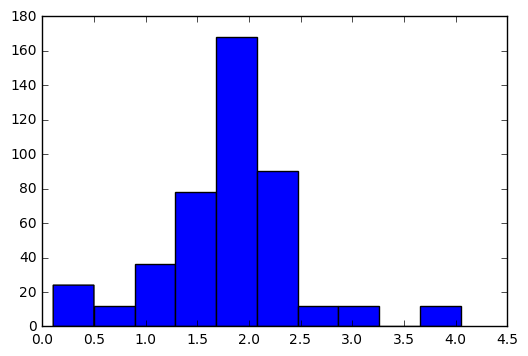

4.5


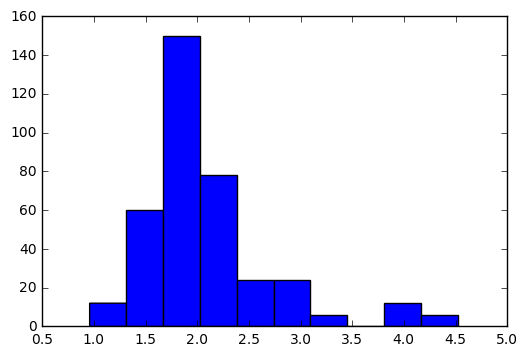

4.7


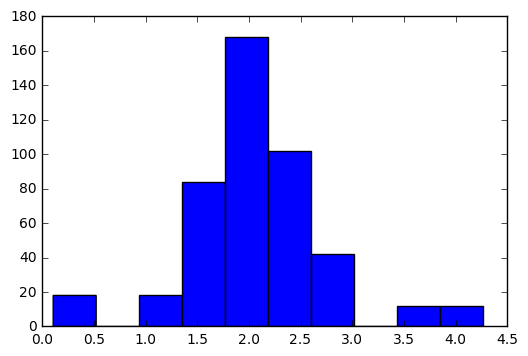

4.9


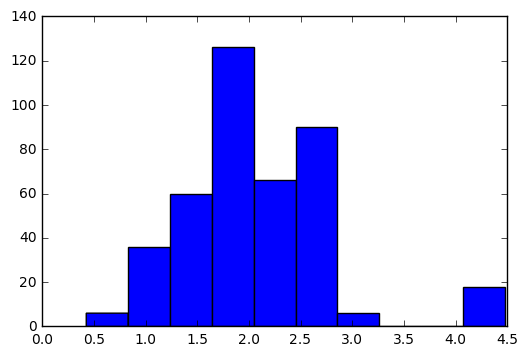

5.1


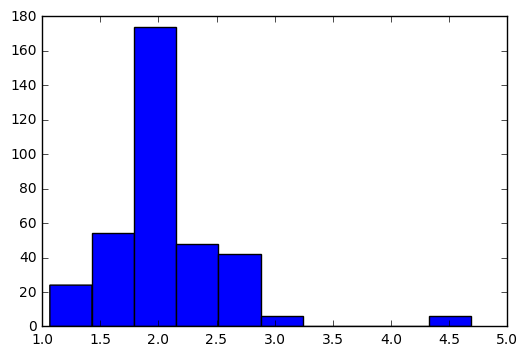

5.3


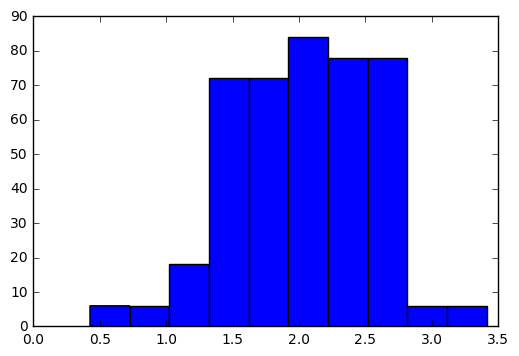

5.5


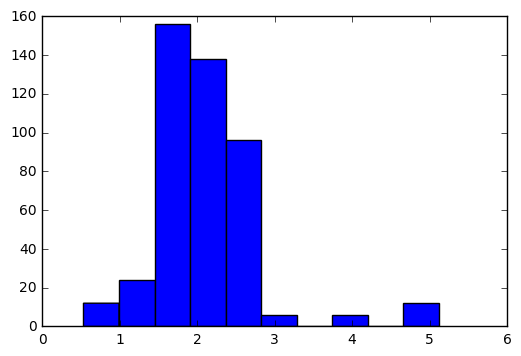

5.7


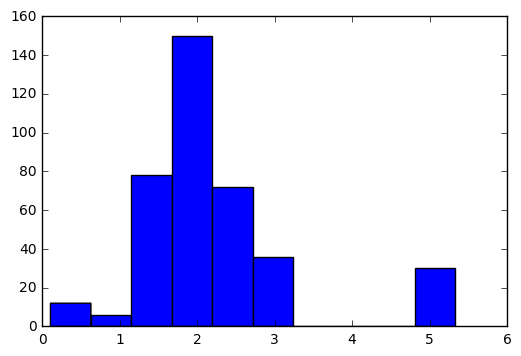

5.9


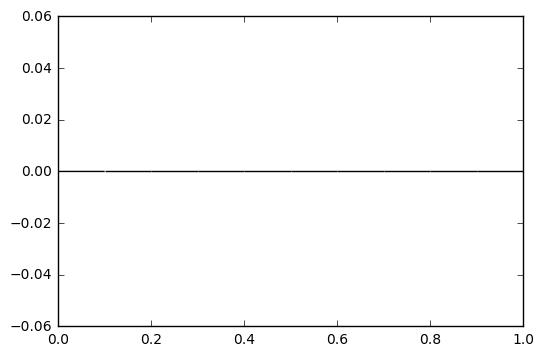

6.1


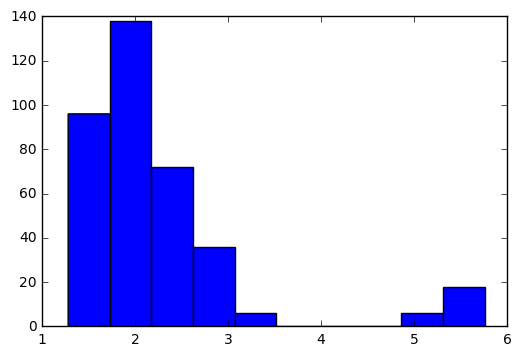

6.3


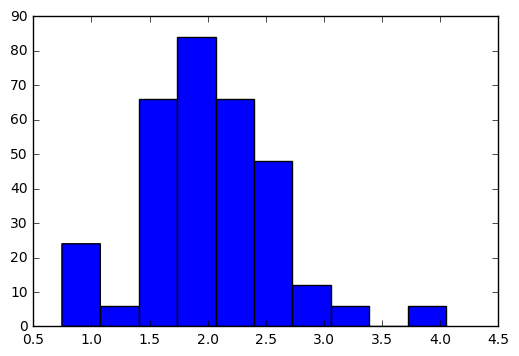

6.5


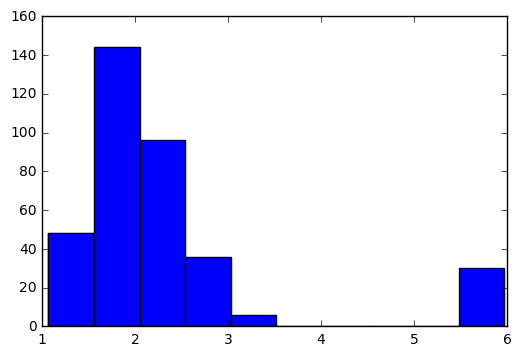

6.7


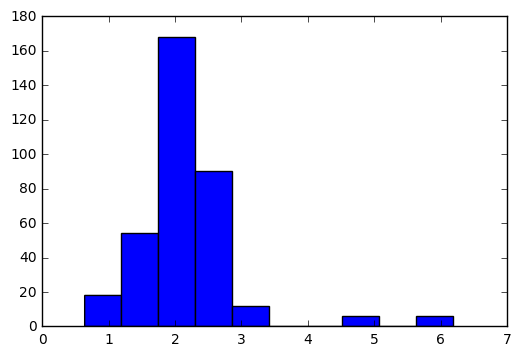

6.9


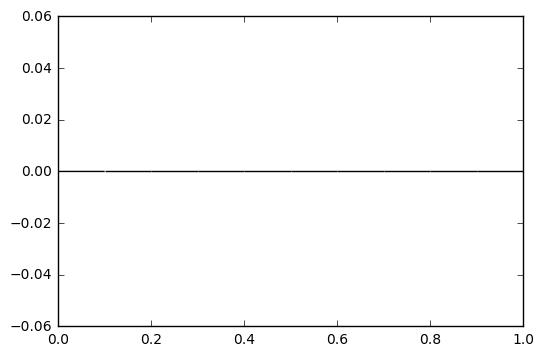

7.1


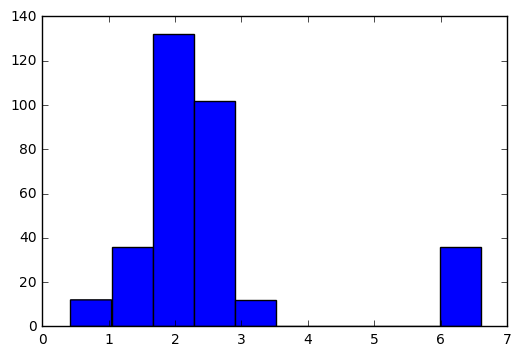

7.3


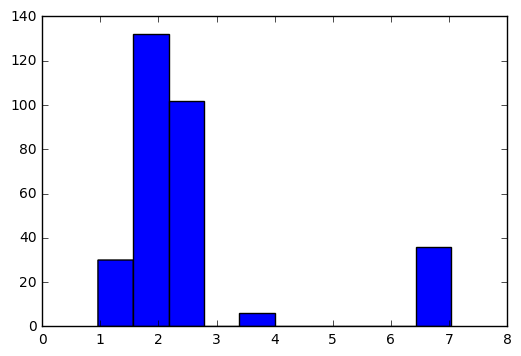

7.5


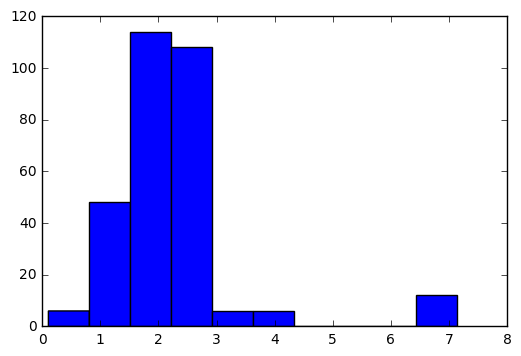

7.7


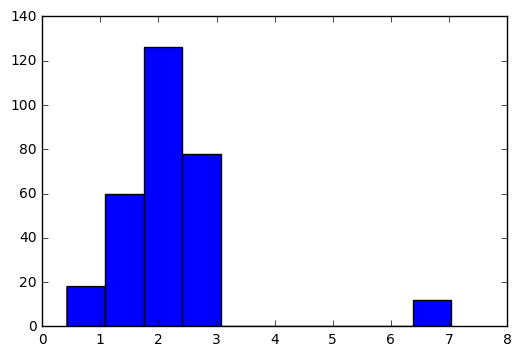

7.9


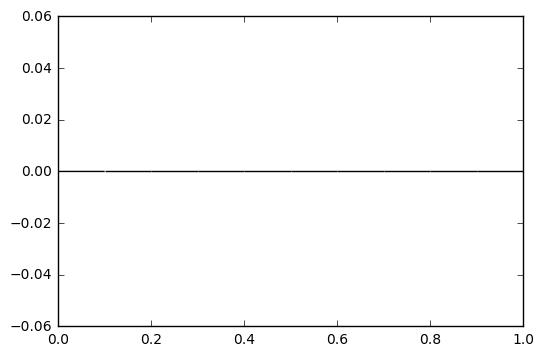

8.1


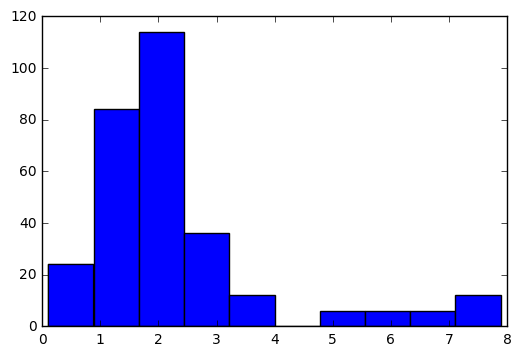

8.3


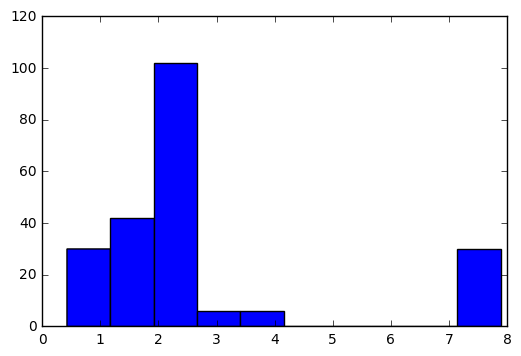

8.5


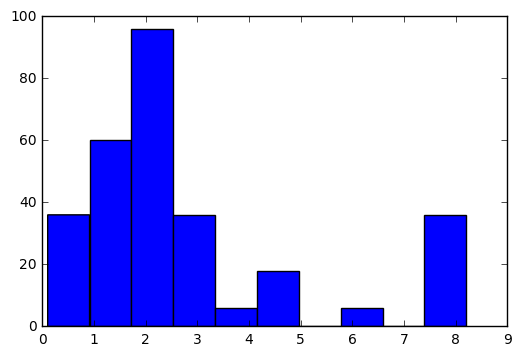

8.7


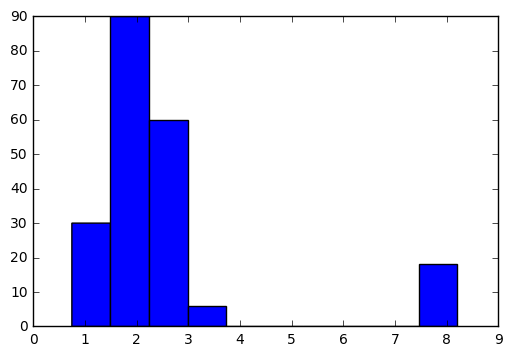

8.9


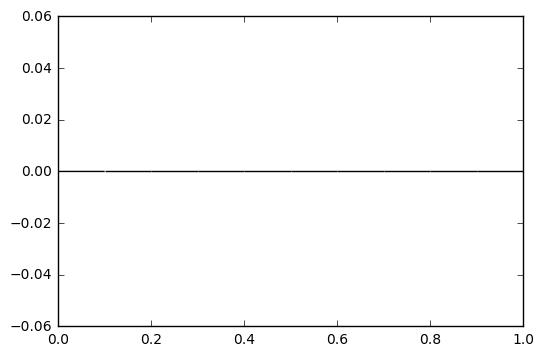

9.1


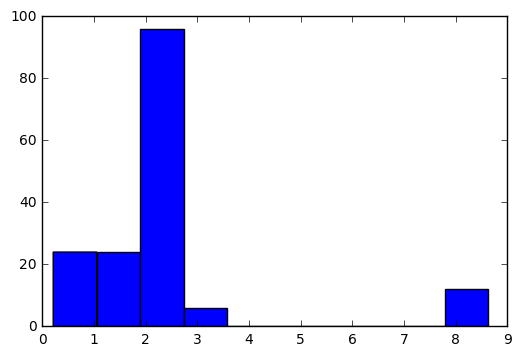

9.3


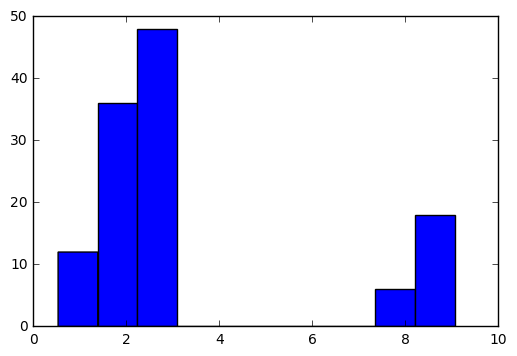

9.5


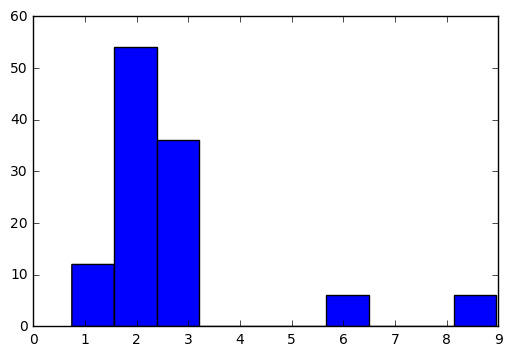

9.7


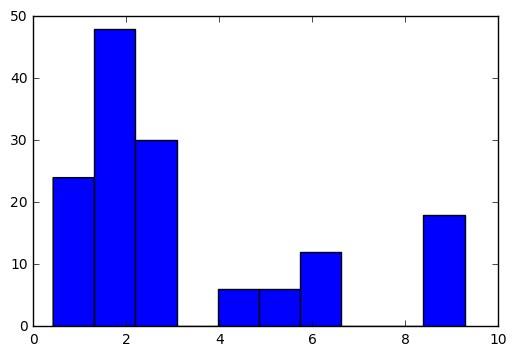

9.9


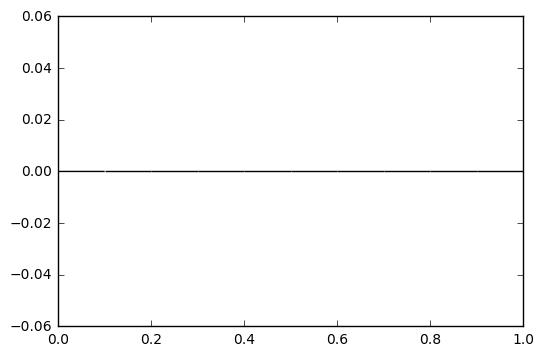

10.1


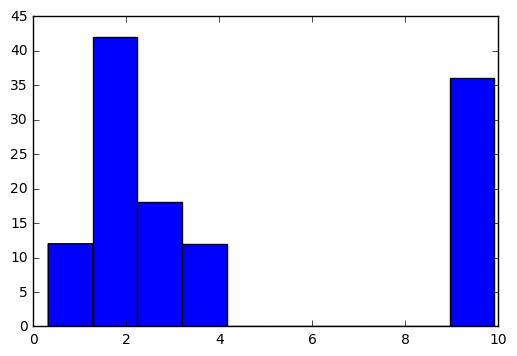

10.3


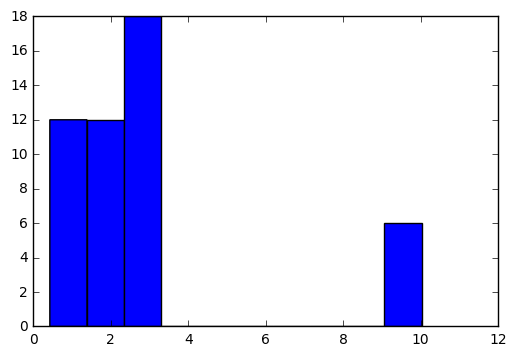

10.5


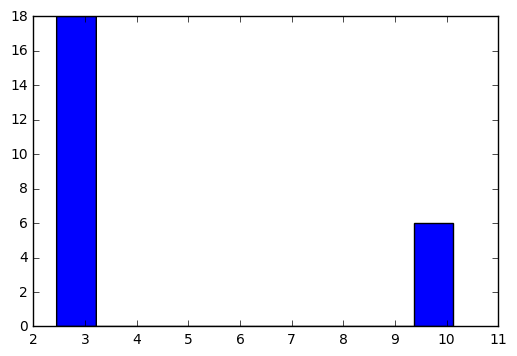

10.7


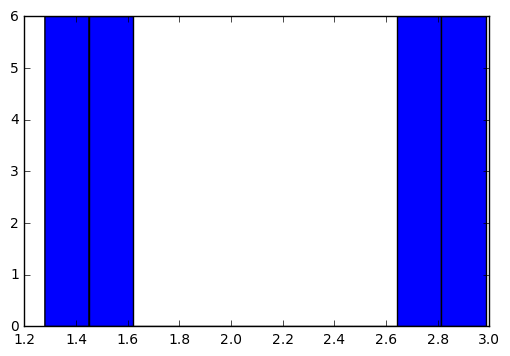

In [10]:
for key in pl.frange(0.3,10.7,0.2):
    print (key)
    plt.hist(directory_size_list[str(key)])
    plt.show()